In [1]:
#!pip install ttpy

In [8]:
import pandas as pd

In [10]:
len(['2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-29'])

7

In [15]:
d = {'date': ['2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-29'],
     'new_diagnoses': [248, 242, 261, 315, 344, 411, 487], 
     'new_tests': [7638, 4969, 9554, 16148, 16901, 17686,  17686]}
df11 = pd.DataFrame(data=d)
df11.set_index('date', drop = True)

,new_diagnoses,new_tests
date,,
2022-01-23,248,7638
2022-01-24,242,4969
2022-01-25,261,9554
2022-01-26,315,16148
2022-01-27,344,16901
2022-01-28,411,17686
2022-01-29,487,17686


In [14]:
df.set_index('date', drop = True)

,new_diagnoses,new_tests
date,,
2022-01-23,248,7638
2022-01-24,242,4969
2022-01-25,261,9554
2022-01-26,315,16148
2022-01-27,344,16901
2022-01-28,411,17686
2022-01-29,487,17686


## Tensor Train

Д. А. Желтков, И. В. Офёркин, Е. В. Каткова, А. В. Сулимов, В. Б. Сулимов, Е. Е. Тыртышников

*TTDock: метод докинга на основе тензорных поездов*

# My Project

In [1]:
#from __future__ import print_function, absolute_import, division
#import tt
#from tt.optimize import tt_min
import numpy as np
from matplotlib import pyplot as plt

import json
import scipy
#import seaborn as sns
import time

from scipy.optimize import minimize
from scipy import optimize
from numpy import linalg as LA

#sns.set() 

#%matplotlib inline 

## Direct Problem

In [2]:
def rungekutta4(func, param, init_x, T, step = 0.001):

    ## input :
    # func(parameters, x_values) - function discribes the model
    # param - system parameters
    
    # init_x - initial system values
    # T - time-end
    # step - grid step
    
    ## output :
    # result - system vaue on grid of time points
    
    Nt = int(T/step) 
    ad_shape = int(param.size/param.shape[0])
    init_val_temp = np.asarray([init_x.copy()]*ad_shape).T
    
    result = np.zeros((len(init_x), Nt+1, ad_shape))
    result[:,0] = init_val_temp
        
    for j in range(1,Nt+1):
        a1 = step * func(param, init_val_temp, j*step)
        val_temp = init_val_temp + a1*0.5

        a2 = step * func(param, val_temp, (j+0.5)*step)
        val_temp = init_val_temp + a2*0.5

        a3 = step * func(param, val_temp, (j+0.5)*step)
        val_temp = init_val_temp + a3

        a4 = step * func(param, val_temp, (j+1.0)*step)

        init_val_temp += (a1 + 2.0 * a2 + 2.0 * a3 + a4)*1.0 / 6.0

        result[:,j] = init_val_temp
        
#         if (not j%1000) : print('t: {}, res: {}'.format(j*step,result[:,j]))
        #print(result.dtype)
    return result

def data_prediction(param, model, init_x, T, nb_mes, mes_eq_ind):
    ## input :
    # param - parameters of the model
    
    # model
    # init_x - initial system values    
    # T - time-end
    # nb_mes - number of measurements
    # mes_eq_ind - indexes of measured equations

    ## output :
    # result - predicted data (for parameters) at indicated time points, except 0-point
    
    result = rungekutta4(model, param, init_x, T)
    nt = result.shape[1]
    
    ### to return only the mesurements at indecated time points, without 0-point
    mesurements = np.arange(0, nt, int((nt-1)*1.0/nb_mes))[1:]
    
    return result[mes_eq_ind][:,mesurements]

def syntetic_data(model, exact_param, init_x, T, nb_mes, mes_eq_ind, noise = [[0.2], [0], [1]]):
    ## input :
    # model - model for data generation
    # exact_param - the exact parameters of model
    # init_x - initial system values    
    # T - time-end
    # nb_mes - number of measurements
    # mes_eq_ind - indexes of measured equations
    # noise = [%s, alfas, sigmas] - percentages of given gaussian noises for each measured equations
    
    ## output :
    # result - synthetic data with given noise at indicated time points, except 0-point
    
    result = data_prediction(exact_param, model, init_x, T, nb_mes, mes_eq_ind)
    nt = result.shape
    #res = result.copy()
    #print(result)
    
    if (noise != None):
        result += noise[0]*np.random.normal(noise[1],noise[2],nt)
    
    ### to remove some mistakes with negative numbers
    condition = result < 0.0
    result[condition] = 0.0
     
    return result

In [3]:
def full_func(param, data_ex, model, init_x, T, nb_mes, mes_eq_ind):
    ## input :
    # param - parameters of the model
    # data_ex - exact data
    
    # model
    # init_x - initial system values    
    # T - time-end
    # nb_mes - number of measurements
    # mes_eq_ind - indexes of measured equations

    ## output :
    # quadratic loss of model with indicated parameters and exact data
    
    prediction = data_prediction(param, model, init_x, T, nb_mes, mes_eq_ind)
    
    normed_pred = prediction # prediction/np.asarray([np.max(prediction, prediction.shape[-1]).T]).T
    normed_ex = data_ex # data_ex/np.asarray([np.max(data_ex, data_ex.shape[-1]).T]).T
    
    return loss_func(normed_pred, normed_ex)


def loss_func(data_pred, data_ex):
    ## input :
    # data_pred - predicted data
    # data_ex - exact data
    
    ## output :
    # quadratic loss
    return np.sum((data_pred - data_ex)**2, (0,1))  

In [4]:
def TB_HIV_model(param, sys_x, time_point):
    ## input :
    # param - system parameters
    # sys_x - system values at indicated time point
    # time_point
    
    ## output :
    # result - system values at indicated time point
    
    ### TB+HIV model ####
    result = [0]*len(sys_x)
    R = sys_x[0]+sys_x[1]+sys_x[3]+sys_x[4]+sys_x[5]
    J_ast = sys_x[5]+sys_x[6]+sys_x[7] #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    JR = J_ast*1.0/R

    result[0] = param[0] - param[1]*sys_x[0]*(sys_x[2]+sys_x[6])/param[15] - param[2]*sys_x[0]*JR - param[3]*sys_x[0]
    result[1] = param[1]*(sys_x[0]+sys_x[3])*(sys_x[2]+sys_x[6])/param[15] - param[2]*sys_x[1]*JR - (param[3]+param[4]+param[9])*sys_x[1]
    result[2] = param[4]*sys_x[1] -(param[3]+param[6]+param[10])*sys_x[2]
    result[3] = param[9]*sys_x[1] + param[10]*sys_x[2] - param[1]*sys_x[3]*(sys_x[2]+sys_x[6])/param[15] - param[2]*sys_x[3]*JR - param[3]*sys_x[3]
    result[4] = param[2]*(sys_x[0]+sys_x[3])*JR - param[1]*sys_x[4]*(sys_x[2]+sys_x[6])/param[15] - (param[12]+param[3])*sys_x[4]
    result[5] = param[2]*sys_x[1]*JR + param[1]*sys_x[4]*(sys_x[2]+sys_x[6])/param[15] + param[11]*sys_x[6] - (param[13]+param[3]+param[5])*sys_x[5]
    result[6] = param[5]*sys_x[5] - (param[14]+param[3]+param[7]+param[11])*sys_x[6]
    result[7] = param[12]*sys_x[4] + param[13]*sys_x[5] + param[14]*sys_x[6] - (param[3]+param[8])*sys_x[7]

    return np.asanyarray(result)  

In [5]:
### from ttpy, but with more detailed print of results
def reshape(a, sz):
    return np.reshape(a, sz, order='F')
  
def mkron(a, b):
    return np.kron(a, b)
  
def mysvd(a, full_matrices=False):
    try:
        return np.linalg.svd(a, full_matrices)
    except:
        return np.linalg.svd(a + np.max(np.abs(a).flatten()) * 1e-14 *
                             np.random.randn(a.shape[0], a.shape[1]), full_matrices)
  
def min_func(fun, bounds_min, bounds_max, d=None, rmax=10,
             n0=64, nswp=10, verb=True, smooth_fun=None, solution=None):
    """Find (approximate) minimal value of the function on a d-dimensional grid."""
    if d is None:
        d = len(bounds_min)
        a = np.asanyarray(bounds_min).copy()
        b = np.asanyarray(bounds_max).copy()
    else:
        a = np.ones(d) * bounds_min
        b = np.ones(d) * bounds_max

    if smooth_fun is None:
        smooth_fun = lambda p, lam: (np.pi / 2 - np.arctan(p - lam))
    #smooth_fun = lambda p, lam: np.exp(-10*(p - lam))

    result = {'func' : [], 'point' : []}
    
    # We do not need to store the cores, only the interfaces!
    Rx = [[]] * (d + 1)  # Python list for the interfaces
    Rx[0] = np.ones((1, 1))
    Rx[d] = np.ones((1, 1))
    Jy = [np.empty(0, dtype=np.int)] * (d + 1)
    ry = rmax * np.ones(d + 1, dtype=np.int)
    ry[0] = 1
    ry[d] = 1
    n = n0 * np.ones(d, dtype=np.int)
    fun_evals = 0

    grid = [np.reshape(np.linspace(a[i], b[i], n[i]), (n[i], 1))
            for i in range(d)]
    for i in range(d - 1):
        #cr1 = y[i]
        ry[i + 1] = min(ry[i + 1], n[i] * ry[i])
        cr1 = np.random.randn(ry[i], n[i], ry[i + 1])
        cr1 = reshape(cr1, (ry[i] * n[i], ry[i + 1]))
        q, r = np.linalg.qr(cr1)
        ind = tt_min.maxvol(q)
        w1 = mkron(np.ones((n[i], 1), dtype=np.int), Jy[i])
        w2 = mkron(grid[i], np.ones((ry[i], 1), dtype=np.int))
        Jy[i + 1] = np.hstack((w1, w2))
        Jy[i + 1] = reshape(Jy[i + 1], (ry[i] * n[i], -1))
        Jy[i + 1] = Jy[i + 1][ind, :]

        # Jy{i+1} = [kron(ones(n(i),1), Jy{i}), kron((1:n(i))', ones(ry(i),1))];
        # Jy{i+1} = Jy{i+1}(ind,:);
    swp = 0
    dirn = -1
    i = d - 1
    lm = float('Inf')
    while swp < nswp:
        # Right-to-left sweep
        # The idea: compute the current core; compute the function of it;
        # Shift locally or globally? Local shift would be the first try
        # Compute the current core

        if np.size(Jy[i]) == 0:
            w1 = np.zeros((ry[i] * n[i] * ry[i + 1], 0), dtype=np.int)
        else:
            w1 = mkron(np.ones((n[i] * ry[i + 1], 1), dtype=np.int), Jy[i])
        w2 = mkron(mkron(np.ones((ry[i + 1], 1), dtype=np.int),
                         grid[i]), np.ones((ry[i], 1), dtype=np.int))
        if np.size(Jy[i + 1]) == 0:
            w3 = np.zeros((ry[i] * n[i] * ry[i + 1], 0), dtype=np.int)
        else:
            w3 = mkron(Jy[i + 1], np.ones((ry[i] * n[i], 1), dtype=np.int))

        J = np.hstack((w1, w2, w3))
        # Just add some random indices to J, which is rnr x d, need to make rn (r + r0) x add,
        # i.e., just generate random r, random n and random multiindex

        cry = fun(J)
        fun_evals += cry.size
        cry = reshape(cry, (ry[i], n[i], ry[i + 1]))
        min_cur = np.min(cry.flatten("F"))
        ind_cur = np.argmin(cry.flatten("F"))
        if lm > min_cur:
            lm = min_cur
            x_full = J[ind_cur, :]
            val = fun(x_full)
            
            result['point'].append(x_full)
            result['func'].append(val)
            
            if verb:
                if solution is None: 
                    print('New record:', val, 'Point:', x_full, 'fevals:', fun_evals)
                else :
                    print('New record:', val, 'Point:', x_full, 'Relative Error:', np.abs(x_full-solution)/solution, 'fevals:', fun_evals)
                
        cry = smooth_fun(cry, lm)
        if (dirn < 0 and i > 0):
            cry = reshape(cry, (ry[i], n[i] * ry[i + 1]))
            cry = cry.T
            #q, r = np.linalg.qr(cry)
            u, s, v = mysvd(cry, full_matrices=False)
            ry[i] = min(ry[i], rmax)
            q = u[:, :ry[i]]
            ind = tt_min.rect_maxvol(q)[0]  # maxvol(q)
            ry[i] = ind.size
            w1 = mkron(np.ones((ry[i + 1], 1), dtype=np.int), grid[i])
            if np.size(Jy[i + 1]) == 0:
                w2 = np.zeros((n[i] * ry[i + 1], 0), dtype=np.int)
            else:
                w2 = mkron(Jy[i + 1], np.ones((n[i], 1), dtype=np.int))
            Jy[i] = np.hstack((w1, w2))
            Jy[i] = reshape(Jy[i], (n[i] * ry[i + 1], -1))
            Jy[i] = Jy[i][ind, :]

        if (dirn > 0 and i < d - 1):
            cry = reshape(cry, (ry[i] * n[i], ry[i + 1]))
            q, r = np.linalg.qr(cry)
            #ind = maxvol(q)
            ind = tt_min.rect_maxvol(q)[0]
            ry[i + 1] = ind.size
            w1 = mkron(np.ones((n[i], 1), dtype=np.int), Jy[i])
            w2 = mkron(grid[i], np.ones((ry[i], 1), dtype=np.int))
            Jy[i + 1] = np.hstack((w1, w2))
            Jy[i + 1] = reshape(Jy[i + 1], (ry[i] * n[i], -1))
            Jy[i + 1] = Jy[i + 1][ind, :]

        i += dirn
        if i == d or i == -1:
            dirn = -dirn
            i += dirn
            swp = swp + 1
    return val, x_full, result


## Syntetic data (8-parameters)

In [6]:
## Model Initial Data
Nb_eq = 8
Y0 = np.zeros(Nb_eq)
### 2007, the Sverdlovsk district (thousands of people)
Y0[0]=430
Y0[1]=3854.5
Y0[2]=11.374 #впервые: 4913 #16.875 ###  ТБ
Y0[3]=3.412
Y0[4]=3.2757
Y0[5]=27.7
Y0[6]=1.593 #1.4 ###  ТБ+ВИЧ
Y0[7]=0.556 #0.357 ###  СПИД

## Exact Model Parameters
Nb_param = 16
P_exact = np.zeros(Nb_param)
### From the article
P_exact[0]=43
P_exact[1]=0.025
P_exact[2]=0.0004
P_exact[3]=0.0143
P_exact[4]=0.05 ###
P_exact[5]=0.25 #5*P_exact[4] ###
P_exact[6]=0.1 #0.06685 
P_exact[7]=0.2 #0.222
P_exact[8]=0.5 #0.997
P_exact[9]=3 ###
P_exact[10]=1 ###
P_exact[11]=3 ###
P_exact[12]=0.1 ###
P_exact[13]=2*P_exact[12] ###
P_exact[14]=5*P_exact[12] ###
P_exact[15]=4315.759

In [7]:
Nb_estim_param = 10
param_ind = np.zeros(Nb_estim_param, dtype=int)

# # For identificir (Dacha, article)
# param_ind[0]=4
# param_ind[1]=5
# param_ind[2]=10
# param_ind[3]=12
# param_ind[4]=13
# param_ind[5]=14

# param_ind[0]=4
# param_ind[1]=5
# param_ind[2]=9
# param_ind[3]=10
# param_ind[4]=11
# param_ind[5]=12
# param_ind[6]=13
# param_ind[7]=14

# new my
param_ind[0]=1 # beta c
param_ind[1]=2 # lamb sigm
param_ind[2]=4 # k
param_ind[3]=5 # k*
param_ind[4]=9 # r1
param_ind[5]=10 # r2
param_ind[6]=11 # r*
param_ind[7]=12 # alpha1
param_ind[8]=13 # alpha2
param_ind[9]=14 # # alpha3


## Boundaries of the parameter definition domains
min_bounds = np.zeros(Nb_estim_param)
max_bounds = np.ones(Nb_estim_param)*3.01 ### 9, 10, 11 may be from 0 to inf

Например: Александрова Г.А., Поликарпов А.В., Голубев Н.А., Оськов Ю.И., Кадулина Н.А., Беляева И.М., Гладких Т.Е., Щербакова Г.А., Семенова Т.А. Заболеваемость всего населения России в 2016 году. Статистические материалы. Часть I. М.: Департамент мониторинга, анализа и стратегического развития здравоохранения Минздрава Российской Федерации, ФГБУ «Центральный научно-исследовательский институт организации и информатизации здравоохранения» Минздрава Российской Федерации. 2017. Доступно по: http://mednet.ru/miac/meditsinskaya-statistika

In [8]:
# Реальные данные в Свердловской области (сначала Викины, потом мои со ссылками)
# Викины
#           2008    2009    2010     2011     2012    2013    2014     2015    2016    2017   2018    2019
I_real =  [17.056, 16.835, 16.816,  15.967,  15.312, 14.522, 13.997, 12.906, 12.189, 11.010, 10.867, 9.858]
J3_real = [2.398,  2.335,     2.5,   3.642,  3.76,     4.22, 2.702,   2.915,  3.117,  3.191,  3.235, 3.071]
A_real =  [0.942,  1.257,     1.8,   2.461,  2.644,   3.977,  4.12,   5.809,  6.487,  7.309,  10.28, 11.425]


# Мои 
#https://last.mednet.ru/miac/meditsinskaya-statistika
I_first =  [5.270, 4.682,  4.663,   4.745,   4.317,  4.088,   3.994,   4.036, 3.753,  3.147,  3.121, 2.877]
I_my     = [11.496, 11.347, 11.334,  10.762,  10.320, 9.788,   9.434,   8.870, 8.436,  7.863,  7.746, 7.363]

#           2008    2009    2010     2011     2012    2013    2014     2015    2016    2017   2018    2019
#    https://old.mednet.ru/ru/czentr-monitoringa-tuberkuleza/produkcziya-czentra.html   + эпид ситуация 2014-2018                                          max
J3_my =    [1.616,  1.574,   1.688,  2.243,    2.248,  2.467, 2.702,   2.915,  3.117,  3.191,  3.235, 3.071]

# http://www.hivrussia.info/elektronnye-versii-informatsionnyh-byulletenij/
A_my =     [0.886,  1.268,   1.961,   2.539,  3.335,   3.996,  4.12,   5.809,  6.487,  7.309,  10.28, 11.425]

MRB  =     [0.621,  0.740,   0.734,  1.109,   1.271,  1.337,  1.536,   1.666,  1.785,  1.916,  2.100, np.nan] 
#           2008      2009    2010     2011     2012    2013    2014     2015    2016     2017   2018     2019
# 2007 34555
HIV =      [39.397, 44.027, 48.726,  53.332,  59.157, 66.469, 73.768,  81.618, 88.101,  94.205,  98.568, 103.754]
HIV_2007 = [34.555,39.397, 44.027, 48.726,  53.332,  59.157, 66.469, 73.768,  81.618, 88.101,  94.205,  98.568, 103.754]
#!!!!!!!!
model_data = [I_my[:9], J3_my[:9], A_my[:9]]
syn_data = np.array(model_data)
syn_data = syn_data.reshape(syn_data.shape[0], syn_data.shape[1], 1)

real_data = [I_my, J3_my, A_my]
syn_data_real = np.array(real_data)
syn_data_real = syn_data_real.reshape(syn_data_real.shape[0], syn_data_real.shape[1], 1)

In [9]:
T = 12 ### 
Nb_mes = 12 ### one mesurement per year
#syn_data = syntetic_data(TB_HIV_model, P_exact, Y0, T, Nb_mes, eq_ind)
DP_exact = rungekutta4(TB_HIV_model, P_exact, Y0, T)

In [11]:
len(HIV)

12

In [21]:
np.arange(0, j, int(j/T)).shape

(13,)

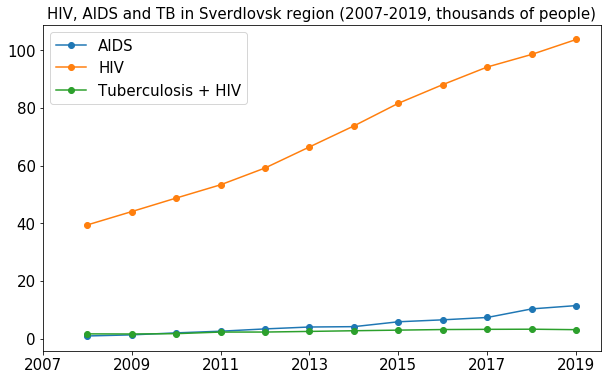

In [79]:
i,j,_ = DP_exact.shape
plt.figure(figsize = (10,6))
plt.plot(np.arange(0, j, int(j/T))[1:], A_my, marker = 'o', label='AIDS')
plt.plot(np.arange(0, j, int(j/T))[1:], HIV, marker = 'o', label = 'HIV')
#plt.plot(np.arange(0, j, int(j/T))[1:], I_my, marker = 'o', label = 'Tuberculosis')
plt.plot(np.arange(0, j, int(j/T))[1:], J3_my, marker = 'o', label = 'Tuberculosis + HIV')
#plt.plot(np.arange(0, j, int(j/T))[1:], MRB, marker = 'o', label = 'MRB Tuberculosis')

plt.legend(fontsize = 15)
plt.xticks(np.arange(0, j, int(2*j/T)),
           np.arange(2007, 2007+T+1, 2.0, dtype=int), 
           color='black', fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('HIV, AIDS and TB in Sverdlovsk region (2007-2019, thousands of people)', fontsize = 15)
plt.show()

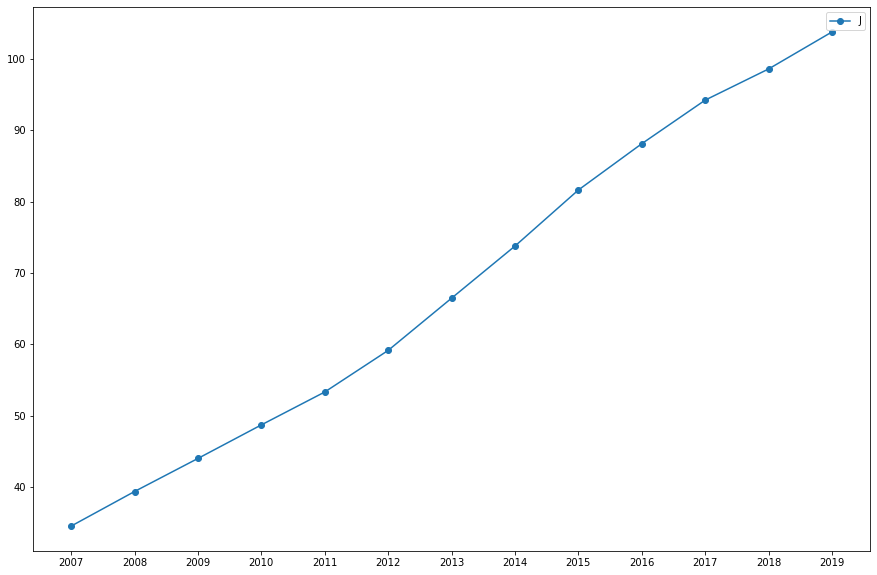

In [30]:
i,j,_ = DP_exact.shape
plt.figure(figsize = (15,10))
plt.plot(np.arange(0, j, int(j/T)), HIV_2007, marker = 'o')

plt.legend(labels='J1')
plt.xticks(np.arange(0, j, int(j/T)),
           np.arange(2007, 2007+T+1, 1.0, dtype=int), 
           color='black')

plt.show()

In [46]:
Nb_mes_eq = 3
eq_ind = np.zeros(Nb_mes_eq, dtype=int)

eq_ind[0]=2
eq_ind[1]=6
eq_ind[2]=7

## Time-line and total number of mesurements
T = 9 ### 
Nb_mes = 9 ### one mesurement per year
#syn_data = syntetic_data(TB_HIV_model, P_exact, Y0, T, Nb_mes, eq_ind)
DP_exact = rungekutta4(TB_HIV_model, P_exact, Y0, T)

In [11]:
#fig, ax = plt.subplots(1, 1)
#i,j,_ = DP_exact.shape
#for g in range(len(eq_ind)):
    #ax.plot(np.arange(j), DP_exact[eq_ind[g]]) # label='{}'.format(g))
    #ax.scatter(np.arange(0, j, int(j/T))[1:],syn_data_real[g])
#ax.scatter(np.arange(0, j, int(j/T))[1:],II[:4])
#ax.scatter(np.arange(0, j, int(j/T))[1:],JJ3[:4])
#ax.scatter(np.arange(0, j, int(j/T))[1:],AA[:4])

#plt.legend(labels=np.asarray(['S', 'L', 'I', 'T', 'J1', 'J2', 'J3', 'A'])[eq_ind])
#plt.xticks(np.arange(0, j, int(j/T)),
           #np.arange(2007, 2007+T+1, 1.0, dtype=int), 
           #color='black')
#plt.show()

# Real data

In [10]:
def fill_param (x, param_ind_ = param_ind, exact_param = P_exact):
    added_shape = int(x.size/x.shape[0])
    param = np.asarray([exact_param.copy()]*added_shape).T
    
    if added_shape == 1 :
        param[param_ind_] = x.reshape((-1, 1))
      
    else: 
        param[param_ind_] = x
    
    return param
    
def func_for_TT(x, ex_data = syn_data, model = TB_HIV_model, init_x = Y0, Time = T, mes = Nb_mes, eq = eq_ind):
    return full_func(fill_param(x.T), ex_data, model, init_x, Time, mes, eq)
  

NameError: name 'eq_ind' is not defined

In [14]:
print("Minimize {}-d LOSS function, where the global minimum is 0 in {} point.".format(Nb_estim_param, P_exact[param_ind]))
val, params_TT, result_TT = min_func(func_for_TT, min_bounds, max_bounds, d=Nb_estim_param, n0=64, rmax=10, nswp=10, solution=P_exact[param_ind])

Minimize 10-d LOSS function, where the global minimum is 0 in [2.5e-02 4.0e-04 5.0e-02 2.5e-01 3.0e+00 1.0e+00 3.0e+00 1.0e-01 2.0e-01
 5.0e-01] point.
New record: [35459.22477149] Point: [1.76777778 0.57333333 0.76444444 0.43       2.77111111 2.19777778
 0.19111111 0.         0.04777778 0.62111111] Relative Error: [6.97111111e+01 1.43233333e+03 1.42888889e+01 7.20000000e-01
 7.62962963e-02 1.19777778e+00 9.36296296e-01 1.00000000e+00
 7.61111111e-01 2.42222222e-01] fevals: 640
New record: [35431.18328029] Point: [1.76777778 0.57333333 0.76444444 0.43       2.77111111 2.19777778
 0.19111111 0.         0.         0.90777778] Relative Error: [6.97111111e+01 1.43233333e+03 1.42888889e+01 7.20000000e-01
 7.62962963e-02 1.19777778e+00 9.36296296e-01 1.00000000e+00
 1.00000000e+00 8.15555556e-01] fevals: 8320
New record: [35211.75865469] Point: [1.76777778 0.57333333 0.76444444 0.43       2.77111111 2.19777778
 1.76777778 0.         0.         0.90777778] Relative Error: [6.97111111e+01 1.43

New record: [120.75393886] Point: [3.01       0.38222222 0.         0.04777778 0.09555556 0.
 0.57333333 0.         0.         1.14666667] Relative Error: [1.19400000e+02 9.54555556e+02 1.00000000e+00 8.08888889e-01
 9.68148148e-01 1.00000000e+00 8.08888889e-01 1.00000000e+00
 1.00000000e+00 1.29333333e+00] fevals: 750272
New record: [120.71388609] Point: [3.01       0.38222222 0.         0.04777778 0.09555556 0.
 0.52555556 0.         0.         1.09888889] Relative Error: [1.19400000e+02 9.54555556e+02 1.00000000e+00 8.08888889e-01
 9.68148148e-01 1.00000000e+00 8.24814815e-01 1.00000000e+00
 1.00000000e+00 1.19777778e+00] fevals: 779008
New record: [120.67979545] Point: [1.29       0.38222222 0.         0.04777778 0.09555556 0.
 0.52555556 0.         0.         1.09888889] Relative Error: [5.06000000e+01 9.54555556e+02 1.00000000e+00 8.08888889e-01
 9.68148148e-01 1.00000000e+00 8.24814815e-01 1.00000000e+00
 1.00000000e+00 1.19777778e+00] fevals: 831424
New record: [120.67976324] P

In [15]:
val

array([120.67976324])

In [16]:
result_TT

{'func': [array([35459.22477149]),
  array([35431.18328029]),
  array([35211.75865469]),
  array([35161.26959209]),
  array([4060.10269725]),
  array([3975.98213641]),
  array([3404.06794303]),
  array([832.31541345]),
  array([824.54279042]),
  array([823.48161895]),
  array([812.98688202]),
  array([788.93196441]),
  array([279.83641751]),
  array([261.75317443]),
  array([207.50595554]),
  array([186.81546907]),
  array([171.88369862]),
  array([171.82611078]),
  array([141.7193845]),
  array([124.63825304]),
  array([123.91925876]),
  array([122.14246214]),
  array([121.6527477]),
  array([121.63356734]),
  array([121.11709652]),
  array([120.75393886]),
  array([120.71388609]),
  array([120.67979545]),
  array([120.67976324])],
 'point': [array([1.76777778, 0.57333333, 0.76444444, 0.43      , 2.77111111,
         2.19777778, 0.19111111, 0.        , 0.04777778, 0.62111111]),
  array([1.76777778, 0.57333333, 0.76444444, 0.43      , 2.77111111,
         2.19777778, 0.19111111, 0.    

In [ ]:
!telegram-send "TT"

In [17]:
params_TT

array([1.24222222, 0.38222222, 0.        , 0.04777778, 0.09555556,
       0.        , 0.52555556, 0.        , 0.        , 1.09888889])

# Optuna

In [18]:
## Model Initial Data
import os
import sciris as sc
import optuna as op

# Create a (mutable) dictionary for global settings
g = sc.objdict()
g.name      = 'my-example-calibration3'
g.db_name   = f'{g.name}.db'
g.storage   = f'sqlite:///{g.db_name}'
g.n_workers = 4 # Define how many workers to run in parallel
g.n_trials = 750 # Define the number of trials, i.e. sim runs, per worker

   
def objective(x, ex_data = syn_data, model = TB_HIV_model, init_x = Y0, Time = T, mes = Nb_mes, eq = eq_ind):
    return full_func(fill_param(x.T), ex_data, model, init_x, Time, mes, eq)


def run_trial(trial):#, param_ind=param_ind, min_bounds=min_bounds, max_bounds=max_bounds):
    pkeys = [str(param_ind[i]) for i in range(len(param_ind))]
    x = np.zeros(len(pkeys))
    for k, key in enumerate(pkeys):
        x[k] = trial.suggest_uniform(key, min_bounds[k], max_bounds[k])
    mismatch = objective(x)
    return mismatch


def worker():
    ''' Run a single worker '''
    study = op.load_study(storage=g.storage, study_name=g.name)
    output = study.optimize(run_trial, n_trials=g.n_trials)
    return output


def run_workers():
    ''' Run multiple workers in parallel '''
    output = sc.parallelize(worker, g.n_workers)
    return output


def make_study():
    ''' Make a study, deleting one if it already exists '''
    if os.path.exists(g.db_name):
        os.remove(g.db_name)
        print(f'Removed existing calibration {g.db_name}')
    output = op.create_study(storage=g.storage, study_name=g.name)
    return output


# Run the optimization
t0 = sc.tic()
make_study()
run_workers()
study = op.load_study(storage=g.storage, study_name=g.name)
params_optuna = study.best_params
T = sc.toc(t0, output=True)
print(f'\n\nOutput: {params_optuna}, time: {T:0.1f} s')

Removed existing calibration my-example-calibration3.db


[I 2021-07-20 22:11:31,180] A new study created in RDB with name: my-example-calibration3
[I 2021-07-20 22:11:35,392] Trial 3 finished with value: 12569997.498526195 and parameters: {'1': 0.6723103265921939, '2': 2.987289257182797, '4': 0.3102579518029253, '5': 2.3568621118027067, '9': 1.188457490805839, '10': 2.045665109870344, '11': 2.5539057932174116, '12': 2.90026584561051, '13': 1.64522892674986, '14': 2.7302352548585067}. Best is trial 3 with value: 12569997.498526195.
[I 2021-07-20 22:11:35,499] Trial 0 finished with value: 67169.93069459072 and parameters: {'1': 2.4068114305497814, '2': 0.35208127178827525, '4': 1.3854034301960974, '5': 1.0569656606106352, '9': 2.289410901670167, '10': 2.938977134805553, '11': 1.669504623152286, '12': 1.913635072198868, '13': 1.6946776661378922, '14': 2.012515714575166}. Best is trial 0 with value: 67169.93069459072.
[I 2021-07-20 22:11:35,613] Trial 2 finished with value: 453709.87819295924 and parameters: {'1': 0.6134692925991911, '2': 0.7972

[I 2021-07-20 22:11:53,054] Trial 20 finished with value: 172789.8183268725 and parameters: {'1': 1.338720755648524, '2': 0.5475906041301917, '4': 2.1669762187841335, '5': 1.0291420673918348, '9': 1.7480573809761024, '10': 2.6057126426964765, '11': 2.759015055114843, '12': 0.2475160679292474, '13': 2.2392502472215123, '14': 2.1490427179377543}. Best is trial 1 with value: 4224.175159107557.
[I 2021-07-20 22:11:53,065] Trial 21 finished with value: 7439394.157547578 and parameters: {'1': 0.014322210742742258, '2': 2.0811528035166456, '4': 2.1195027383318914, '5': 0.986951923768085, '9': 1.7410912953986972, '10': 2.533082269809669, '11': 2.7141127249719275, '12': 1.0514942371945375, '13': 2.142659974777801, '14': 2.2220600224890075}. Best is trial 1 with value: 4224.175159107557.
[I 2021-07-20 22:11:53,236] Trial 22 finished with value: 1271043.823414566 and parameters: {'1': 1.4245382088974636, '2': 1.9543515935159357, '4': 0.8878821563783794, '5': 1.202388338538164, '9': 1.578979862018

[I 2021-07-20 22:12:10,696] Trial 40 finished with value: 82082.87299519658 and parameters: {'1': 0.8072082103986878, '2': 0.7393148126721607, '4': 0.13005362264327194, '5': 2.1352763050458803, '9': 2.835837456421578, '10': 1.6035645343959404, '11': 1.1360239578702487, '12': 2.2368467093155813, '13': 1.3272471340129792, '14': 0.3317767616620993}. Best is trial 1 with value: 4224.175159107557.
[I 2021-07-20 22:12:10,822] Trial 41 finished with value: 6856.860012898326 and parameters: {'1': 0.9986602268191243, '2': 0.2401952288753461, '4': 0.16902314170395577, '5': 1.3289600338196714, '9': 2.8813245011880135, '10': 1.3223198966898702, '11': 1.1076009478977875, '12': 2.3627630839122853, '13': 1.589387581488087, '14': 0.598900724308491}. Best is trial 1 with value: 4224.175159107557.
[I 2021-07-20 22:12:10,901] Trial 42 finished with value: 5590.34166514225 and parameters: {'1': 0.8085360180942829, '2': 0.2964776605094426, '4': 0.13940637700105, '5': 2.1343950536162293, '9': 2.808741363082

[I 2021-07-20 22:12:28,427] Trial 60 finished with value: 1652399.252341284 and parameters: {'1': 1.2422842414432131, '2': 0.16591900389510508, '4': 0.4329829903634467, '5': 2.684079791884143, '9': 0.03350233070563924, '10': 1.2199325460780612, '11': 1.847464973526263, '12': 0.5730801929347193, '13': 2.7348428748800306, '14': 1.6223919360699388}. Best is trial 55 with value: 1600.5442345720942.
[I 2021-07-20 22:12:28,433] Trial 61 finished with value: 24039.096094421293 and parameters: {'1': 1.2292367235977835, '2': 0.18069780800790583, '4': 0.38260430877120843, '5': 2.664167240312735, '9': 2.7634701647870257, '10': 1.5165892967995385, '11': 1.8945225899467224, '12': 0.583580038922789, '13': 2.6501219720786855, '14': 1.622801262892786}. Best is trial 55 with value: 1600.5442345720942.
[I 2021-07-20 22:12:28,661] Trial 62 finished with value: 1557.0624485675773 and parameters: {'1': 0.657614006802835, '2': 0.15803566564973892, '4': 0.023035435690109272, '5': 2.403353945891044, '9': 2.18

[I 2021-07-20 22:12:46,293] Trial 81 finished with value: 280150.84667483 and parameters: {'1': 1.1358883363956285, '2': 0.2206192168058371, '4': 0.23876075379707482, '5': 2.9861425658242364, '9': 1.6520687345637182, '10': 0.30653165565271423, '11': 1.99515314869062, '12': 0.4345944027649099, '13': 2.5165571980409633, '14': 1.1205020949485598}. Best is trial 68 with value: 1432.979594678453.
[I 2021-07-20 22:12:46,615] Trial 82 finished with value: 27559.94367768617 and parameters: {'1': 1.6353332090790185, '2': 0.2286460236905603, '4': 0.22213123393863796, '5': 2.9178741514989257, '9': 1.2855497879892335, '10': 1.7784354174213588, '11': 1.4967190868325644, '12': 0.37936057732302736, '13': 2.5375626101198505, '14': 1.0866067491972826}. Best is trial 68 with value: 1432.979594678453.
[I 2021-07-20 22:12:46,933] Trial 83 finished with value: 17207.955508795378 and parameters: {'1': 1.6480812096691992, '2': 0.003403647108253527, '4': 0.21472031623883606, '5': 1.7244099293014825, '9': 2.05

[I 2021-07-20 22:13:03,825] Trial 101 finished with value: 1147952.6872989724 and parameters: {'1': 0.9025246771702363, '2': 1.7346069350662576, '4': 0.2947482937098381, '5': 2.4937595199156433, '9': 2.2226241156165067, '10': 1.7689891086287668, '11': 1.4142469417222148, '12': 0.5007002226416741, '13': 1.8298330487184784, '14': 1.4527378033713996}. Best is trial 68 with value: 1432.979594678453.
[I 2021-07-20 22:13:04,366] Trial 102 finished with value: 725471.267712963 and parameters: {'1': 1.3366073506487843, '2': 1.6010130352085208, '4': 0.2816304622773626, '5': 2.6040271190008344, '9': 2.2584126335015147, '10': 1.7301482552001977, '11': 1.667925676842612, '12': 0.4904540797278879, '13': 1.692849225904317, '14': 0.9070464694670891}. Best is trial 68 with value: 1432.979594678453.
[I 2021-07-20 22:13:04,604] Trial 103 finished with value: 31791.098651530534 and parameters: {'1': 1.0531745057169963, '2': 0.003381721513089714, '4': 0.28436937815691204, '5': 2.474860991475877, '9': 2.07

[I 2021-07-20 22:13:21,513] Trial 121 finished with value: 4088.6724803947745 and parameters: {'1': 0.8768934246955906, '2': 0.011525320101696684, '4': 0.0632724877091453, '5': 2.5103089834553702, '9': 1.9940728512465695, '10': 0.8163348053961579, '11': 1.9377928045240487, '12': 0.6591395690978075, '13': 2.69277252768116, '14': 1.151274685157544}. Best is trial 68 with value: 1432.979594678453.
[I 2021-07-20 22:13:22,151] Trial 122 finished with value: 36536.31114338058 and parameters: {'1': 1.3834141840450658, '2': 0.04150751211013667, '4': 0.36648852528259457, '5': 2.4829670731626434, '9': 2.0148675547494275, '10': 1.6373210803537344, '11': 1.9074622675097332, '12': 0.6999665675449787, '13': 2.7717762819560954, '14': 1.5816149804833217}. Best is trial 68 with value: 1432.979594678453.
[I 2021-07-20 22:13:22,515] Trial 123 finished with value: 31164.447803746556 and parameters: {'1': 0.4153424232327343, '2': 0.052140520666539236, '4': 0.35735516201020723, '5': 2.885737930257797, '9': 

[I 2021-07-20 22:13:39,170] Trial 140 finished with value: 2746.9514593261397 and parameters: {'1': 1.6097294528335415, '2': 0.20201705374500545, '4': 0.06285372900782235, '5': 2.661780946858726, '9': 2.2912753001402137, '10': 1.2067347191400897, '11': 2.1146317125589715, '12': 1.96663733697069, '13': 2.802391862282411, '14': 0.8300336841031039}. Best is trial 68 with value: 1432.979594678453.
[I 2021-07-20 22:13:39,972] Trial 142 finished with value: 149809.0248398774 and parameters: {'1': 1.6826504014857118, '2': 0.20780560203176335, '4': 0.7604357086411717, '5': 2.670722771174266, '9': 1.9596229741931581, '10': 1.6142323586016005, '11': 2.115899651400532, '12': 1.9179471667250947, '13': 2.460160562407404, '14': 0.8703271679114609}. Best is trial 68 with value: 1432.979594678453.
[I 2021-07-20 22:13:40,044] Trial 143 finished with value: 1939.7580319802144 and parameters: {'1': 1.6707391820553654, '2': 0.20080751636675986, '4': 0.004442711653623868, '5': 2.38050634243593, '9': 1.5657

[I 2021-07-20 22:13:56,989] Trial 161 finished with value: 3292.394589101757 and parameters: {'1': 0.8362072204721585, '2': 0.0005559791315550983, '4': 0.07522221798624917, '5': 2.4913956587732646, '9': 2.279439839120132, '10': 1.0613749581493483, '11': 1.5927469409323443, '12': 2.0406339844810835, '13': 2.3395672797500917, '14': 1.0006053242548054}. Best is trial 158 with value: 1402.6704013376384.
[I 2021-07-20 22:13:57,654] Trial 162 finished with value: 2315.1145982204202 and parameters: {'1': 0.5057217048648199, '2': 0.0008598990042044258, '4': 0.06866792425711027, '5': 2.1842521352931015, '9': 2.246498836308182, '10': 1.3143595342791483, '11': 1.54909087064995, '12': 0.4660322353173051, '13': 1.4203192045698931, '14': 1.4388662084546904}. Best is trial 158 with value: 1402.6704013376384.
[I 2021-07-20 22:13:57,697] Trial 163 finished with value: 3491.844366593435 and parameters: {'1': 0.5008145306147795, '2': 0.04971689297583103, '4': 0.1003574519846529, '5': 2.1603433402765204, 

[I 2021-07-20 22:14:14,838] Trial 181 finished with value: 2738.8895379928836 and parameters: {'1': 0.6741903951433657, '2': 0.0026339904159970867, '4': 0.0683867431106645, '5': 2.7112439728590068, '9': 1.6017497574141832, '10': 1.576889243555684, '11': 1.6551613831592906, '12': 0.022966881977550407, '13': 1.4984092322666704, '14': 1.5460635309610005}. Best is trial 158 with value: 1402.6704013376384.
[I 2021-07-20 22:14:15,282] Trial 182 finished with value: 7157.416099865137 and parameters: {'1': 0.7979022035881772, '2': 0.005553935707342972, '4': 0.11838914492211237, '5': 2.6249378875209124, '9': 1.374149979885607, '10': 1.7781508701842244, '11': 1.9046190153529556, '12': 0.15129613480526521, '13': 1.4583345556417049, '14': 1.7075405571530928}. Best is trial 158 with value: 1402.6704013376384.
[I 2021-07-20 22:14:15,578] Trial 183 finished with value: 1974.3580304172217 and parameters: {'1': 1.728705726183171, '2': 0.0016669742404524027, '4': 0.05239173312634551, '5': 1.942772360530

[I 2021-07-20 22:14:32,537] Trial 201 finished with value: 2259.7093561271113 and parameters: {'1': 1.974571984047587, '2': 0.13920205735485697, '4': 0.07382273194494744, '5': 2.503993094244122, '9': 1.5294787071486051, '10': 2.1225193403754163, '11': 1.9612802249533225, '12': 0.07943767362539983, '13': 1.1576170325114903, '14': 1.4535487351486407}. Best is trial 192 with value: 1320.6505779508836.
[I 2021-07-20 22:14:32,788] Trial 202 finished with value: 5950.25627694067 and parameters: {'1': 1.9325895903547647, '2': 2.210534651118121, '4': 0.0009078389653952726, '5': 2.4784096716973223, '9': 1.6121379091426704, '10': 2.1123028095694987, '11': 2.0162069095590898, '12': 0.01099924539724217, '13': 1.3722229956332754, '14': 1.4574485962352848}. Best is trial 192 with value: 1320.6505779508836.
[I 2021-07-20 22:14:33,374] Trial 203 finished with value: 1384.2307877081942 and parameters: {'1': 1.8681025556986608, '2': 0.050876308643097536, '4': 0.006451017570457348, '5': 2.439682333738951

[I 2021-07-20 22:14:50,302] Trial 221 finished with value: 1557.1839726528688 and parameters: {'1': 1.9367930929772905, '2': 0.3506754237162431, '4': 0.01193988330275511, '5': 2.358499113904409, '9': 1.2252416011311176, '10': 1.8636492804666975, '11': 1.5698101340903208, '12': 0.13922682821756072, '13': 1.0069787397339116, '14': 1.3003219650484248}. Best is trial 220 with value: 1290.673199018992.
[I 2021-07-20 22:14:50,554] Trial 222 finished with value: 1386.7041222275986 and parameters: {'1': 2.02778170335348, '2': 0.05194020744943209, '4': 0.0034479489171325792, '5': 2.6692400209820684, '9': 1.6658762515697194, '10': 1.8813148795082757, '11': 1.5895596091399602, '12': 0.10807181142523103, '13': 0.8717548827573939, '14': 1.3423791174693163}. Best is trial 220 with value: 1290.673199018992.
[I 2021-07-20 22:14:51,073] Trial 223 finished with value: 1401.6485546073823 and parameters: {'1': 1.779054772348254, '2': 0.037084890596705736, '4': 0.0011161735742117795, '5': 2.661280220513716

[I 2021-07-20 22:15:07,936] Trial 241 finished with value: 1302.970786724719 and parameters: {'1': 1.818789056822984, '2': 0.0008840795405272925, '4': 0.0019455496259521555, '5': 2.736064807445156, '9': 0.6146604772063977, '10': 2.0440909609778117, '11': 2.111126737501826, '12': 0.010986777581746182, '13': 0.8249876225854725, '14': 1.268254212183198}. Best is trial 240 with value: 1194.0924065384168.
[I 2021-07-20 22:15:08,253] Trial 242 finished with value: 1431.4225760770219 and parameters: {'1': 1.8202409751373132, '2': 0.04681926256994943, '4': 0.00027739347277082934, '5': 2.7460475986901836, '9': 0.9307713517512314, '10': 1.8230003660926324, '11': 2.123887878480779, '12': 0.16823942849585508, '13': 0.8076318840799146, '14': 1.2636579753173376}. Best is trial 240 with value: 1194.0924065384168.
[I 2021-07-20 22:15:08,697] Trial 243 finished with value: 2964.1216754593347 and parameters: {'1': 1.8188551204662824, '2': 0.0022999932084904195, '4': 0.05040685257411171, '5': 2.752163637

[I 2021-07-20 22:15:25,722] Trial 261 finished with value: 1399.5529932990335 and parameters: {'1': 2.115516424833625, '2': 0.005616725408521206, '4': 0.00026763902729308106, '5': 2.909372128210153, '9': 0.938426566323996, '10': 2.003908110163943, '11': 2.0221772287234363, '12': 0.26445248693319, '13': 0.6916908811891787, '14': 1.0685679969929784}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:15:25,857] Trial 262 finished with value: 1303.5589143321358 and parameters: {'1': 2.1185328681337015, '2': 0.006833984460660091, '4': 0.004107293797473491, '5': 2.9452902493518907, '9': 1.0319174485787184, '10': 2.0738648176385457, '11': 2.0120185786919573, '12': 0.2643638545925602, '13': 0.6886117212352746, '14': 1.0741388681358344}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:15:26,435] Trial 263 finished with value: 8010.601380756131 and parameters: {'1': 2.1159421528765034, '2': 0.0009853530462240415, '4': 0.11168520891649324, '5': 3.0090741121535767

[I 2021-07-20 22:15:43,362] Trial 281 finished with value: 2923.3290186654385 and parameters: {'1': 2.598087455871849, '2': 0.0870158693572862, '4': 0.055183778096743574, '5': 3.007979811563115, '9': 0.7704404376376411, '10': 2.0624521152110793, '11': 2.1181683260007658, '12': 0.17585104958673106, '13': 0.7607512062290237, '14': 1.1819875403593025}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:15:43,623] Trial 282 finished with value: 7224.636723570557 and parameters: {'1': 2.514503124892823, '2': 0.10121064167825791, '4': 0.11748830801496406, '5': 2.9638208135152575, '9': 1.1513319554753911, '10': 2.065677393793599, '11': 2.1102489509459894, '12': 0.16376502117198946, '13': 0.7343514681688996, '14': 0.9740481494148034}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:15:44,329] Trial 283 finished with value: 8191.577748845888 and parameters: {'1': 3.0044131308793354, '2': 0.10121126896530086, '4': 0.11865971737860637, '5': 2.977396034489612, '9':

[I 2021-07-20 22:16:00,976] Trial 301 finished with value: 16657.042958313206 and parameters: {'1': 1.9192705035530926, '2': 0.1618266404595826, '4': 0.15932046962882088, '5': 2.9314548344401072, '9': 0.8516869306053696, '10': 2.2468504869602848, '11': 1.9491581798815352, '12': 0.2081511414801759, '13': 0.717470979076633, '14': 1.1954247072067248}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:16:01,317] Trial 302 finished with value: 37132.82926398195 and parameters: {'1': 1.9449169581889245, '2': 0.14034082140141937, '4': 0.22900543386427705, '5': 2.851279216503357, '9': 0.8609990872628479, '10': 2.1198905449171703, '11': 1.9292001644894452, '12': 0.20328898351815025, '13': 0.6914187917701371, '14': 1.1960283929415414}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:16:02,177] Trial 303 finished with value: 31618.40229262337 and parameters: {'1': 1.9250033586364277, '2': 0.1531002152153454, '4': 0.2383919252719663, '5': 2.91029419256242, '9': 1.

[I 2021-07-20 22:16:18,617] Trial 321 finished with value: 10365.17603193639 and parameters: {'1': 2.245689248418544, '2': 0.0048968627896729, '4': 0.10899186215443303, '5': 2.710219367552322, '9': 0.8819482461512769, '10': 1.9197573462920277, '11': 2.3041886240739697, '12': 0.06597084038134861, '13': 0.8617338420615874, '14': 1.0437560552551743}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:16:20,383] Trial 322 finished with value: 6593.647511493243 and parameters: {'1': 2.161391988856843, '2': 0.00042496837487241513, '4': 0.09902850966325878, '5': 2.7154125750408906, '9': 1.0523228158254991, '10': 1.929958578333628, '11': 1.9754216947147647, '12': 0.06463941168358187, '13': 0.8412193164201939, '14': 0.8076342537577674}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:16:20,799] Trial 323 finished with value: 6941.016244814945 and parameters: {'1': 2.243991209463388, '2': 0.05643267684592443, '4': 0.09953030948731521, '5': 2.7239354328278234, '9'

[I 2021-07-20 22:16:36,451] Trial 341 finished with value: 12632.864194749933 and parameters: {'1': 1.8436666165257507, '2': 0.05241460047740532, '4': 0.12138475500386359, '5': 2.9871625485233353, '9': 0.9453269678272055, '10': 1.8348195512566274, '11': 1.794993476524742, '12': 0.04274975914442969, '13': 0.711531509189486, '14': 1.1489368716349497}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:16:38,018] Trial 342 finished with value: 30565.997381740468 and parameters: {'1': 1.8459859915829022, '2': 0.0005935181241800791, '4': 0.18245854879472662, '5': 2.884748360938859, '9': 0.9591794473448315, '10': 1.745956577038101, '11': 2.070498489958418, '12': 0.04061280222652212, '13': 0.7095116417961517, '14': 1.1377071254613327}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:16:38,494] Trial 343 finished with value: 30783.64521190076 and parameters: {'1': 1.8872108535163794, '2': 0.0015949917146970355, '4': 0.19743129624732322, '5': 2.897128229306726, 

[I 2021-07-20 22:16:54,239] Trial 361 finished with value: 8056.595897171539 and parameters: {'1': 1.7414889775547595, '2': 0.6793956273683891, '4': 0.0010759032715358854, '5': 2.952640168574375, '9': 1.0283407062716454, '10': 2.0248173001644933, '11': 2.111112779698924, '12': 0.3648016113496661, '13': 0.5741749170244285, '14': 1.2030907659306445}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:16:55,927] Trial 362 finished with value: 1425.0992129129884 and parameters: {'1': 1.7248181631734254, '2': 0.056283690699913416, '4': 0.0016644278150254703, '5': 2.9422359060277934, '9': 1.148740595307249, '10': 2.0366933353316523, '11': 1.8863355019404238, '12': 0.3574686517497243, '13': 0.5733708295943192, '14': 1.209448728869935}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:16:56,256] Trial 363 finished with value: 2060.9466114743454 and parameters: {'1': 2.097502601540803, '2': 0.06436376854804687, '4': 0.04870995696494842, '5': 3.000221120130116, '9

[I 2021-07-20 22:17:11,990] Trial 381 finished with value: 3278.6746081766373 and parameters: {'1': 2.007381264697904, '2': 0.0610287455283903, '4': 0.07039251506937985, '5': 2.764374363726432, '9': 0.9801457257851152, '10': 2.099319877342168, '11': 2.084072769870138, '12': 0.13234308468644623, '13': 0.5103454378730795, '14': 1.0729298056476972}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:17:13,631] Trial 382 finished with value: 2988.048858766395 and parameters: {'1': 2.0024849071656883, '2': 0.000648770411528124, '4': 0.06711528875772502, '5': 0.674760153092886, '9': 0.9873712855590903, '10': 2.103718627056201, '11': 1.9138170549413693, '12': 0.06189533804018124, '13': 0.8134209587375659, '14': 1.3747498214996154}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:17:14,060] Trial 383 finished with value: 3537.9457920101477 and parameters: {'1': 2.871361021585289, '2': 0.04583049492028939, '4': 0.07381366631895497, '5': 3.008623736878297, '9': 1

[I 2021-07-20 22:17:29,566] Trial 401 finished with value: 487228.61232276063 and parameters: {'1': 2.0370197078772296, '2': 1.581961049956428, '4': 0.0005603844496588559, '5': 2.6163952262907766, '9': 0.7372929118556172, '10': 1.863857919443788, '11': 2.2646586313641803, '12': 0.31689399268390883, '13': 1.9586764691297147, '14': 1.2436974988796154}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:17:31,168] Trial 402 finished with value: 10137.873348554182 and parameters: {'1': 1.9961225399853673, '2': 0.17322935043204404, '4': 0.10241492941658134, '5': 2.6091723843517287, '9': 0.8689272717366848, '10': 1.859449323473419, '11': 2.265849748582764, '12': 0.30775963841513115, '13': 1.9519193105000752, '14': 1.1801838743042286}. Best is trial 260 with value: 1174.714338988374.
[I 2021-07-20 22:17:31,820] Trial 403 finished with value: 49752.06893358076 and parameters: {'1': 1.9831747696411521, '2': 0.1482976691277596, '4': 0.19948480442632224, '5': 2.57173291518098, '9':

[I 2021-07-20 22:17:47,448] Trial 420 finished with value: 1524.3570607627532 and parameters: {'1': 2.161771867835517, '2': 0.13966002500873947, '4': 0.0006184630599032968, '5': 2.601313351965709, '9': 0.5749484408150614, '10': 1.7739225323919618, '11': 1.9475749671960068, '12': 0.04917247118816635, '13': 1.7471602617479907, '14': 1.2310735598174816}. Best is trial 411 with value: 1160.0085301490826.
[I 2021-07-20 22:17:48,717] Trial 422 finished with value: 1479.4308319870793 and parameters: {'1': 1.7794957262855728, '2': 0.0011192687651340534, '4': 0.0005666163663634359, '5': 2.7784232199020797, '9': 1.2140245354941257, '10': 1.9277167214488522, '11': 1.9163913001891921, '12': 0.26717951040539023, '13': 2.009045999584524, '14': 1.05166222333064}. Best is trial 411 with value: 1160.0085301490826.
[I 2021-07-20 22:17:49,611] Trial 423 finished with value: 1640.9244693364988 and parameters: {'1': 2.182095121951077, '2': 0.15968805014069104, '4': 0.0012595386573999246, '5': 2.77107965402

[I 2021-07-20 22:18:05,254] Trial 441 finished with value: 2265.7427028318243 and parameters: {'1': 2.15159260736278, '2': 0.05501184308009386, '4': 0.050775718601325015, '5': 2.9492944305982842, '9': 1.0093644787957328, '10': 1.9169506914693897, '11': 1.9246358419568723, '12': 0.3934421894171436, '13': 0.6535797274917833, '14': 1.2750015537985517}. Best is trial 411 with value: 1160.0085301490826.
[I 2021-07-20 22:18:06,437] Trial 442 finished with value: 1441.6909175109934 and parameters: {'1': 1.8327335997056335, '2': 0.06001801369270256, '4': 0.0011342993356840425, '5': 2.9454919815725575, '9': 1.766746975687417, '10': 1.924114503285587, '11': 2.1506562631097106, '12': 0.3804802681432543, '13': 0.7495776806109574, '14': 1.0150266155365828}. Best is trial 411 with value: 1160.0085301490826.
[I 2021-07-20 22:18:07,251] Trial 443 finished with value: 1410.8921176813694 and parameters: {'1': 2.140014579884286, '2': 0.12033586780115049, '4': 0.00416843547819102, '5': 2.9413961303706233,

[I 2021-07-20 22:18:23,129] Trial 461 finished with value: 1473.3020190042866 and parameters: {'1': 1.9608053036205668, '2': 0.060059355687254415, '4': 0.001444875641891284, '5': 2.772076790114627, '9': 0.5064606746937397, '10': 2.1780613341029866, '11': 1.7657507036498372, '12': 0.3538706528468321, '13': 1.1671100539312922, '14': 1.435725545744907}. Best is trial 459 with value: 745.0375209039264.
[I 2021-07-20 22:18:24,367] Trial 462 finished with value: 1153.8861435071524 and parameters: {'1': 1.9502873263660323, '2': 0.055881002985567994, '4': 0.006200673470163938, '5': 2.783980366262136, '9': 0.47274951280838784, '10': 2.180870350649016, '11': 2.205792038239872, '12': 0.3465525810927981, '13': 1.0483752325059301, '14': 0.8379243877964093}. Best is trial 459 with value: 745.0375209039264.
[I 2021-07-20 22:18:24,927] Trial 463 finished with value: 1450.7656009962743 and parameters: {'1': 2.0388191778151747, '2': 0.057508181784238416, '4': 0.0002839099248743704, '5': 2.71142373491442

[I 2021-07-20 22:18:40,801] Trial 480 finished with value: 1699059.5530153906 and parameters: {'1': 1.826810284604429, '2': 0.13712755126011708, '4': 0.10754798825608951, '5': 2.623477191104431, '9': 0.5064607349098067, '10': 0.08456460338094329, '11': 0.35497462653447576, '12': 0.2856642396622091, '13': 1.0584846307594935, '14': 0.5501090882413682}. Best is trial 459 with value: 745.0375209039264.
[I 2021-07-20 22:18:42,061] Trial 482 finished with value: 1475577.00428183 and parameters: {'1': 1.8245161289282323, '2': 0.26263543555327135, '4': 0.11079751705733937, '5': 2.6263013087125326, '9': 0.5514053678550299, '10': 0.09611275481992224, '11': 2.125798234439371, '12': 0.4475053147830004, '13': 1.2137390041380756, '14': 0.5833711415565509}. Best is trial 459 with value: 745.0375209039264.
[I 2021-07-20 22:18:42,841] Trial 483 finished with value: 471190.1645723637 and parameters: {'1': 1.8508220734323864, '2': 0.24193918441111129, '4': 0.1005315104587236, '5': 2.5898660878033337, '9'

[I 2021-07-20 22:18:58,645] Trial 501 finished with value: 49430.08918121516 and parameters: {'1': 2.017286000685497, '2': 0.25098039773103004, '4': 0.05119859505786109, '5': 2.8125105788232534, '9': 0.4949073420678547, '10': 0.4996688541493253, '11': 1.777073018997237, '12': 0.43670469372895104, '13': 1.2505003150000062, '14': 0.5937075499367898}. Best is trial 459 with value: 745.0375209039264.
[I 2021-07-20 22:18:59,603] Trial 502 finished with value: 215877.24540646575 and parameters: {'1': 1.9979014867255303, '2': 0.2684270125554709, '4': 0.05087038879619318, '5': 2.8149318595086186, '9': 0.49619637104348413, '10': 0.15013487362785516, '11': 1.7964229931977471, '12': 0.4160111454633297, '13': 1.1023639874924736, '14': 0.6235269129465139}. Best is trial 459 with value: 745.0375209039264.
[I 2021-07-20 22:19:00,676] Trial 503 finished with value: 2933679.5089774723 and parameters: {'1': 2.043319938721409, '2': 0.22380255989500086, '4': 0.5793929131591558, '5': 2.8170166929336853, '9

[I 2021-07-20 22:19:16,574] Trial 521 finished with value: 112858.85307599223 and parameters: {'1': 0.03386418391354387, '2': 0.27324812532380893, '4': 0.05343754919929971, '5': 2.6915924964548266, '9': 0.5741403630024718, '10': 0.1682398326449312, '11': 1.7972066781437521, '12': 0.3028132369126424, '13': 1.1032282955709354, '14': 0.6195689042251834}. Best is trial 459 with value: 745.0375209039264.
[I 2021-07-20 22:19:17,172] Trial 522 finished with value: 588504.2731994293 and parameters: {'1': 2.1912601783071097, '2': 0.24244308223032127, '4': 0.05300271114302142, '5': 2.473644149124379, '9': 0.5322561698368126, '10': 0.008533237541087334, '11': 1.7775529274524524, '12': 0.4100111279944258, '13': 1.1017446799557487, '14': 0.6148893453395747}. Best is trial 459 with value: 745.0375209039264.
[I 2021-07-20 22:19:18,326] Trial 523 finished with value: 5229648.517086019 and parameters: {'1': 2.191521892727722, '2': 0.25845808288692784, '4': 0.1363592847222415, '5': 2.4753125368783455, '

[I 2021-07-20 22:19:34,298] Trial 541 finished with value: 2074612.4617181658 and parameters: {'1': 1.907586463892239, '2': 0.3231664935226193, '4': 0.11865893170596942, '5': 2.687247921306485, '9': 0.6126917026797044, '10': 0.051901326079752785, '11': 1.6528160401090273, '12': 1.2197443893588686, '13': 1.1746689165807618, '14': 0.26841298429240457}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:19:34,933] Trial 542 finished with value: 8435333.310683478 and parameters: {'1': 2.7861782083075783, '2': 0.2627131161083092, '4': 0.24581922090710384, '5': 2.683318606226925, '9': 0.6001057559883598, '10': 0.13449114489847444, '11': 1.5757274484572121, '12': 1.2314849566266617, '13': 1.170681552235438, '14': 0.37307359278679303}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:19:36,110] Trial 543 finished with value: 2609486.464412377 and parameters: {'1': 1.928888934885851, '2': 0.5011216677157448, '4': 0.10424354333553355, '5': 0.4048963353973569, '9':

[I 2021-07-20 22:19:52,013] Trial 561 finished with value: 940534.990362121 and parameters: {'1': 2.0141469504649994, '2': 0.1916965985226276, '4': 0.11151446560543045, '5': 2.6877637489625026, '9': 0.7624759803057674, '10': 0.09841890839022321, '11': 1.2615338331675623, '12': 0.40278248731255983, '13': 1.4049518150500946, '14': 0.4526860480100357}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:19:52,590] Trial 562 finished with value: 1118.105574383861 and parameters: {'1': 2.0724008227435817, '2': 0.2034648673041576, '4': 0.0004026255621234736, '5': 2.6676318479950534, '9': 0.5963407123930853, '10': 0.16181637577803715, '11': 1.6639504584307176, '12': 0.4270532204131339, '13': 1.4144727831630042, '14': 0.5003508245239403}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:19:53,856] Trial 563 finished with value: 820.3559295373806 and parameters: {'1': 2.0032201614998844, '2': 0.19481533544914031, '4': 0.002889572861591381, '5': 2.6958889711895613,

[I 2021-07-20 22:20:09,789] Trial 581 finished with value: 33641349.86529103 and parameters: {'1': 2.074739607747002, '2': 0.34122693846321583, '4': 1.4921983518421171, '5': 2.5813759692001765, '9': 0.5893243732976954, '10': 0.25328959937424383, '11': 0.4311854549944929, '12': 0.40003722147801424, '13': 1.1760003930142677, '14': 0.4380268295107965}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:20:10,461] Trial 582 finished with value: 31751724.083143517 and parameters: {'1': 2.071549723688239, '2': 0.2555104912891023, '4': 1.4179716410357859, '5': 2.5852085213920164, '9': 0.6688380570384245, '10': 0.2568730381108425, '11': 1.6983826132409996, '12': 0.5516211122143573, '13': 1.1567191745483516, '14': 0.41423374644072647}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:20:11,769] Trial 583 finished with value: 1352.456704340795 and parameters: {'1': 2.072734193872892, '2': 0.2663251870510562, '4': 0.001096045068763789, '5': 2.5887754380708374, '9':

[I 2021-07-20 22:20:27,485] Trial 601 finished with value: 896.343953738239 and parameters: {'1': 1.9096689644373592, '2': 0.23426165838228702, '4': 0.0016752821711560433, '5': 2.6307567733736956, '9': 0.5631624321753714, '10': 0.07205315868365329, '11': 0.37187625001480046, '12': 0.3875681217572586, '13': 1.2796115104050778, '14': 0.6573238324109767}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:20:28,324] Trial 602 finished with value: 1144.1855048740126 and parameters: {'1': 1.9009267152645404, '2': 0.24888396779892474, '4': 0.004691950162296652, '5': 2.6511945573162783, '9': 0.5355505374675399, '10': 0.5289347450438605, '11': 1.5659755646160864, '12': 0.3105796687436552, '13': 1.2960019217692782, '14': 0.6007094756553343}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:20:29,530] Trial 603 finished with value: 1642.0509036979659 and parameters: {'1': 1.9761820641123233, '2': 0.29736207235914863, '4': 0.00046578199380261585, '5': 2.62108798745

[I 2021-07-20 22:20:45,245] Trial 621 finished with value: 1561.2956176104822 and parameters: {'1': 1.950557729447789, '2': 0.2827372379017582, '4': 0.003917839411302834, '5': 2.706666167904182, '9': 0.6604823377277387, '10': 0.7519047773521181, '11': 0.467486091837359, '12': 0.4723772984882127, '13': 1.278465302598454, '14': 0.7523628155287563}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:20:46,059] Trial 622 finished with value: 1482073.947702653 and parameters: {'1': 1.9827194239354609, '2': 0.27991205879083597, '4': 0.10797353288669481, '5': 2.7159213654339833, '9': 0.6595995424801108, '10': 0.05601616738213773, '11': 1.646636784545159, '12': 0.46077505223369386, '13': 1.2779090762628966, '14': 0.7286824524190417}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:20:47,184] Trial 623 finished with value: 1467146.9344535482 and parameters: {'1': 1.97766334701869, '2': 0.27934348919587043, '4': 0.11428293008018771, '5': 2.704062611951284, '9': 0

[I 2021-07-20 22:21:03,070] Trial 641 finished with value: 1562913.270635598 and parameters: {'1': 1.8389193410969895, '2': 0.19809683897369468, '4': 0.08643706388905836, '5': 1.555818825535547, '9': 0.42895001200756067, '10': 0.05704348979036894, '11': 1.5911873092230309, '12': 0.6370607430344501, '13': 1.1420767108563155, '14': 0.7015259763073642}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:21:03,877] Trial 642 finished with value: 8786.374729352854 and parameters: {'1': 1.8030766178036932, '2': 0.2136700205598422, '4': 0.09653882388762136, '5': 1.4443610583922555, '9': 0.3874967554263453, '10': 2.9278120381650465, '11': 1.5815767742091948, '12': 0.45024644294734667, '13': 1.1626533253302702, '14': 0.612475228690156}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:21:05,038] Trial 643 finished with value: 4979909.97981633 and parameters: {'1': 1.6057998563764753, '2': 0.2005378158909207, '4': 0.09588998788181291, '5': 2.487514760142837, '9': 

[I 2021-07-20 22:21:20,725] Trial 661 finished with value: 1166.4017573412739 and parameters: {'1': 1.8236702023407574, '2': 0.18434263962209627, '4': 0.001182571884416375, '5': 1.0135645077743105, '9': 0.3686762647245459, '10': 0.2938924174206332, '11': 1.627175274359842, '12': 0.6830214171899007, '13': 1.5051412693827309, '14': 0.28198956121373264}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:21:21,702] Trial 662 finished with value: 53453.276151586964 and parameters: {'1': 1.81196354671573, '2': 0.7217253391256649, '4': 0.003987803059747487, '5': 1.165804420117218, '9': 0.21902191693733522, '10': 0.3010248353036583, '11': 1.527205440720229, '12': 0.6026990851763411, '13': 1.4623496709800248, '14': 0.27574378174858366}. Best is trial 531 with value: 667.0940459312228.
[I 2021-07-20 22:21:22,707] Trial 663 finished with value: 1368259.7248584775 and parameters: {'1': 1.5604849940390102, '2': 0.13869180817994925, '4': 0.1380900768110573, '5': 1.0405486342117267, '

[I 2021-07-20 22:21:38,571] Trial 681 finished with value: 2605388.9461651198 and parameters: {'1': 1.616986594717137, '2': 0.12817608157779478, '4': 0.12402218648497343, '5': 1.215046690816317, '9': 0.4712744310499404, '10': 0.06902789526230374, '11': 1.8019857425800963, '12': 0.38065870306784005, '13': 1.303194523562584, '14': 0.011871829101887874}. Best is trial 677 with value: 608.0485215597903.
[I 2021-07-20 22:21:39,679] Trial 682 finished with value: 6706492.233376492 and parameters: {'1': 1.6260513626584423, '2': 0.10919792452923868, '4': 0.19827778600036947, '5': 1.3287428305999278, '9': 0.49330161837891695, '10': 0.06456174808428394, '11': 1.7963418879133666, '12': 0.3352123666045568, '13': 1.2912457357310312, '14': 0.0913738913326756}. Best is trial 677 with value: 608.0485215597903.
[I 2021-07-20 22:21:40,672] Trial 683 finished with value: 6524333.346969273 and parameters: {'1': 1.5905077185698189, '2': 0.12483251546779141, '4': 0.17344868020881193, '5': 1.2661814735306804

[I 2021-07-20 22:21:56,374] Trial 701 finished with value: 1263.0949214013858 and parameters: {'1': 1.526685832119357, '2': 0.26938303303112077, '4': 0.0009108067307480136, '5': 1.2582609266919649, '9': 0.43808343343043404, '10': 0.10830548494290952, '11': 1.1302526982987464, '12': 0.6224817625093249, '13': 1.238108448255103, '14': 0.16218715424334856}. Best is trial 677 with value: 608.0485215597903.
[I 2021-07-20 22:21:57,443] Trial 702 finished with value: 1472.302226418828 and parameters: {'1': 1.584425483734894, '2': 0.2673727197347007, '4': 0.00019555233812924757, '5': 1.2933650314292426, '9': 0.40597183850637225, '10': 0.10320132322606432, '11': 1.4984093384622825, '12': 0.7327646890557635, '13': 1.036977607983321, '14': 0.07143589065796882}. Best is trial 677 with value: 608.0485215597903.
[I 2021-07-20 22:21:58,400] Trial 703 finished with value: 40972944.11631339 and parameters: {'1': 1.5412569255861945, '2': 0.09887467212412965, '4': 1.1713394115667355, '5': 1.29739878821493

[I 2021-07-20 22:22:14,391] Trial 721 finished with value: 712.5264446795551 and parameters: {'1': 1.440540473480579, '2': 0.096398961902535, '4': 0.0005775084828666078, '5': 1.2126147892089194, '9': 0.33456409400564474, '10': 0.09056369258304656, '11': 1.4155596721866728, '12': 0.7485300567093558, '13': 1.2669380582355783, '14': 0.11244732059079793}. Best is trial 712 with value: 573.0894440743463.
[I 2021-07-20 22:22:15,347] Trial 722 finished with value: 934.755514429004 and parameters: {'1': 1.5693878811332043, '2': 0.1511317080364734, '4': 0.0022391448293481156, '5': 1.1935751620856265, '9': 0.35722224518275636, '10': 0.07531151330235268, '11': 1.4323321224396781, '12': 0.8314153761441708, '13': 1.246707974485346, '14': 0.11497194248699907}. Best is trial 712 with value: 573.0894440743463.
[I 2021-07-20 22:22:16,173] Trial 723 finished with value: 3656771.5983086056 and parameters: {'1': 1.4323382381034198, '2': 0.1473904167755568, '4': 0.1004570211630044, '5': 1.1960977489636544,

[I 2021-07-20 22:22:32,203] Trial 741 finished with value: 11986612.244573276 and parameters: {'1': 1.246237466251816, '2': 0.05216746543212389, '4': 0.14522291566363113, '5': 1.457072293826491, '9': 0.03861587713736426, '10': 0.04947169727138809, '11': 0.8537959995671581, '12': 0.8084877635248066, '13': 0.9511531802818948, '14': 0.1395106439342333}. Best is trial 739 with value: 499.4392928187998.
[I 2021-07-20 22:22:33,026] Trial 742 finished with value: 2582.7674680122695 and parameters: {'1': 1.311458691676917, '2': 0.05084061466413469, '4': 0.0015614782415134176, '5': 1.4164280930859008, '9': 0.030550591844431443, '10': 0.009447368191491376, '11': 0.8487607380030615, '12': 0.8388622637839301, '13': 1.0049173143563535, '14': 0.018893673367297966}. Best is trial 739 with value: 499.4392928187998.
[I 2021-07-20 22:22:33,990] Trial 743 finished with value: 61266858.5260745 and parameters: {'1': 1.2474346266082377, '2': 0.050056513519367136, '4': 1.3064822432862806, '5': 1.488887298771

[I 2021-07-20 22:22:50,035] Trial 761 finished with value: 2812640.260726888 and parameters: {'1': 1.098192661939252, '2': 0.0448966820469012, '4': 0.05394658493169847, '5': 1.2971985702088755, '9': 0.017678067877351086, '10': 0.040571254683418004, '11': 1.145223054089, '12': 0.8080059163245602, '13': 0.9434708304584654, '14': 0.0013298926221591949}. Best is trial 757 with value: 458.3476779493696.
[I 2021-07-20 22:22:50,727] Trial 762 finished with value: 7394783.519893987 and parameters: {'1': 1.218227228261885, '2': 0.005479702107735129, '4': 0.09546046399449958, '5': 1.268375974507694, '9': 0.021748324836325217, '10': 0.035669788729900564, '11': 1.0098419887771972, '12': 0.8031279389621143, '13': 0.9556638899401837, '14': 0.0009423864361607238}. Best is trial 757 with value: 458.3476779493696.
[I 2021-07-20 22:22:51,722] Trial 763 finished with value: 5792417.451407506 and parameters: {'1': 1.2031127721987929, '2': 0.005225302232594778, '4': 0.09756617935549873, '5': 1.391614028725

[I 2021-07-20 22:23:07,896] Trial 780 finished with value: 951518.8682691514 and parameters: {'1': 1.0377292339160977, '2': 0.041237607998753305, '4': 0.05871251946103337, '5': 1.3262815372594245, '9': 0.18474686478681396, '10': 0.1137320350520015, '11': 1.0837639780740034, '12': 1.022749137108979, '13': 1.039312008589592, '14': 0.2152254900797304}. Best is trial 764 with value: 406.40499754302334.
[I 2021-07-20 22:23:08,458] Trial 782 finished with value: 814.722886732315 and parameters: {'1': 1.0315199867703309, '2': 0.0030347375790429967, '4': 0.0021298947880429827, '5': 1.3299695498545134, '9': 0.16369405145827196, '10': 0.12093444230255265, '11': 1.0776842271260962, '12': 0.7653583183929737, '13': 1.0485638784993208, '14': 0.06554801764207938}. Best is trial 764 with value: 406.40499754302334.
[I 2021-07-20 22:23:09,685] Trial 783 finished with value: 3844134.423112628 and parameters: {'1': 0.9633486780451493, '2': 0.07131171327810326, '4': 0.17547333029002052, '5': 1.335250413232

[I 2021-07-20 22:23:25,619] Trial 801 finished with value: 20255198.18868924 and parameters: {'1': 1.1943310699550325, '2': 0.10783882892049325, '4': 0.2568352680022441, '5': 1.5391744654654613, '9': 0.24044550431248995, '10': 0.00478334050659289, '11': 0.7763500979159638, '12': 1.0973205890890139, '13': 0.8492430132910542, '14': 0.11948860626831066}. Best is trial 764 with value: 406.40499754302334.
[I 2021-07-20 22:23:26,368] Trial 802 finished with value: 15294984.639984854 and parameters: {'1': 1.1867341656101853, '2': 0.11631559708671886, '4': 0.24387770903317363, '5': 1.390072579701675, '9': 0.19950701533473167, '10': 0.0572374920573963, '11': 0.7881153859262051, '12': 0.9724404030030253, '13': 0.8805659175078792, '14': 0.11575191839850012}. Best is trial 764 with value: 406.40499754302334.
[I 2021-07-20 22:23:27,612] Trial 803 finished with value: 15552561.516322644 and parameters: {'1': 1.1006364088335834, '2': 0.11670853407965948, '4': 0.24544417958752462, '5': 1.3714974880349

[I 2021-07-20 22:23:43,440] Trial 821 finished with value: 5980815.094141726 and parameters: {'1': 0.9078250707456521, '2': 0.05439099110425857, '4': 0.17541186601735687, '5': 1.5890496405761887, '9': 0.15013810799667435, '10': 0.1517063420740576, '11': 1.0504652155325545, '12': 0.7825532782343497, '13': 0.917392850154057, '14': 0.0018841929357393261}. Best is trial 764 with value: 406.40499754302334.
[I 2021-07-20 22:23:44,190] Trial 822 finished with value: 5899912.404776309 and parameters: {'1': 1.1583379701217873, '2': 0.0033144699014813206, '4': 0.1714098822469164, '5': 1.7016074551564475, '9': 0.15228233275294414, '10': 0.16485918407264843, '11': 1.026890607827466, '12': 0.8141298572751039, '13': 0.8998166207917528, '14': 0.004769090581152248}. Best is trial 764 with value: 406.40499754302334.
[I 2021-07-20 22:23:45,413] Trial 823 finished with value: 390.2763014064705 and parameters: {'1': 0.9477382878113694, '2': 0.001761309698043334, '4': 0.0011679785994722603, '5': 1.68890704

[I 2021-07-20 22:24:01,298] Trial 841 finished with value: 1533690.3406468877 and parameters: {'1': 0.9686025644285435, '2': 0.005375805559219279, '4': 0.100379497732335, '5': 1.4832613452068746, '9': 0.2189306961610624, '10': 0.18591460429333154, '11': 0.829408794787102, '12': 0.8496969226383743, '13': 0.9886775399410874, '14': 0.0949878435688406}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:24:01,940] Trial 842 finished with value: 14666615.027948517 and parameters: {'1': 0.9786803598562394, '2': 0.061081645725468495, '4': 0.3927762771742798, '5': 1.4731817444002482, '9': 0.2244713512776295, '10': 0.15726505053212575, '11': 1.1609051635669703, '12': 1.1600871367071286, '13': 1.016209460360413, '14': 0.10624451874117598}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:24:03,259] Trial 843 finished with value: 2217.9334676175426 and parameters: {'1': 0.9926118188783045, '2': 0.0005894026041077787, '4': 0.003954851863898272, '5': 1.47559117960531

[I 2021-07-20 22:24:19,318] Trial 861 finished with value: 7053058.1189958835 and parameters: {'1': 0.9004372351593778, '2': 0.0038913960424614147, '4': 0.19829584243781745, '5': 1.6528681299272927, '9': 0.035392831828687354, '10': 0.24056920787952596, '11': 0.7555840710098489, '12': 1.0858049290654337, '13': 0.8763352980444449, '14': 0.15886152712574947}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:24:19,938] Trial 862 finished with value: 8536190.198609076 and parameters: {'1': 0.9001790577229837, '2': 2.3512850491211976, '4': 0.0025208296048765313, '5': 1.72105840231614, '9': 0.022481073865743106, '10': 0.33601111798549366, '11': 1.0793694560253628, '12': 0.8857021514817427, '13': 0.8717863803909836, '14': 0.1576666956289302}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:24:21,143] Trial 863 finished with value: 1911234.0741039768 and parameters: {'1': 0.9056477901223738, '2': 0.013139116404350315, '4': 0.10192470557472638, '5': 1.718142091

[I 2021-07-20 22:24:36,979] Trial 881 finished with value: 3933453.5226082895 and parameters: {'1': 1.0285395093624883, '2': 0.0006915301757230291, '4': 0.09392697012408248, '5': 1.493479816212829, '9': 0.0006950153095819991, '10': 0.16964239761390876, '11': 0.8103525193182456, '12': 0.8026506853270502, '13': 1.0088236280633485, '14': 0.004308563567504457}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:24:37,611] Trial 882 finished with value: 605890.1859019288 and parameters: {'1': 1.0293185047682907, '2': 0.0646081739086582, '4': 0.1000757081075667, '5': 1.4285350308613092, '9': 0.2644931396431955, '10': 0.35814571756533875, '11': 0.7991687643661051, '12': 0.7816849666912238, '13': 0.992732160430543, '14': 0.21576046339327987}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:24:39,015] Trial 883 finished with value: 1602210.9683448623 and parameters: {'1': 1.0570766713587223, '2': 0.00025982037518143455, '4': 0.08583795047663512, '5': 1.730337091

[I 2021-07-20 22:24:54,796] Trial 901 finished with value: 41897254.46083161 and parameters: {'1': 1.2236488521773536, '2': 0.0030029719519312865, '4': 2.032790024552364, '5': 1.7690394498176865, '9': 0.13750778728843796, '10': 0.187746991964521, '11': 1.1109320612492244, '12': 0.7459856396420522, '13': 0.8377494888422313, '14': 0.004178310982418193}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:24:55,604] Trial 902 finished with value: 929963.0346134449 and parameters: {'1': 1.2350794983856048, '2': 0.00718162867157179, '4': 0.0622752906644555, '5': 1.7102341151184348, '9': 0.13294603495164148, '10': 0.19524700579327386, '11': 1.100796731319528, '12': 0.6559913518745637, '13': 0.794793322935473, '14': 0.0030152759072942445}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:24:56,961] Trial 903 finished with value: 356028.9794773065 and parameters: {'1': 1.2197791648250447, '2': 0.006622034024147695, '4': 0.057684180677201796, '5': 1.75632252856700

[I 2021-07-20 22:25:12,788] Trial 921 finished with value: 1116841.4945699172 and parameters: {'1': 1.1190412409307982, '2': 0.060773018502730994, '4': 0.05382048506408108, '5': 1.6818900955737648, '9': 0.0030891596978485855, '10': 0.24643816042533478, '11': 1.1210645578472886, '12': 1.0102551011605558, '13': 0.950955549718917, '14': 0.00037237767807788563}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:25:13,601] Trial 922 finished with value: 851569.8981779421 and parameters: {'1': 1.1082084052049423, '2': 0.003243616867813895, '4': 0.05598743282716394, '5': 1.9603131090546628, '9': 0.05727151801091837, '10': 0.25293957305486353, '11': 1.2237874616342033, '12': 1.0332790696567116, '13': 0.9599254376577873, '14': 0.0511965720169513}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:25:14,830] Trial 923 finished with value: 1715.3518160984097 and parameters: {'1': 1.083472046523185, '2': 0.002521788726048961, '4': 0.002526858292406113, '5': 1.712451

[I 2021-07-20 22:25:30,639] Trial 941 finished with value: 30190568.44922197 and parameters: {'1': 1.106066884546427, '2': 0.05333283190578944, '4': 1.5464614509698171, '5': 1.7375503128065122, '9': 0.12076059706821024, '10': 0.27044704917222295, '11': 1.057347628126692, '12': 0.8329687409705159, '13': 0.857136036543987, '14': 0.12289542571250245}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:25:31,461] Trial 942 finished with value: 862.6481930429109 and parameters: {'1': 1.101981995730611, '2': 0.0038223606005904033, '4': 0.00010114992284966087, '5': 1.7800332650912858, '9': 0.11868313908533565, '10': 0.26173152943316896, '11': 1.0649254402028592, '12': 0.9570519101696271, '13': 0.856787067550881, '14': 0.1101477583433659}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:25:32,773] Trial 943 finished with value: 292291.41648548946 and parameters: {'1': 1.1268836072833484, '2': 0.0009268924883103213, '4': 0.05419290331864891, '5': 1.7880039523832

[I 2021-07-20 22:25:48,449] Trial 961 finished with value: 610218.0592903711 and parameters: {'1': 1.1668216458175151, '2': 0.09657260035448159, '4': 0.05972901355249231, '5': 1.562295934461289, '9': 0.21081992054683835, '10': 0.18663965548458736, '11': 0.8377575598525249, '12': 0.7443333138834217, '13': 0.995522500247455, '14': 0.13777076995535414}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:25:49,267] Trial 962 finished with value: 664665.9636249145 and parameters: {'1': 1.1804923551006905, '2': 0.10077125836970165, '4': 0.058298188091750074, '5': 1.646700387549905, '9': 0.1779514157809775, '10': 0.19070314316455092, '11': 0.8568006136635694, '12': 0.699518791137245, '13': 0.8397191566965382, '14': 0.16813767653092704}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:25:50,674] Trial 963 finished with value: 2705695.426043772 and parameters: {'1': 1.277804432564661, '2': 1.0114000506831398, '4': 0.08452765032185809, '5': 1.637117338418714, '9'

[I 2021-07-20 22:26:06,185] Trial 981 finished with value: 439.0657578018946 and parameters: {'1': 1.3153616132284975, '2': 0.0007340886162217708, '4': 0.001474055597690111, '5': 1.693326036671299, '9': 0.1524027458005806, '10': 0.28965291346981914, '11': 1.0521868850310552, '12': 1.4667155201481783, '13': 0.8868578219976989, '14': 0.09821781053745605}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:26:07,357] Trial 982 finished with value: 376664.6685304574 and parameters: {'1': 1.2835600209599183, '2': 0.006897015084377057, '4': 0.0483224234940847, '5': 1.722209957541097, '9': 0.14404789338832014, '10': 0.2736705439477517, '11': 1.0397242549666499, '12': 0.7303181859405565, '13': 0.8947489496953761, '14': 0.1425750380358475}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:26:08,561] Trial 983 finished with value: 2200200.7511798274 and parameters: {'1': 1.293862959713536, '2': 0.044301558102034996, '4': 0.1092881555640034, '5': 1.676212768489014,

[I 2021-07-20 22:26:23,843] Trial 1001 finished with value: 7232304.734792087 and parameters: {'1': 1.3275640848944192, '2': 1.3744395637656532, '4': 0.000738214450770737, '5': 1.4684175990705404, '9': 0.03884441529011182, '10': 0.3376929934858439, '11': 0.8942456979447686, '12': 1.1647851251483943, '13': 0.9300208382833347, '14': 0.21382716232816862}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:26:25,270] Trial 1002 finished with value: 859.1882020698162 and parameters: {'1': 1.3631864400673974, '2': 0.0014865449247485132, '4': 0.00020071730042603062, '5': 1.4827237540172569, '9': 0.006165925640245443, '10': 0.3307882028669447, '11': 0.8046575282696661, '12': 1.3057676864780858, '13': 0.9426460521723767, '14': 0.2347240502567368}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:26:26,534] Trial 1003 finished with value: 701.986462287583 and parameters: {'1': 1.3720680291956024, '2': 0.053442405296899115, '4': 0.0008297798795148419, '5': 1.463830

[I 2021-07-20 22:26:41,704] Trial 1021 finished with value: 516.2539647369545 and parameters: {'1': 1.2263567353640932, '2': 0.0032529794073010284, '4': 0.0008045701819864399, '5': 1.760286089202873, '9': 0.20090306274185193, '10': 0.20000490336961677, '11': 0.8567925359410544, '12': 0.9978445783847266, '13': 0.9715503454954214, '14': 7.739737698221442e-05}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:26:43,173] Trial 1022 finished with value: 752.0743629741202 and parameters: {'1': 1.2235919989291513, '2': 0.0007389624126565347, '4': 0.0023748227279156943, '5': 1.760043068117029, '9': 0.1901242443125325, '10': 0.14217797039163796, '11': 1.1807539498285362, '12': 2.6704270155248553, '13': 1.0143195297024759, '14': 0.0025671632293358723}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:26:44,224] Trial 1023 finished with value: 2527361.066825962 and parameters: {'1': 1.152200899056094, '2': 0.0014450178684206256, '4': 0.11414637656985609, '5': 1.8

[I 2021-07-20 22:26:59,703] Trial 1041 finished with value: 1033093.8602782264 and parameters: {'1': 0.9625058114351742, '2': 1.7266365810878273e-06, '4': 0.10711554637904656, '5': 1.6585178194412749, '9': 0.21704807070260237, '10': 0.2994567458200785, '11': 1.218134303606845, '12': 1.0651273705078368, '13': 0.9537211841801244, '14': 0.00042843094688108097}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:27:01,068] Trial 1042 finished with value: 7476585.171564352 and parameters: {'1': 0.8520759445412077, '2': 1.8428292745956913, '4': 0.09907167172113851, '5': 1.7514781557418422, '9': 0.09620361920699452, '10': 0.33097078153538634, '11': 0.6695623114260759, '12': 1.0673939060086326, '13': 0.9426630920510223, '14': 0.20733273530722668}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:27:02,215] Trial 1043 finished with value: 888.508062140692 and parameters: {'1': 0.7700180023105132, '2': 0.006723200420350236, '4': 0.00019528257205957047, '5': 1.8477

[I 2021-07-20 22:27:17,656] Trial 1061 finished with value: 882.1892252148443 and parameters: {'1': 0.8652311950345849, '2': 0.00043475046644158265, '4': 0.0002477632075255909, '5': 2.011816270460269, '9': 0.13203525282058673, '10': 0.3620124012028497, '11': 1.0571872063479115, '12': 1.0455753072626848, '13': 0.8140324983698303, '14': 0.143807509373351}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:27:18,967] Trial 1062 finished with value: 2338235.4959742967 and parameters: {'1': 0.8512759968352576, '2': 0.13025867745087932, '4': 0.15777272455925495, '5': 1.7791582924578235, '9': 0.1260215905323955, '10': 0.34322050377420427, '11': 1.0526702770511847, '12': 1.0981117495212092, '13': 0.8371176515311044, '14': 0.2995687857649774}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:27:20,049] Trial 1063 finished with value: 2211465.8932112413 and parameters: {'1': 0.8572482904730958, '2': 0.0036022379624797117, '4': 0.1481928585668572, '5': 1.750368414

[I 2021-07-20 22:27:35,661] Trial 1081 finished with value: 2363326.387760202 and parameters: {'1': 0.9877170701238587, '2': 0.057358676668679734, '4': 0.10557105631542472, '5': 1.6344006727816438, '9': 0.21260670799511444, '10': 0.12749518288827053, '11': 1.2425952883214604, '12': 0.9372880810880729, '13': 0.6554057868029637, '14': 0.289195564242669}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:27:36,678] Trial 1082 finished with value: 15433396.736747233 and parameters: {'1': 0.7452891171219854, '2': 1.5818800578584882, '4': 1.4654255758128993, '5': 1.6263312318569056, '9': 0.2155973734775613, '10': 0.38260342814531784, '11': 1.0511575329278116, '12': 0.9409167341688183, '13': 0.7110258252020022, '14': 0.31036495586341084}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:27:37,954] Trial 1083 finished with value: 883.7982899671325 and parameters: {'1': 0.8270859298099719, '2': 0.09218973386018985, '4': 0.000636025053080123, '5': 1.6436961580380

[I 2021-07-20 22:27:53,407] Trial 1101 finished with value: 2402018.877353683 and parameters: {'1': 0.8465824908298456, '2': 0.0038726237421810193, '4': 0.1610474993049088, '5': 1.8767105760153306, '9': 0.14235204892757097, '10': 0.32825788723593685, '11': 1.054415485212307, '12': 0.843974258082437, '13': 0.7615828176535208, '14': 0.24304616666433834}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:27:54,606] Trial 1102 finished with value: 887.4520019506658 and parameters: {'1': 0.5332746658077752, '2': 0.002035879930306333, '4': 0.00020792397845155203, '5': 1.9030964792956684, '9': 0.13825788587648027, '10': 0.3303251304631529, '11': 0.9371488335283128, '12': 0.9074833762690175, '13': 0.7587794331601819, '14': 0.22157271479909468}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:27:55,782] Trial 1103 finished with value: 4209314.046530466 and parameters: {'1': 0.5817430081330274, '2': 0.003688272536240498, '4': 0.15645507511897172, '5': 1.93368256

[I 2021-07-20 22:28:11,160] Trial 1121 finished with value: 1662.6983411005401 and parameters: {'1': 1.0235910813248559, '2': 0.0015467953883516645, '4': 0.002808962992502175, '5': 1.8500606259239913, '9': 0.05699717669264802, '10': 0.20966202062593434, '11': 1.1514689594577783, '12': 0.9838419147252138, '13': 0.8501307712836621, '14': 0.10417226851295582}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:28:12,589] Trial 1122 finished with value: 653863.3794462435 and parameters: {'1': 0.7446287291115654, '2': 0.06283609985211067, '4': 0.05372986632338178, '5': 1.8170880105486777, '9': 0.23390518027765567, '10': 0.09749692722713452, '11': 0.8939899637601761, '12': 0.959222672903782, '13': 0.9515129840139541, '14': 0.0995506767785869}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:28:13,584] Trial 1123 finished with value: 2199610.590542479 and parameters: {'1': 0.7544375726426827, '2': 0.058731716879616744, '4': 0.229244334201826, '5': 1.8210945188

[I 2021-07-20 22:28:28,993] Trial 1141 finished with value: 4189.8996948585245 and parameters: {'1': 0.9744443527280293, '2': 0.0022018114215672318, '4': 0.004631453849733902, '5': 1.9105833014875224, '9': 0.16977792032727582, '10': 0.1274234102209402, '11': 1.0097893828056927, '12': 1.022316821128189, '13': 0.6006120509208587, '14': 0.21201034583160241}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:28:30,413] Trial 1142 finished with value: 404.220233571497 and parameters: {'1': 0.9570008454490503, '2': 0.00039024327719142105, '4': 0.0007780175023405399, '5': 1.9470862533330167, '9': 0.18232690991426506, '10': 0.07324220871472194, '11': 1.1545599797335573, '12': 0.9427048395506546, '13': 0.7139973438150115, '14': 0.21711145669294263}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:28:31,359] Trial 1143 finished with value: 1182.0926156907049 and parameters: {'1': 0.9722767375216109, '2': 0.09655902149062925, '4': 0.004575010866851687, '5': 1.957

[I 2021-07-20 22:28:46,685] Trial 1161 finished with value: 1131602.8283905056 and parameters: {'1': 1.022680405128389, '2': 0.10578226661343611, '4': 0.058666438435058386, '5': 1.8744418527912636, '9': 0.06605791406592977, '10': 0.1936912336769418, '11': 1.0452093668194544, '12': 0.7830666044126168, '13': 0.7896895045551682, '14': 0.0965267876872769}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:28:48,291] Trial 1162 finished with value: 1286141.434099345 and parameters: {'1': 0.7656823318059637, '2': 0.1053053584634879, '4': 0.06291308704484715, '5': 1.888046452642654, '9': 0.28789400948829463, '10': 0.0066670671279486496, '11': 1.315902238939272, '12': 0.8011408850560775, '13': 0.7558991017532487, '14': 0.3417832930155389}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:28:49,377] Trial 1163 finished with value: 1315470.7590079156 and parameters: {'1': 0.789477524332958, '2': 0.1044123385293034, '4': 0.0607881131000124, '5': 1.8746201780078366

[I 2021-07-20 22:29:04,587] Trial 1181 finished with value: 914538.9499617985 and parameters: {'1': 1.0456866725313887, '2': 0.002574728556291908, '4': 0.06320272881976179, '5': 2.1030277926882315, '9': 0.24571499238763161, '10': 0.10090643280399639, '11': 0.9413080661100719, '12': 1.1589289473256001, '13': 0.6623091278931106, '14': 0.1355694238736702}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:29:06,176] Trial 1182 finished with value: 898497.1585725151 and parameters: {'1': 1.050599835607251, '2': 0.00318818930376733, '4': 0.06696549926113089, '5': 1.8361782018173611, '9': 0.2538404728857969, '10': 0.11828555760367665, '11': 0.9001635623030438, '12': 0.7703477664159181, '13': 0.5313213602781407, '14': 0.14810341633338167}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:29:07,189] Trial 1183 finished with value: 572728.1597106279 and parameters: {'1': 1.1173907192993615, '2': 0.003575604024060673, '4': 0.0524729475792759, '5': 1.7954280549306

[I 2021-07-20 22:29:22,390] Trial 1201 finished with value: 24847733.67736579 and parameters: {'1': 1.1288498854315758, '2': 2.6533290427083416, '4': 1.638119522718008, '5': 1.9844252508997655, '9': 0.0006608091124169213, '10': 0.1435847549033078, '11': 0.8395105879916974, '12': 0.884236821800334, '13': 0.7417169542650567, '14': 0.20436471999020783}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:29:23,942] Trial 1202 finished with value: 588.6834053791221 and parameters: {'1': 1.140514507998774, '2': 0.0005164887818420781, '4': 0.00026216420964219125, '5': 1.9662753418747783, '9': 0.07164847710877179, '10': 0.13969644311307905, '11': 0.8043672968086526, '12': 0.8830597860980363, '13': 0.7176186231617696, '14': 0.2009810464960411}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:29:25,016] Trial 1203 finished with value: 1389.061331147995 and parameters: {'1': 1.2180102582965457, '2': 0.06176002185541883, '4': 0.0021953959902243072, '5': 1.970861273

[I 2021-07-20 22:29:40,382] Trial 1221 finished with value: 707.6478601221064 and parameters: {'1': 1.2086539081938146, '2': 0.057466274738537736, '4': 0.0019309378878775605, '5': 1.6436819924342891, '9': 0.07894748424122272, '10': 0.19187617187180156, '11': 1.160589495176701, '12': 0.7673525047571115, '13': 0.8501064055959915, '14': 0.03935240765974134}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:29:41,698] Trial 1222 finished with value: 395.24423208795224 and parameters: {'1': 0.8946731474641649, '2': 0.0011354085089961409, '4': 0.0013579653027089701, '5': 1.620027165947992, '9': 0.06304298918639903, '10': 0.21000385418645348, '11': 1.0119163156744342, '12': 0.8951365265129013, '13': 0.6997770285248314, '14': 0.05748973416597161}. Best is trial 823 with value: 390.2763014064705.
[I 2021-07-20 22:29:42,861] Trial 1223 finished with value: 8048.419015928678 and parameters: {'1': 0.9079455910108226, '2': 0.0007933377509191947, '4': 0.003195454919766685, '5': 1.56

[I 2021-07-20 22:29:58,329] Trial 1241 finished with value: 354.6633365106027 and parameters: {'1': 0.7284100200438437, '2': 0.0013312438920389394, '4': 0.001323934461060354, '5': 1.6336343967773361, '9': 0.055695777101746995, '10': 0.30618970518845007, '11': 1.195504853796381, '12': 0.9443618753109427, '13': 0.6255913519866471, '14': 0.07492057825638887}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:29:59,513] Trial 1242 finished with value: 50992.77558518461 and parameters: {'1': 0.5934798925068112, '2': 0.5483992640426333, '4': 0.0030989268812916474, '5': 1.6184416965210797, '9': 0.06290257338621214, '10': 0.2865022170029954, '11': 1.0924620862471859, '12': 0.9416110869966854, '13': 0.48939626289292965, '14': 0.06371418914784432}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:30:00,870] Trial 1243 finished with value: 5946192.967261666 and parameters: {'1': 0.749538893387599, '2': 0.10251835967991194, '4': 0.2310812591174374, '5': 1.6841544

[I 2021-07-20 22:30:16,344] Trial 1261 finished with value: 1820162.9245838039 and parameters: {'1': 0.6446809595171038, '2': 0.1593979955835276, '4': 0.11151628813364431, '5': 1.610820158008924, '9': 0.10183658230686153, '10': 0.27656823346545895, '11': 1.2108561862599536, '12': 1.0597038809202346, '13': 0.5861692143364055, '14': 0.047987550052524586}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:30:17,354] Trial 1262 finished with value: 495147.2153984194 and parameters: {'1': 0.7529942248115736, '2': 0.001024829373629816, '4': 0.05345223555487618, '5': 1.64902458412383, '9': 0.11097127920096134, '10': 0.27580714288864694, '11': 1.1973612889873868, '12': 1.0357412376846769, '13': 0.6288078860114923, '14': 0.22836250735871888}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:30:18,807] Trial 1263 finished with value: 1501342.9737340808 and parameters: {'1': 0.5648199099406065, '2': 0.0033145899222927324, '4': 0.10096924657816513, '5': 1.6645662

[I 2021-07-20 22:30:34,267] Trial 1281 finished with value: 777.1750553826845 and parameters: {'1': 0.8058456231457126, '2': 0.05311745676605045, '4': 0.0024878034737328067, '5': 1.7733764562761287, '9': 0.06461113438939727, '10': 0.29253712660210307, '11': 1.0819915978637233, '12': 1.554483383433006, '13': 0.5745311487726541, '14': 0.2665003047773703}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:30:35,098] Trial 1282 finished with value: 1463955.5641029167 and parameters: {'1': 0.46488687571118503, '2': 0.0028450295344581104, '4': 0.20742026507924957, '5': 1.8031662289319221, '9': 0.164131527586763, '10': 0.5178556237679206, '11': 1.0551032738469137, '12': 1.5054161234472814, '13': 0.555776865463363, '14': 0.1679999161449781}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:30:36,819] Trial 1283 finished with value: 210747.78402083417 and parameters: {'1': 0.6222024768767003, '2': 0.000848392822534615, '4': 0.060645996269190754, '5': 1.7733094

[I 2021-07-20 22:30:52,001] Trial 1301 finished with value: 26387603.343078766 and parameters: {'1': 0.7710380981076567, '2': 0.0031929526797087595, '4': 0.7348715192019086, '5': 1.874473446559411, '9': 0.0635737751893885, '10': 0.17682837051490283, '11': 1.0601852503426048, '12': 1.0917113695198064, '13': 0.7565258660745319, '14': 0.20917538432918478}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:30:54,438] Trial 1302 finished with value: 3133405.3629863746 and parameters: {'1': 0.8065753603623071, '2': 0.056243814823692, '4': 0.09921384959356777, '5': 1.8767040459560933, '9': 0.0541371248322536, '10': 0.17371289355583186, '11': 1.0451299974945572, '12': 1.0864122707426904, '13': 0.7479353646210527, '14': 0.22277760885396722}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:30:54,664] Trial 1303 finished with value: 3463852.777346328 and parameters: {'1': 0.9277860337485566, '2': 0.06471471675605993, '4': 0.10430582416281557, '5': 2.03134244148

[I 2021-07-20 22:31:09,796] Trial 1321 finished with value: 945.4293683020192 and parameters: {'1': 0.6575294941708919, '2': 0.003023230243444424, '4': 0.00022340517408772046, '5': 1.6186440043757266, '9': 0.15980393422579853, '10': 0.4128295717654382, '11': 1.0256574442154829, '12': 0.7667103955088235, '13': 0.6707543470219994, '14': 0.27538900097610197}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:31:12,404] Trial 1322 finished with value: 177439.23974691748 and parameters: {'1': 0.6364598637960116, '2': 0.05168614163237295, '4': 0.05242908641466619, '5': 2.20508395088767, '9': 0.175250832282712, '10': 0.4444227138943466, '11': 1.0270469947732817, '12': 0.7717758620184539, '13': 0.6980121981173977, '14': 0.2719383879772231}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:31:12,542] Trial 1323 finished with value: 788720.2378382516 and parameters: {'1': 0.6734351388189986, '2': 0.0024759522913641065, '4': 0.05904088816388545, '5': 1.615409551

[I 2021-07-20 22:31:27,694] Trial 1341 finished with value: 983.1555774334771 and parameters: {'1': 0.8168473422265405, '2': 0.16865111707396122, '4': 0.0002887604558881201, '5': 1.7045998044332025, '9': 0.0923508331371942, '10': 0.26791989282770773, '11': 1.1588858132453286, '12': 0.7712178998607753, '13': 0.6242337091349113, '14': 0.00027098497755025097}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:31:30,212] Trial 1342 finished with value: 2888747.395740694 and parameters: {'1': 0.7087175765727355, '2': 0.10909117059862686, '4': 0.13340923273398542, '5': 1.7607244449477135, '9': 0.07688502312275486, '10': 0.26623027045240083, '11': 1.1390045136434188, '12': 0.7635171990974322, '13': 0.6065838220240637, '14': 0.20476632825010951}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:31:30,487] Trial 1343 finished with value: 2250257.9372531404 and parameters: {'1': 0.7283897168436501, '2': 0.11198502120352576, '4': 0.1505526854421666, '5': 1.72240

[I 2021-07-20 22:31:45,554] Trial 1361 finished with value: 1429875.688422745 and parameters: {'1': 0.7808317950759851, '2': 0.002411093504872642, '4': 0.0956476563767392, '5': 1.583502402406148, '9': 0.20289428273314597, '10': 0.1823224325834401, '11': 1.1382362151728402, '12': 0.8408094250122793, '13': 0.7991091291158589, '14': 0.24976322960653863}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:31:48,230] Trial 1362 finished with value: 1987879.1106522398 and parameters: {'1': 0.9565332985313624, '2': 0.004668651870471195, '4': 0.10631793558270505, '5': 1.7607145792385657, '9': 0.20582388039103947, '10': 0.1652954009965274, '11': 1.1420942635870084, '12': 1.0411739065710206, '13': 0.7950492430325566, '14': 0.2649070362361949}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:31:48,360] Trial 1363 finished with value: 2923517.5327791786 and parameters: {'1': 0.8030011447211798, '2': 0.0554892918846117, '4': 0.13923186038640958, '5': 1.75969067524

[I 2021-07-20 22:32:03,699] Trial 1381 finished with value: 7803291.399829356 and parameters: {'1': 1.0142298752768206, '2': 0.0005803312524524404, '4': 0.1839216905475067, '5': 1.7162696150716794, '9': 0.1493943139617013, '10': 0.12238161131176929, '11': 0.9573524340274178, '12': 1.1169636595210986, '13': 0.7325156325809908, '14': 0.19610291143314884}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:32:06,190] Trial 1382 finished with value: 596.6490652120825 and parameters: {'1': 0.8378404686590437, '2': 0.053526295890866125, '4': 0.0008004205975485677, '5': 1.8920641388803785, '9': 0.17078373927195006, '10': 0.00047304062027880844, '11': 0.9337301838961092, '12': 1.083500776034128, '13': 0.32453764712639155, '14': 0.0025193509068226205}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:32:06,222] Trial 1383 finished with value: 33200258.181395587 and parameters: {'1': 0.8350547221217929, '2': 2.942832001784777e-05, '4': 1.945665770443311, '5': 1.

[I 2021-07-20 22:32:21,678] Trial 1401 finished with value: 1971977.9579846829 and parameters: {'1': 0.7144398129537843, '2': 0.0006783160695173866, '4': 0.12734469715612676, '5': 2.142981356358858, '9': 0.09019283682601942, '10': 0.3306198598894199, '11': 0.9714787002032043, '12': 0.9490517601197889, '13': 0.5469642376340631, '14': 0.16385154966439058}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:32:24,011] Trial 1402 finished with value: 1497239.5997942302 and parameters: {'1': 0.8053865530761537, '2': 0.737751035533859, '4': 0.10133715473832089, '5': 2.1504828069449458, '9': 0.09647147804513428, '10': 0.329962965906393, '11': 0.984309235862996, '12': 0.9542377861498843, '13': 0.706820204617574, '14': 0.14499944730161124}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:32:24,400] Trial 1403 finished with value: 1409573.609147774 and parameters: {'1': 0.8301131265769793, '2': 0.0020821705991176005, '4': 0.09503126139490396, '5': 2.11103244431

[I 2021-07-20 22:32:39,468] Trial 1420 finished with value: 1274.8891988594676 and parameters: {'1': 0.7215933564909577, '2': 0.16690194017436888, '4': 0.00010174684293100548, '5': 1.9820945960620682, '9': 0.29895771087847384, '10': 0.4303754143879212, '11': 1.0371709328986094, '12': 0.6744071768230451, '13': 0.564642555914738, '14': 0.17350421379397185}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:32:41,940] Trial 1422 finished with value: 17358428.653725978 and parameters: {'1': 0.7065727959911143, '2': 0.1890561019105576, '4': 2.331947280863263, '5': 1.9893195798650098, '9': 0.11433351877826481, '10': 0.409301409527304, '11': 1.0323958828940067, '12': 0.6499959407908247, '13': 0.4107989191486537, '14': 0.18863665373303046}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:32:42,274] Trial 1423 finished with value: 427.6820830705576 and parameters: {'1': 0.7065771791110727, '2': 0.05731913863552974, '4': 0.002758599667680411, '5': 1.9745164741

[I 2021-07-20 22:32:57,425] Trial 1441 finished with value: 509996.9876296558 and parameters: {'1': 0.8247513334841252, '2': 0.19008842344542298, '4': 0.09859492477724635, '5': 1.946795637385902, '9': 0.3669846525471243, '10': 0.2847171297169066, '11': 2.8109362099726924, '12': 0.7789024051554155, '13': 0.5174181291100967, '14': 0.0003521737038447775}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:32:59,832] Trial 1442 finished with value: 1013.9920105542399 and parameters: {'1': 0.6791800003312153, '2': 0.20537257783588866, '4': 0.0007002726937868999, '5': 1.999928302993339, '9': 0.2362303415281617, '10': 0.24937682087366064, '11': 2.7860676623229215, '12': 0.6822921462347922, '13': 0.5181628715418002, '14': 0.15352767776758272}. Best is trial 1241 with value: 354.6633365106027.
[I 2021-07-20 22:33:00,045] Trial 1443 finished with value: 340668.0237951087 and parameters: {'1': 0.6757981474277217, '2': 0.0007274341849758306, '4': 0.05845008798174696, '5': 1.9594427

[I 2021-07-20 22:33:15,449] Trial 1461 finished with value: 5924045.697818679 and parameters: {'1': 0.9434091463978764, '2': 0.002754573699560788, '4': 0.1631345314722429, '5': 1.7854812835419875, '9': 0.005577823389099772, '10': 0.25180171464540824, '11': 1.2607805387192526, '12': 0.9055966420840484, '13': 0.17092137425681364, '14': 0.2848096531322336}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:33:17,639] Trial 1462 finished with value: 1622852.2575973559 and parameters: {'1': 0.9162787519645894, '2': 0.0013519489566629606, '4': 0.14363491542980117, '5': 1.82128599613113, '9': 0.05027535247919443, '10': 0.5177939268594147, '11': 1.2719132018964145, '12': 0.9118790991327762, '13': 0.007057627502023378, '14': 0.32477159340529355}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:33:18,094] Trial 1463 finished with value: 2139649.5524870707 and parameters: {'1': 0.9308152218596711, '2': 0.10095871651133465, '4': 0.15274867268200373, '5': 1.930

[I 2021-07-20 22:33:33,376] Trial 1481 finished with value: 26623.01071313575 and parameters: {'1': 0.9412928201649903, '2': 0.0010218783833959647, '4': 0.09775279865847622, '5': 1.7958599553141972, '9': 0.17197581957322172, '10': 2.405510072030762, '11': 0.6158079585613527, '12': 0.7911131413678507, '13': 0.0393158429393055, '14': 0.39383689864432814}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:33:35,684] Trial 1482 finished with value: 837.411007000448 and parameters: {'1': 0.9545756904349786, '2': 0.10711177784558092, '4': 0.00111510125507913, '5': 1.7921162347641253, '9': 0.04396071775851469, '10': 0.18172130423229305, '11': 1.1215908062530897, '12': 0.9691811950335416, '13': 0.14986279541925657, '14': 0.004228501611275373}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:33:35,995] Trial 1483 finished with value: 1623.8153950560968 and parameters: {'1': 0.83780615304852, '2': 0.11353138012930142, '4': 0.0007610108839538644, '5': 1.78645

[I 2021-07-20 22:33:51,282] Trial 1501 finished with value: 358155.7997016964 and parameters: {'1': 0.8746942935904376, '2': 0.14424051654180248, '4': 0.05008746952715223, '5': 1.8260720645809023, '9': 0.18847788141437555, '10': 0.23327600288910785, '11': 1.109415348410887, '12': 0.7147771624824054, '13': 0.7270309232990327, '14': 0.05532646128689145}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:33:53,829] Trial 1502 finished with value: 484028.97782294685 and parameters: {'1': 0.8971116083948173, '2': 0.05947827009863513, '4': 0.05745300076145488, '5': 1.8099493480294866, '9': 0.19207431407724204, '10': 0.22396893000387544, '11': 1.1133309393792612, '12': 0.9872527960470492, '13': 0.7464956963506246, '14': 0.05334957060881069}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:33:53,913] Trial 1503 finished with value: 158862.66442694602 and parameters: {'1': 0.8852685629063219, '2': 0.05499630998715386, '4': 0.13075111020870508, '5': 1.856941

[I 2021-07-20 22:34:09,455] Trial 1521 finished with value: 441.0222973177524 and parameters: {'1': 0.7231776250876168, '2': 0.002581509501781198, '4': 0.0011754433752796194, '5': 1.452891557086418, '9': 0.17256928179739173, '10': 0.20737350624972886, '11': 1.157507875671279, '12': 0.9358936284715499, '13': 0.7007312140937307, '14': 0.26217273385758}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:34:11,822] Trial 1522 finished with value: 788.2378548107483 and parameters: {'1': 0.7439998856823979, '2': 0.0008937429309823842, '4': 7.78717050858471e-05, '5': 1.9832263477277197, '9': 0.1305862744312602, '10': 0.21583458852878198, '11': 2.992390775583131, '12': 0.8110862014407387, '13': 0.7021636902507891, '14': 0.05476962764746359}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:34:12,121] Trial 1523 finished with value: 632.0590944362038 and parameters: {'1': 0.78827159459425, '2': 0.0013400053997595545, '4': 0.00035183915044314303, '5': 1.99491

[I 2021-07-20 22:34:27,464] Trial 1541 finished with value: 215970.0039273327 and parameters: {'1': 0.9108342157488174, '2': 0.15184300181041513, '4': 0.05459730673707076, '5': 1.9666137554406857, '9': 0.1504207994580556, '10': 0.46009798852167605, '11': 0.8635014825329119, '12': 0.7613377737817383, '13': 0.8375570277461447, '14': 0.22476113334233344}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:34:29,893] Trial 1542 finished with value: 899.279178231438 and parameters: {'1': 0.9112208281907921, '2': 0.15394022245053068, '4': 0.0007002904722942382, '5': 1.4688249923894923, '9': 0.13084905237228991, '10': 0.37114337708570955, '11': 1.0022485327458386, '12': 0.7652242287941556, '13': 0.835349717110488, '14': 0.09881295147741832}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:34:30,028] Trial 1543 finished with value: 343806.6688744254 and parameters: {'1': 0.8067886651221154, '2': 0.19692413846735274, '4': 0.055737145263234714, '5': 1.9791464

[I 2021-07-20 22:34:45,551] Trial 1561 finished with value: 248058.03672711193 and parameters: {'1': 0.8499052191060062, '2': 0.0015221792397837296, '4': 0.0471419908353513, '5': 1.9065853876188155, '9': 0.28457258250508516, '10': 0.19244019901261217, '11': 1.393180276470367, '12': 0.7018649443345427, '13': 0.8155911709374613, '14': 0.07204750126581959}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:34:47,852] Trial 1562 finished with value: 498988.1647905244 and parameters: {'1': 0.7885305421521958, '2': 0.05015470592902207, '4': 0.05170263150941893, '5': 1.9056930138291073, '9': 0.28219237372542566, '10': 0.09743542640451855, '11': 1.0949663542013597, '12': 0.9166128476227877, '13': 0.83198494197569, '14': 0.005045957181410321}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:34:48,154] Trial 1563 finished with value: 2096491.9316919802 and parameters: {'1': 0.7645131139312736, '2': 0.0029899654816655757, '4': 0.05244546548384163, '5': 1.8271

[I 2021-07-20 22:35:03,487] Trial 1581 finished with value: 2635159.6452354044 and parameters: {'1': 0.7557895742927105, '2': 0.001977767766700809, '4': 0.1843279745117111, '5': 1.5276343371667285, '9': 0.06485587747462808, '10': 0.4386525107742767, '11': 1.1258827641840152, '12': 1.1083568966597843, '13': 0.6175111542789968, '14': 0.20768294896174402}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:35:05,765] Trial 1582 finished with value: 551.2272827342435 and parameters: {'1': 0.7964977944632063, '2': 0.05590739716085385, '4': 0.002058651844707165, '5': 1.503744790999764, '9': 0.3252909830035837, '10': 0.30039282827490577, '11': 1.1235901690620766, '12': 1.0929810955812156, '13': 0.6341925010954798, '14': 0.2157793399539898}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:35:06,128] Trial 1583 finished with value: 9858589.46885499 and parameters: {'1': 0.9723317504471628, '2': 0.0007623784637251086, '4': 0.910584272322849, '5': 1.7670855230

[I 2021-07-20 22:35:21,532] Trial 1601 finished with value: 25664761.585592855 and parameters: {'1': 0.7134353883023857, '2': 0.06277141443041777, '4': 1.4569462860539653, '5': 0.14752345691480673, '9': 0.050788572876564686, '10': 0.261441653185548, '11': 0.6588956227302928, '12': 0.8291568946954108, '13': 0.44562498138464535, '14': 0.39284463402696124}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:35:23,741] Trial 1602 finished with value: 6006937.040992914 and parameters: {'1': 0.7230888930180069, '2': 1.3306308676480845, '4': 0.048956467553589136, '5': 2.0654874144838504, '9': 0.0479246343042576, '10': 0.24503899237734642, '11': 1.3310048013858895, '12': 0.7050090633568921, '13': 0.6824189440604164, '14': 0.4017285172965681}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:35:24,190] Trial 1603 finished with value: 950651.3443349543 and parameters: {'1': 0.8059616525658284, '2': 0.0007234684666704512, '4': 0.04884807466078426, '5': 1.614910

[I 2021-07-20 22:35:39,485] Trial 1621 finished with value: 1052191.0457717665 and parameters: {'1': 1.0408058225229844, '2': 0.09825314983875429, '4': 0.08627704602141158, '5': 1.8257833764170786, '9': 0.35893685030210787, '10': 0.11001607541360821, '11': 1.116744918093826, '12': 1.02483251061298, '13': 0.7347590241340475, '14': 0.048242258457349294}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:35:41,881] Trial 1622 finished with value: 842736.7448092815 and parameters: {'1': 1.0511633096586994, '2': 0.0008661730896657728, '4': 0.08799327177729008, '5': 1.6060538575885015, '9': 0.37871007424629877, '10': 0.14419821018248036, '11': 1.0956182997201707, '12': 0.9726703499286364, '13': 0.866663319961048, '14': 0.05506854836938148}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:35:42,138] Trial 1623 finished with value: 583.4279647445217 and parameters: {'1': 1.117541063272637, '2': 0.1020942084791557, '4': 0.0005816216310548245, '5': 1.6294930

[I 2021-07-20 22:35:57,430] Trial 1641 finished with value: 485349.2502198099 and parameters: {'1': 1.0672515426774065, '2': 0.1333143966304235, '4': 0.05267957674528578, '5': 1.8593296010963583, '9': 0.25262126050952777, '10': 0.14242244688998035, '11': 1.2957541344930823, '12': 0.9593962927264795, '13': 0.8453538465221248, '14': 0.14926380452699617}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:35:59,882] Trial 1642 finished with value: 508529.61852302146 and parameters: {'1': 1.0785460862594993, '2': 0.20268386792087448, '4': 0.05217100148392055, '5': 2.0002099806452383, '9': 0.24415816646891625, '10': 0.1369272875476633, '11': 2.822456576082468, '12': 0.9523215684653251, '13': 0.6082931041949409, '14': 0.1724919624536046}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:36:00,339] Trial 1643 finished with value: 1049.055005686373 and parameters: {'1': 1.0447331982862524, '2': 0.14007588779601626, '4': 0.0009165091769735201, '5': 2.00499028

[I 2021-07-20 22:36:15,397] Trial 1661 finished with value: 729.1283407257854 and parameters: {'1': 1.1147540174471273, '2': 0.09872673178482061, '4': 0.002430843124636233, '5': 1.8701918207894301, '9': 0.10434865017548377, '10': 0.27412421603230747, '11': 1.169028333878032, '12': 1.1783668360997945, '13': 0.8716489973189164, '14': 0.16536079510632404}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:36:17,831] Trial 1662 finished with value: 641.1794740828359 and parameters: {'1': 1.1217342544535487, '2': 0.1061550431457476, '4': 0.0007982386172816282, '5': 1.5705655267964953, '9': 0.1155636813322117, '10': 0.0010610942325916246, '11': 1.0171930776854974, '12': 1.1796517927115533, '13': 0.8094306129265487, '14': 0.0007784679073428889}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:36:18,395] Trial 1663 finished with value: 491.0147414599072 and parameters: {'1': 0.78097083489579, '2': 0.09281752287597184, '4': 0.000918247357810061, '5': 1.8823

[I 2021-07-20 22:36:33,399] Trial 1681 finished with value: 7475713.567553579 and parameters: {'1': 1.1651635220892562, '2': 0.05094316381118888, '4': 0.1862795280633785, '5': 1.5801359545392588, '9': 0.0022954052807274417, '10': 0.25006324726738444, '11': 0.9800539736906344, '12': 0.8028072578710211, '13': 0.48544713351089136, '14': 0.24209517061615782}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:36:35,863] Trial 1682 finished with value: 507.740808619868 and parameters: {'1': 0.87052360419878, '2': 0.001652828109503234, '4': 0.002429097401964307, '5': 1.5730672703450408, '9': 0.05197634585491021, '10': 1.0158617156820213, '11': 0.9290264338157758, '12': 0.7929881087360219, '13': 0.5934562868956388, '14': 0.23395474283740922}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:36:36,192] Trial 1683 finished with value: 567.6022096266985 and parameters: {'1': 1.0783436896841372, '2': 0.00040091946511351586, '4': 0.0009180815037481589, '5': 1.58

[I 2021-07-20 22:36:51,519] Trial 1701 finished with value: 5979074.272720008 and parameters: {'1': 0.8246213682867469, '2': 0.10214030678028085, '4': 0.17534796029838925, '5': 2.010882695007397, '9': 0.3072811515527679, '10': 0.05744163301469006, '11': 1.02418792994609, '12': 1.1369210988959355, '13': 0.8073411428506118, '14': 0.10235126735250859}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:36:53,908] Trial 1702 finished with value: 310347.9300798466 and parameters: {'1': 0.8366260268554607, '2': 0.05854797083239486, '4': 0.18729010223565484, '5': 1.7630921418952186, '9': 2.153607323171127, '10': 0.059104180967481205, '11': 1.2867222894830024, '12': 1.0334930711189039, '13': 0.6316252586842236, '14': 0.0007953799050940652}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:36:54,061] Trial 1703 finished with value: 764640.5766954218 and parameters: {'1': 0.820471637945586, '2': 0.05435422288065561, '4': 0.055859215681650747, '5': 1.7543517203

[I 2021-07-20 22:37:09,507] Trial 1721 finished with value: 38827432.763556376 and parameters: {'1': 1.2175161317355452, '2': 0.0026468234740463547, '4': 1.1878198100460378, '5': 1.5311592927585127, '9': 0.0007152670145748607, '10': 0.18334765283066806, '11': 1.260219280773854, '12': 0.5701869808334845, '13': 0.6560674286510837, '14': 0.22460044462178902}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:37:12,028] Trial 1722 finished with value: 13052200.619337343 and parameters: {'1': 1.1854425320097466, '2': 0.0593694442071498, '4': 0.28946666740481836, '5': 1.5074194828181473, '9': 0.10969314042041603, '10': 0.17578050516703733, '11': 1.2468518794869345, '12': 0.6325487541845052, '13': 0.34709109811596567, '14': 0.19678598214089077}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:37:12,189] Trial 1723 finished with value: 7523681.581204539 and parameters: {'1': 1.1727633855901611, '2': 3.0084484823167896, '4': 0.04960114969818681, '5': 1.5890

[I 2021-07-20 22:37:27,482] Trial 1741 finished with value: 418.5447011829513 and parameters: {'1': 1.1645353073876787, '2': 0.05723901763613702, '4': 0.0009009037262790907, '5': 1.3872778736642841, '9': 0.40794244218880205, '10': 0.035620440372652426, '11': 1.363734404221467, '12': 0.6207248658814762, '13': 0.38746194654716526, '14': 0.44990054065069074}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:37:30,102] Trial 1742 finished with value: 5155777.120802808 and parameters: {'1': 1.0319772833490755, '2': 0.14489240114972074, '4': 0.13744845588563195, '5': 1.4558754835111607, '9': 0.35891694704680466, '10': 0.007170810404410884, '11': 1.4299592277067954, '12': 0.525727234980002, '13': 0.4547308482844262, '14': 0.4052527105604458}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:37:30,181] Trial 1743 finished with value: 5052827.364370811 and parameters: {'1': 1.0313239470404432, '2': 0.0023443407289549293, '4': 0.13702106734824998, '5': 1.367

[I 2021-07-20 22:37:45,694] Trial 1760 finished with value: 1537922.4443662132 and parameters: {'1': 1.015477524712998, '2': 0.0548653235958303, '4': 0.09645327226511037, '5': 1.3616667849456399, '9': 0.3896926229127529, '10': 0.06752899081056071, '11': 1.2917721016136146, '12': 0.6033487625646164, '13': 0.2695111893765041, '14': 0.45338681120104674}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:37:48,276] Trial 1763 finished with value: 1515209.255736285 and parameters: {'1': 1.0231261378443663, '2': 0.0012247997127679568, '4': 0.09345673055717603, '5': 1.4168845703666038, '9': 0.34795601158955386, '10': 0.08215356995776316, '11': 1.439826836119936, '12': 0.6465316509736309, '13': 0.42348377483214, '14': 0.48965886069052933}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:37:48,281] Trial 1762 finished with value: 62404596.64039462 and parameters: {'1': 1.02886152899148, '2': 0.1604764623464926, '4': 2.7363331954472434, '5': 1.43434624775570

[I 2021-07-20 22:38:03,727] Trial 1781 finished with value: 555.8895803909211 and parameters: {'1': 0.951840386544844, '2': 0.0556641185829432, '4': 0.0005096174742276452, '5': 1.4066864505163321, '9': 0.4219406193514138, '10': 0.08926847751864661, '11': 1.3093285684936744, '12': 0.6866197654809876, '13': 0.4645903567654918, '14': 0.3679105208963219}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:38:06,307] Trial 1782 finished with value: 2410228.0387113146 and parameters: {'1': 0.937739537221981, '2': 0.056148976365093826, '4': 0.10123598185910052, '5': 1.4276362764518997, '9': 0.39940461171770414, '10': 0.007209745708758262, '11': 1.28018829645517, '12': 0.6894495047731315, '13': 0.48379026964937755, '14': 0.3440815592716122}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:38:06,435] Trial 1783 finished with value: 756.7583775676744 and parameters: {'1': 0.9364792145030529, '2': 0.0018934768713422532, '4': 0.0029720283395175684, '5': 1.30607

[I 2021-07-20 22:38:21,975] Trial 1801 finished with value: 597.3760800911989 and parameters: {'1': 0.9361543791306361, '2': 0.051119774662135874, '4': 7.041527622218477e-05, '5': 1.2837881408765721, '9': 0.37465522837506937, '10': 0.05157938622779242, '11': 1.2462396674603788, '12': 0.6367430727350449, '13': 0.512451716107553, '14': 0.31118735380600987}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:38:24,491] Trial 1803 finished with value: 1964199.726786616 and parameters: {'1': 0.9291975356860299, '2': 0.0005915227116613844, '4': 0.11167994270464493, '5': 1.4769667015144297, '9': 0.33671901099429685, '10': 0.0971265134275354, '11': 1.4739758663005444, '12': 0.6213799991067525, '13': 0.352137931022262, '14': 0.2996148521409846}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:38:24,593] Trial 1802 finished with value: 1781338.294028164 and parameters: {'1': 0.9400946169182414, '2': 0.055859847859435666, '4': 0.10650528065324798, '5': 1.51601

[I 2021-07-20 22:38:39,956] Trial 1821 finished with value: 1151008.124908023 and parameters: {'1': 0.9268518659064243, '2': 0.0015133887856724699, '4': 0.0839403828196856, '5': 1.5191930347709568, '9': 0.26696775437205156, '10': 0.13690326798292002, '11': 1.1863782646443315, '12': 0.6816719282371583, '13': 0.5032165980757278, '14': 0.2991922952885759}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:38:42,551] Trial 1823 finished with value: 3628802.064663764 and parameters: {'1': 0.9107135380089119, '2': 0.002430314418565345, '4': 0.09496939758357835, '5': 1.5295220170139723, '9': 0.24799523437423304, '10': 0.001629474822239095, '11': 1.1407710438961736, '12': 0.7619359643674002, '13': 0.48871216498498676, '14': 0.25726025699151156}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:38:42,556] Trial 1822 finished with value: 592.1693360159899 and parameters: {'1': 0.9023168993115297, '2': 0.053047400413657214, '4': 0.0012179458465826937, '5': 1.5

[I 2021-07-20 22:38:57,972] Trial 1841 finished with value: 1504331.8913871625 and parameters: {'1': 1.0119713798008234, '2': 0.10342248558522456, '4': 0.09086977225081179, '5': 1.403476124425563, '9': 0.3578443066818479, '10': 0.06848550344793228, '11': 1.2418732497013416, '12': 0.5828578115415295, '13': 0.09809072300725219, '14': 0.2729191978719381}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:39:00,630] Trial 1843 finished with value: 597.3201530968885 and parameters: {'1': 0.9088078825167852, '2': 0.11906593376720019, '4': 0.0009789204077694012, '5': 1.4163820924383617, '9': 0.3917366643294041, '10': 0.18651494826408194, '11': 1.1486782342261044, '12': 0.5694851546846939, '13': 0.1404443568143121, '14': 0.25705195020983396}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:39:00,642] Trial 1842 finished with value: 647.9754822016855 and parameters: {'1': 0.8928510699360058, '2': 0.1022823076376457, '4': 0.0030636939814739847, '5': 1.405793

[I 2021-07-20 22:39:16,121] Trial 1861 finished with value: 50655695.94760303 and parameters: {'1': 0.8571263378735661, '2': 0.0031896003103802375, '4': 1.274301245538106, '5': 1.4713251936902387, '9': 0.4973293486240812, '10': 0.0020482809819664383, '11': 1.0936756393878824, '12': 0.7262976560728629, '13': 0.16705573541274374, '14': 0.21663776547220898}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:39:18,721] Trial 1862 finished with value: 810562.0115474942 and parameters: {'1': 1.0306478919566386, '2': 0.0009946560850792308, '4': 0.1080730170408149, '5': 1.476726061386262, '9': 0.4665341048881355, '10': 0.17488773480313355, '11': 1.2117888858091463, '12': 2.253769141521607, '13': 0.5843931350430559, '14': 0.2856755683258085}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:39:18,755] Trial 1863 finished with value: 1211884.863065762 and parameters: {'1': 1.0379267200135642, '2': 0.051719415147309676, '4': 0.11089767378780246, '5': 1.2477030

[I 2021-07-20 22:39:34,291] Trial 1881 finished with value: 242204.6854389564 and parameters: {'1': 0.9945490524511786, '2': 0.0019393191097574827, '4': 0.05503148979917881, '5': 1.5586445228902002, '9': 0.5212814859956423, '10': 0.10701321868834648, '11': 1.4124938908566924, '12': 0.5401427485693143, '13': 0.24666136859870577, '14': 0.4750652317445201}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:39:36,750] Trial 1882 finished with value: 618.6540120069949 and parameters: {'1': 0.9932652549967818, '2': 0.15301462274888059, '4': 0.0012434920241928106, '5': 1.51862312119396, '9': 0.4464975993334946, '10': 0.11362043711226828, '11': 1.4597021533092915, '12': 0.4913207671375835, '13': 0.33080255465860275, '14': 0.4712850735396041}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:39:36,834] Trial 1883 finished with value: 304037.1245883824 and parameters: {'1': 1.0003406968085464, '2': 0.1514992263227737, '4': 0.05635506992693131, '5': 1.55889279

[I 2021-07-20 22:39:52,361] Trial 1901 finished with value: 3979592.3849785165 and parameters: {'1': 0.9723686683283598, '2': 0.14413341632961846, '4': 0.19931403946995502, '5': 1.5858423606377587, '9': 0.5668932709610612, '10': 0.06565664990106608, '11': 1.4602701341383126, '12': 0.48550136793779, '13': 0.3120475630229653, '14': 0.48250154251221067}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:39:54,887] Trial 1903 finished with value: 7379483.381364845 and parameters: {'1': 0.8794679548752324, '2': 0.0009135355377952684, '4': 0.21200930958233186, '5': 1.5464666950376198, '9': 0.5077971245860758, '10': 0.004976549480568554, '11': 1.495337010688415, '12': 0.5737169733016833, '13': 0.3668802965874036, '14': 0.5434526513928283}. Best is trial 1453 with value: 342.65983054689923.
[I 2021-07-20 22:39:54,898] Trial 1902 finished with value: 3490496.920445972 and parameters: {'1': 1.1263425694913007, '2': 0.0028743070189136202, '4': 0.2120582527155925, '5': 1.53940182

[I 2021-07-20 22:40:10,445] Trial 1921 finished with value: 51911237.323070124 and parameters: {'1': 0.9251446150128145, '2': 0.05110860128575003, '4': 2.628033180924221, '5': 1.4787257174249413, '9': 0.5054460292457597, '10': 0.05741308126159583, '11': 1.5221367335080662, '12': 0.4881374823306816, '13': 0.175662428102644, '14': 0.4093617929673711}. Best is trial 1910 with value: 319.0762200760614.
[I 2021-07-20 22:40:12,978] Trial 1922 finished with value: 2189378.593226872 and parameters: {'1': 0.9554477514428015, '2': 0.005094226354275832, '4': 0.1382013280415605, '5': 1.4656513811442846, '9': 0.5080107231670307, '10': 0.0674047204636581, '11': 1.5115519785986993, '12': 0.4585985107044993, '13': 0.1434897352428783, '14': 0.46279130225369913}. Best is trial 1910 with value: 319.0762200760614.
[I 2021-07-20 22:40:13,146] Trial 1923 finished with value: 2426707.489959295 and parameters: {'1': 0.9682700903550688, '2': 0.0014868566535948704, '4': 0.14268723090273858, '5': 1.4963295343218

[I 2021-07-20 22:40:28,591] Trial 1941 finished with value: 312.2640061548575 and parameters: {'1': 0.8522009632115638, '2': 0.054544092759584974, '4': 0.0005705219225647701, '5': 1.243136310691422, '9': 0.5875382551913005, '10': 0.003146244036842605, '11': 1.5297831723717508, '12': 0.4867301397429905, '13': 0.11608049341610788, '14': 0.5087143513279293}. Best is trial 1938 with value: 298.77372457865397.
[I 2021-07-20 22:40:31,134] Trial 1942 finished with value: 14720154.874089438 and parameters: {'1': 0.8667485705160985, '2': 0.05355774616012659, '4': 0.36303446371764875, '5': 1.2642391066126837, '9': 0.6194203296830207, '10': 0.0031066595029081356, '11': 1.4916072846658595, '12': 0.3993845033930937, '13': 0.0742795085252296, '14': 0.3597254581606756}. Best is trial 1938 with value: 298.77372457865397.
[I 2021-07-20 22:40:31,288] Trial 1943 finished with value: 280.72000570021936 and parameters: {'1': 0.8467126087056522, '2': 0.000543721240468889, '4': 0.0015331367092669538, '5': 1.

[I 2021-07-20 22:40:46,689] Trial 1961 finished with value: 3451196.83333025 and parameters: {'1': 0.8176306910701459, '2': 0.0011228580644148324, '4': 0.16642765902776238, '5': 1.2354279408852251, '9': 0.6229962844057276, '10': 0.0037857993049909278, '11': 1.558102926453062, '12': 0.4575926234066843, '13': 0.06386619181780796, '14': 0.5492628329608837}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:40:49,138] Trial 1962 finished with value: 12549.156345274525 and parameters: {'1': 0.7928371604029811, '2': 0.22603923553387553, '4': 0.1483422270036778, '5': 1.1604246908960558, '9': 0.7353027303744034, '10': 2.578012759909008, '11': 1.5702601612775748, '12': 0.3862931870414128, '13': 0.07425430768776033, '14': 0.5821824423841072}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:40:49,447] Trial 1964 finished with value: 57680802.6162641 and parameters: {'1': 0.8038176537183819, '2': 0.2507400344452742, '4': 2.8419830292517707, '5': 1.150366561977

[I 2021-07-20 22:41:04,582] Trial 1981 finished with value: 590.3050109895207 and parameters: {'1': 0.7880274682763123, '2': 0.10553922103556923, '4': 0.0008793268890775934, '5': 1.2550346771453056, '9': 0.6930479294406852, '10': 0.1426976967088443, '11': 1.5593268681165129, '12': 0.5167776939521195, '13': 0.1232853412085316, '14': 0.5548617266683614}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:41:07,420] Trial 1983 finished with value: 569.9120252636084 and parameters: {'1': 0.7830815186375893, '2': 0.17418670337841793, '4': 0.0006291410863630642, '5': 1.1266508016271854, '9': 0.5904287534152063, '10': 0.0491229178586571, '11': 1.6036269553929083, '12': 0.35010407164850055, '13': 0.14077429806589836, '14': 0.602699018569047}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:41:07,423] Trial 1982 finished with value: 3171038.1152813644 and parameters: {'1': 0.8051665875307172, '2': 0.20367247919883577, '4': 0.18475313158915108, '5': 1.1135716

[I 2021-07-20 22:41:22,638] Trial 2001 finished with value: 472.6048540914427 and parameters: {'1': 0.9106194753207932, '2': 0.08571569381211928, '4': 0.00010915537316151308, '5': 1.2896945888694935, '9': 0.8205907531804693, '10': 0.05223545635938462, '11': 2.348308481171673, '12': 0.4448339507911964, '13': 0.0405573904595435, '14': 0.7328531679684593}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:41:25,406] Trial 2002 finished with value: 1057925.234605503 and parameters: {'1': 0.9123509995496821, '2': 0.093088292971273, '4': 0.10743709307043206, '5': 1.0437743048477575, '9': 0.6130080644001782, '10': 0.05299790022214564, '11': 1.5689780103144626, '12': 0.4487881909160851, '13': 0.06783893015332211, '14': 0.5767546770346355}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:41:25,587] Trial 2003 finished with value: 866.0354693654856 and parameters: {'1': 0.8268575117836373, '2': 0.243603632413988, '4': 0.001435802481805409, '5': 1.01832091345

[I 2021-07-20 22:41:40,797] Trial 2021 finished with value: 873786.1278583045 and parameters: {'1': 0.8364028243761802, '2': 0.08832485013681464, '4': 0.1404703026889468, '5': 0.8372323843466054, '9': 0.6379682850015409, '10': 0.15791732895515637, '11': 1.5067838739314887, '12': 0.43486725098581347, '13': 0.0015231053676439121, '14': 0.4987908568792209}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:41:43,189] Trial 2022 finished with value: 556.1247328086838 and parameters: {'1': 0.8379024669295235, '2': 0.09366209596289267, '4': 0.0026460254760024508, '5': 0.7675996076854146, '9': 0.6175387522155307, '10': 0.0033080395900593196, '11': 1.455117558970757, '12': 0.4430879469448548, '13': 0.10793921724513245, '14': 0.4947560949157479}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:41:44,060] Trial 2023 finished with value: 1484021.9545344736 and parameters: {'1': 0.7376578622479266, '2': 0.2533939169230106, '4': 0.1396298558046504, '5': 0.84301

[I 2021-07-20 22:41:58,799] Trial 2041 finished with value: 1444412.4970473603 and parameters: {'1': 0.9167967260378925, '2': 0.09922549339109686, '4': 0.14030100813136764, '5': 0.9783276511389255, '9': 0.6025837389966127, '10': 0.0941484731576914, '11': 1.44218240222828, '12': 0.3089321414650118, '13': 0.15785618045734473, '14': 0.46799528117558653}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:42:01,253] Trial 2042 finished with value: 2027654.479716193 and parameters: {'1': 0.7865397341090424, '2': 0.09333031365723177, '4': 0.15898057347565825, '5': 0.8880865846897897, '9': 0.5340490128634126, '10': 0.09634398453204368, '11': 1.6006295738506857, '12': 0.4063906496590948, '13': 0.16936953958432333, '14': 0.46771349611679464}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:42:02,110] Trial 2043 finished with value: 2046537.7713436943 and parameters: {'1': 0.7800452731774044, '2': 0.09776027531134732, '4': 0.15702823649938633, '5': 1.21700339

[I 2021-07-20 22:42:17,082] Trial 2061 finished with value: 185173.3991561117 and parameters: {'1': 0.8564493254626299, '2': 0.11359125779048727, '4': 0.05792858652264541, '5': 0.9465564026776703, '9': 0.5123993103639328, '10': 0.17258744975062257, '11': 1.5661463652303935, '12': 0.4519378296685136, '13': 0.2242191961676615, '14': 0.6155607557444062}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:42:19,956] Trial 2062 finished with value: 71085.36023252341 and parameters: {'1': 0.8928240258464142, '2': 0.10266689190584119, '4': 0.051984429478005974, '5': 1.1295527320781331, '9': 0.8116738991780923, '10': 0.1661370471456866, '11': 1.5286325671235623, '12': 0.3235730719772636, '13': 0.1168304696479872, '14': 0.5916141916273844}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:42:20,516] Trial 2063 finished with value: 2078605.9153811554 and parameters: {'1': 0.9042578845437381, '2': 0.09415672054301348, '4': 0.19277889875531798, '5': 0.8724063967

[I 2021-07-20 22:42:35,212] Trial 2081 finished with value: 115086.24952778463 and parameters: {'1': 0.7984639729737015, '2': 0.11946616798781548, '4': 0.05329881940338119, '5': 0.845895981734128, '9': 0.5939475624965366, '10': 0.18336856509641153, '11': 1.5157294319173953, '12': 0.5382198441358291, '13': 0.0019024893346676897, '14': 0.4598479138356122}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:42:37,981] Trial 2082 finished with value: 102460.7535970306 and parameters: {'1': 0.7911580446579726, '2': 0.11008214185977334, '4': 0.054410643904260765, '5': 0.8381435758222552, '9': 0.6578497080605952, '10': 0.18114040888291327, '11': 1.4344342488151305, '12': 0.5459259453211401, '13': 0.005901558474009888, '14': 0.5925098549503738}. Best is trial 1943 with value: 280.72000570021936.
[I 2021-07-20 22:42:38,643] Trial 2083 finished with value: 540.2834124025204 and parameters: {'1': 0.8450733138527233, '2': 0.11070268357781801, '4': 0.0009433339058841869, '5': 0.669

[I 2021-07-20 22:42:53,369] Trial 2100 finished with value: 316780.3857605403 and parameters: {'1': 0.6407166147029912, '2': 0.1118814814930431, '4': 0.053816115452284374, '5': 1.0371875644308712, '9': 0.4888037174232104, '10': 0.056804157532130625, '11': 1.7582576038219544, '12': 0.2160032570876849, '13': 0.00016402271561610999, '14': 0.6470996177152177}. Best is trial 2097 with value: 240.95933037762694.
[I 2021-07-20 22:42:56,113] Trial 2102 finished with value: 243501.33188759454 and parameters: {'1': 0.6985547909000449, '2': 0.049574473226413264, '4': 0.05292255851578837, '5': 1.0984982821283196, '9': 0.48469334786823803, '10': 0.09808893667259148, '11': 1.7329820628483106, '12': 0.24560956952641583, '13': 0.13151310215117265, '14': 0.7859251262160416}. Best is trial 2097 with value: 240.95933037762694.
[I 2021-07-20 22:42:56,607] Trial 2103 finished with value: 230697.70542073346 and parameters: {'1': 0.6488735455660792, '2': 0.1229015072997326, '4': 0.053299096036644796, '5': 1.

[I 2021-07-20 22:43:11,594] Trial 2121 finished with value: 521.017249734223 and parameters: {'1': 0.5083505414720095, '2': 0.19536929737942837, '4': 0.0006655710410163637, '5': 0.9541513289553692, '9': 0.49098172998206535, '10': 0.0023275278615796646, '11': 1.7103085066456787, '12': 0.23548430317899272, '13': 0.2033908824801861, '14': 0.7604022655504787}. Best is trial 2097 with value: 240.95933037762694.
[I 2021-07-20 22:43:14,195] Trial 2122 finished with value: 480886.92044270074 and parameters: {'1': 0.5743917046276166, '2': 0.19337923646730892, '4': 0.05695253606573145, '5': 0.9506533118171059, '9': 0.48232903432946467, '10': 0.01217850399570154, '11': 1.7520369322368339, '12': 0.27442460811839997, '13': 0.25260057304457556, '14': 0.6510728615241667}. Best is trial 2097 with value: 240.95933037762694.
[I 2021-07-20 22:43:14,864] Trial 2123 finished with value: 804.0267539763424 and parameters: {'1': 0.523481122756799, '2': 0.18983121349922133, '4': 0.0020554333381906298, '5': 0.9

[I 2021-07-20 22:43:29,640] Trial 2141 finished with value: 1020.2342510697604 and parameters: {'1': 0.6058893657152659, '2': 0.24407467603094046, '4': 0.003190720167837665, '5': 1.1242800377828952, '9': 0.6278477073279256, '10': 0.0056947589272628996, '11': 1.8290209287491357, '12': 0.22469501219083, '13': 0.044617507007439106, '14': 0.5819197953858437}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:43:32,413] Trial 2142 finished with value: 592.9938597887092 and parameters: {'1': 0.548447210003684, '2': 0.2749779999304706, '4': 0.0001444102565096393, '5': 1.1422982872505612, '9': 0.6403080098390344, '10': 0.006995385251061095, '11': 1.7430108518388834, '12': 0.1549241222458643, '13': 0.0055018954489603755, '14': 0.5623666608652566}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:43:32,854] Trial 2143 finished with value: 552.4210704098236 and parameters: {'1': 0.5680826210190294, '2': 0.25506315277251596, '4': 0.002148356277914868, '5': 1.12

[I 2021-07-20 22:43:47,697] Trial 2161 finished with value: 363310.5597380003 and parameters: {'1': 0.5931261394251764, '2': 0.24924846871791917, '4': 0.053851818398649325, '5': 0.8365500199333477, '9': 0.5685585137119685, '10': 0.0007485263099851619, '11': 1.742081883132533, '12': 0.007146499547123403, '13': 0.10122178444561154, '14': 0.7448198556070753}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:43:50,649] Trial 2162 finished with value: 352672.7534240745 and parameters: {'1': 0.6394777867257057, '2': 0.2296064323392619, '4': 0.05583165176026547, '5': 0.8318076330316286, '9': 0.589455414195464, '10': 0.008983107454534484, '11': 1.7078413254868057, '12': 0.019305484921082097, '13': 0.11497247249100703, '14': 0.7475855100122197}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:43:50,871] Trial 2163 finished with value: 2894667.09358893 and parameters: {'1': 0.6565603400749255, '2': 0.31235974439751346, '4': 0.1508517851252117, '5': 1.019366

[I 2021-07-20 22:44:05,895] Trial 2181 finished with value: 513992.1051237103 and parameters: {'1': 0.6045195805413992, '2': 0.29625174300418383, '4': 0.05522536577940108, '5': 1.1318615148610869, '9': 0.47189737704803186, '10': 0.00010391999830158816, '11': 1.544684426870127, '12': 0.07327938156379914, '13': 0.0648337310728998, '14': 0.555139800407134}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:44:09,111] Trial 2183 finished with value: 366.73663461750016 and parameters: {'1': 0.5565750038537852, '2': 0.1483326941138265, '4': 0.0020774070988227498, '5': 1.1172230951102258, '9': 0.5870898008722238, '10': 0.08040031418782873, '11': 1.711577879372556, '12': 0.20572491728801345, '13': 0.1054211472681429, '14': 0.549642092379895}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:44:09,141] Trial 2182 finished with value: 374300.0240726868 and parameters: {'1': 0.6219867264613043, '2': 0.14562989115369718, '4': 0.06116009109697887, '5': 0.7915523

[I 2021-07-20 22:44:24,284] Trial 2201 finished with value: 5821704.849476986 and parameters: {'1': 0.7116745753207852, '2': 0.15150361486119762, '4': 0.33375636753883386, '5': 0.7938417386580697, '9': 0.6494501357748828, '10': 0.09558168842009965, '11': 1.65926275964914, '12': 0.006289409692577241, '13': 0.10985121148687554, '14': 0.5790663035598481}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:44:27,230] Trial 2202 finished with value: 891064.5931877939 and parameters: {'1': 0.6419099348183417, '2': 0.16257831697933783, '4': 0.0939504777379385, '5': 0.9127727175832732, '9': 0.670469252185377, '10': 0.00015261429821038187, '11': 1.6778673541089584, '12': 0.22107911195710359, '13': 0.1295446719057464, '14': 0.5662195024244653}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:44:27,511] Trial 2203 finished with value: 2141454.631621922 and parameters: {'1': 0.5334151875571636, '2': 0.15415864575697563, '4': 0.21023976435806171, '5': 0.76603619

[I 2021-07-20 22:44:42,497] Trial 2220 finished with value: 1946969.2476705587 and parameters: {'1': 0.6327192160988425, '2': 0.1967787771748044, '4': 0.17200067756833498, '5': 1.1406634200535712, '9': 0.6686359717768496, '10': 0.06055933216412472, '11': 1.7002630334484636, '12': 0.2466424215585078, '13': 0.001850073521351206, '14': 0.5536028037796951}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:44:45,279] Trial 2222 finished with value: 2150001.715570441 and parameters: {'1': 0.7068472574124255, '2': 0.13718633192380628, '4': 0.16571784482951135, '5': 0.66030332040165, '9': 0.6347397056212629, '10': 0.05376311043759076, '11': 1.6743820077733622, '12': 0.24699202791049674, '13': 0.0692334821882202, '14': 0.5384581749838699}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:44:45,820] Trial 2223 finished with value: 3150389.2515693293 and parameters: {'1': 0.7235746546076061, '2': 0.1619319548917863, '4': 0.16308295006562445, '5': 1.1277444694

[I 2021-07-20 22:45:00,612] Trial 2241 finished with value: 6329006.312629428 and parameters: {'1': 0.4730925209084226, '2': 0.19244654374336503, '4': 0.28038561532389467, '5': 0.9043301826581781, '9': 0.6555155847784924, '10': 0.005782093328392371, '11': 1.5044942285501912, '12': 0.20189007138374757, '13': 0.0597035458421532, '14': 0.5190043771705032}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:45:03,431] Trial 2242 finished with value: 558.1596605927353 and parameters: {'1': 0.39649590293842746, '2': 0.20184633833144705, '4': 0.003225648612013619, '5': 0.8311833104999347, '9': 0.6747947982396855, '10': 0.056414663167637255, '11': 1.498539247633972, '12': 0.21174792167150758, '13': 0.06365324842788263, '14': 0.5239052618316492}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:45:03,915] Trial 2243 finished with value: 184341.7686158462 and parameters: {'1': 0.5270050389175848, '2': 0.2086051967952337, '4': 0.0540824795892023, '5': 0.9366104

[I 2021-07-20 22:45:18,744] Trial 2261 finished with value: 1385841.740473128 and parameters: {'1': 0.47389196284617596, '2': 0.20227284853945016, '4': 0.18670348621508542, '5': 0.8642351120582785, '9': 0.6710229177163484, '10': 0.12429267446919513, '11': 1.8504089603638612, '12': 0.10088952465089318, '13': 0.10189151752855961, '14': 0.594257853557376}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:45:21,470] Trial 2262 finished with value: 515929.3316328533 and parameters: {'1': 0.44750268925649617, '2': 0.2353088670501795, '4': 0.11157203190063125, '5': 1.1642560810836533, '9': 0.648771682744502, '10': 0.1341652503736923, '11': 1.621707531109925, '12': 0.06447910100042219, '13': 0.00391818445843076, '14': 0.5990289214617113}. Best is trial 2138 with value: 197.46099791432604.
[I 2021-07-20 22:45:22,182] Trial 2263 finished with value: 508.71517886351853 and parameters: {'1': 0.49925081841533137, '2': 0.23366968675216454, '4': 0.002267612794451948, '5': 1.1867320

[I 2021-07-20 22:45:38,429] Trial 2281 finished with value: 167565.2928442389 and parameters: {'1': 0.5788966067491716, '2': 0.39488351013104905, '4': 0.052869100349542356, '5': 0.6556734799333293, '9': 0.8452252229259809, '10': 0.008690404725429701, '11': 1.8415877450585838, '12': 0.12735712387462697, '13': 0.0025981536657337864, '14': 0.8428225200918471}. Best is trial 2273 with value: 158.1197804248207.
[I 2021-07-20 22:45:39,615] Trial 2282 finished with value: 206024.82629795803 and parameters: {'1': 0.5205641889604102, '2': 0.3094041892124775, '4': 0.05688189062178467, '5': 0.6630307234924426, '9': 0.8340323842125092, '10': 0.002069299277098584, '11': 1.8072021392814746, '12': 0.08916179615645176, '13': 0.0015407885976012614, '14': 0.8080790926515644}. Best is trial 2273 with value: 158.1197804248207.
[I 2021-07-20 22:45:40,311] Trial 2284 finished with value: 45211928.90625116 and parameters: {'1': 0.41359457358263285, '2': 0.17097747063222246, '4': 2.2271415866748416, '5': 0.57

[I 2021-07-20 22:45:56,803] Trial 2301 finished with value: 472235.44038387074 and parameters: {'1': 0.3288269099707679, '2': 0.4970086783040578, '4': 0.10287169979551379, '5': 0.5170506689295358, '9': 0.9424103697532068, '10': 0.012617204876579536, '11': 1.9016830629911277, '12': 0.012353042626008622, '13': 0.005643990230628407, '14': 0.7729344308694167}. Best is trial 2273 with value: 158.1197804248207.
[I 2021-07-20 22:45:57,785] Trial 2302 finished with value: 384.2305985238234 and parameters: {'1': 0.2903072295213673, '2': 0.42468728324757693, '4': 0.0028596116095457405, '5': 0.5625229959763254, '9': 0.7601317230060117, '10': 0.009795257850664532, '11': 1.951734058641331, '12': 0.0005016236204811453, '13': 0.047354071261771755, '14': 0.9236693795541376}. Best is trial 2273 with value: 158.1197804248207.
[I 2021-07-20 22:45:58,508] Trial 2303 finished with value: 164.0718203665033 and parameters: {'1': 0.3513543433879627, '2': 0.49095938444038356, '4': 0.0019116123128017845, '5': 0

[I 2021-07-20 22:46:15,087] Trial 2321 finished with value: 647.1586782200527 and parameters: {'1': 0.3632179770295625, '2': 0.48574305778438304, '4': 0.0015828758658349644, '5': 0.5945489375550066, '9': 0.7565818521128037, '10': 0.0017533177049891685, '11': 1.8545847534297013, '12': 0.06788313245744283, '13': 0.006457907992330993, '14': 0.8255425117755386}. Best is trial 2273 with value: 158.1197804248207.
[I 2021-07-20 22:46:15,810] Trial 2322 finished with value: 313.20322745667465 and parameters: {'1': 0.30934482897491195, '2': 0.3930861016282141, '4': 0.0010074717457522198, '5': 0.24584566550780948, '9': 0.9373453228994382, '10': 0.00022883630172734304, '11': 1.872354805695457, '12': 0.06585399330797599, '13': 0.05674500967048742, '14': 0.952285058018892}. Best is trial 2273 with value: 158.1197804248207.
[I 2021-07-20 22:46:16,737] Trial 2323 finished with value: 213.11535887684883 and parameters: {'1': 0.2803872075540323, '2': 0.373413200013002, '4': 0.0008159032983606735, '5': 

[I 2021-07-20 22:46:33,220] Trial 2341 finished with value: 1298960.2778898631 and parameters: {'1': 0.12083238290015497, '2': 0.44714585988449007, '4': 0.19397934783153473, '5': 0.24396797227189485, '9': 1.0139149692491929, '10': 0.004758413624101215, '11': 1.854117157256883, '12': 0.05854768462115771, '13': 0.05385231676062365, '14': 0.9004870897294565}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:46:34,013] Trial 2342 finished with value: 1437152.635022284 and parameters: {'1': 0.31008653254412655, '2': 0.48892612530305884, '4': 0.18602652861263566, '5': 0.24054052065573256, '9': 1.0015085007204765, '10': 0.000515953364356711, '11': 1.8519818949090974, '12': 0.06582770106747309, '13': 7.477318673121403e-05, '14': 0.9044538903679348}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:46:35,057] Trial 2343 finished with value: 88.46602585495572 and parameters: {'1': 0.3220751258134788, '2': 0.42980001592935396, '4': 0.0017652674068886229, '5': 0

[I 2021-07-20 22:46:51,376] Trial 2361 finished with value: 2087482.7194704618 and parameters: {'1': 0.2780735596694549, '2': 0.5468377134082684, '4': 0.257381236707325, '5': 0.19613164782069298, '9': 1.1093029974357345, '10': 0.005149307407097322, '11': 1.9205523211796327, '12': 0.06159932090097837, '13': 0.004641622526276453, '14': 0.8788587660775885}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:46:52,183] Trial 2362 finished with value: 200.97555417340445 and parameters: {'1': 0.27577582661167654, '2': 0.5412475757147086, '4': 0.0002755792973701785, '5': 0.2482260060531267, '9': 1.0448544174964787, '10': 0.00481069213844584, '11': 1.925065462458994, '12': 0.005334724017318107, '13': 0.06478558400937592, '14': 0.900946382505657}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:46:53,269] Trial 2363 finished with value: 143475.9507908062 and parameters: {'1': 0.010052954091657108, '2': 0.69722593179628, '4': 0.062035218404952595, '5': 0.192675

[I 2021-07-20 22:47:09,473] Trial 2381 finished with value: 1371.0652310007315 and parameters: {'1': 0.35897581749565777, '2': 0.6667353166612229, '4': 0.0008094578678218614, '5': 0.3566586533046162, '9': 1.0179813005137062, '10': 0.011239861863083334, '11': 2.0561977221344945, '12': 0.001530149298953819, '13': 2.220677984943304, '14': 1.0058526891191264}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:47:10,476] Trial 2382 finished with value: 420.6962189837925 and parameters: {'1': 0.3286244048305567, '2': 0.6560337061410624, '4': 0.003727833338639821, '5': 0.39072201821863606, '9': 1.0152478838494277, '10': 0.0010380039525783617, '11': 2.0714239241477377, '12': 0.0016731475645620046, '13': 0.050528309286536004, '14': 0.9916144748664185}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:47:11,345] Trial 2383 finished with value: 247.10928401482823 and parameters: {'1': 0.3615010226069913, '2': 0.7306586463443608, '4': 0.002338013124007212, '5': 0

[I 2021-07-20 22:47:27,776] Trial 2401 finished with value: 2548661.707984683 and parameters: {'1': 0.380503301103124, '2': 0.5762851058584517, '4': 0.3111487201567313, '5': 0.24627412967539425, '9': 1.0420617673010757, '10': 0.05264882206386071, '11': 1.9834111053156238, '12': 0.057650375409691715, '13': 0.09492004486784317, '14': 0.9679421250752301}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:47:28,584] Trial 2402 finished with value: 1306.9051800380932 and parameters: {'1': 0.21611776567411164, '2': 0.6734460681404392, '4': 0.0023329926348453047, '5': 0.23804766657460938, '9': 1.0115334966942444, '10': 0.05454847680213928, '11': 2.0783116125128074, '12': 0.0652685935351246, '13': 0.08704648090869682, '14': 0.8666377767474224}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:47:29,588] Trial 2403 finished with value: 270396.1710460935 and parameters: {'1': 0.22500281658363688, '2': 0.5017069712951456, '4': 0.09507536825537738, '5': 0.0983082

[I 2021-07-20 22:47:45,832] Trial 2421 finished with value: 421676.31048594817 and parameters: {'1': 0.027197524305404175, '2': 0.6335297649971032, '4': 0.1236942619009506, '5': 0.08079875020163102, '9': 0.973884544383291, '10': 0.0556648667334425, '11': 1.9182605198052674, '12': 0.055347099050188815, '13': 0.04354766953045033, '14': 0.9373104905642929}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:47:46,676] Trial 2422 finished with value: 567176.3916080334 and parameters: {'1': 0.0008141618774457626, '2': 0.6531547451881332, '4': 0.12123130393871534, '5': 0.004037612158483694, '9': 0.9657820765762175, '10': 0.0030662933716717002, '11': 1.9234846556856318, '12': 0.002592420481413592, '13': 0.06159911738746754, '14': 0.9450119623307853}. Best is trial 2327 with value: 66.11097636965975.
[I 2021-07-20 22:47:47,811] Trial 2423 finished with value: 600156.7020292634 and parameters: {'1': 0.006038343001883328, '2': 0.6346350247019423, '4': 0.13914866177360985, '5': 0.

[I 2021-07-20 22:48:04,055] Trial 2441 finished with value: 16398149.71585619 and parameters: {'1': 0.09702075734587925, '2': 0.6272806597033096, '4': 1.8668717102398804, '5': 0.06957700690120375, '9': 1.1300548234638066, '10': 0.058058038856217443, '11': 1.9984177816828543, '12': 0.008741802630302756, '13': 0.05460589683574011, '14': 1.116071046645058}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:48:05,023] Trial 2442 finished with value: 473098.848905877 and parameters: {'1': 0.0413836497570595, '2': 0.6732082403528958, '4': 0.1536876565690209, '5': 0.05802825695048939, '9': 1.1406205444756952, '10': 0.060184451126762906, '11': 1.9979042794035187, '12': 0.0032728124525282527, '13': 0.05954219603512325, '14': 1.1375527204965552}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:48:06,121] Trial 2443 finished with value: 183.4670701962537 and parameters: {'1': 0.006649724488443143, '2': 0.6251954696747895, '4': 0.001231143398562276, '5': 0.06771

[I 2021-07-20 22:48:22,244] Trial 2461 finished with value: 196913.25929156758 and parameters: {'1': 0.005826257326061832, '2': 0.6565212986876622, '4': 0.09017138393229454, '5': 0.21442813363249238, '9': 1.0368639569699556, '10': 0.0655053551913049, '11': 2.0610395432215065, '12': 0.05571207230226008, '13': 0.004264367196344141, '14': 1.2364118509648956}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:48:23,331] Trial 2462 finished with value: 1722327.3570025498 and parameters: {'1': 0.1765109720109685, '2': 0.6486686507241342, '4': 0.22064784986573457, '5': 0.09873185861584378, '9': 1.0195119391952812, '10': 0.0008134159149887701, '11': 2.0420239528776567, '12': 0.051020796112268674, '13': 0.0034142095301299656, '14': 1.2313959673330421}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:48:24,554] Trial 2463 finished with value: 979074.0825772556 and parameters: {'1': 0.18587719020782825, '2': 0.6601206852809779, '4': 0.2066383179458848, '5': 0.0

[I 2021-07-20 22:48:40,222] Trial 2481 finished with value: 16712846.444031386 and parameters: {'1': 0.23359921848982723, '2': 0.5094394731753168, '4': 1.3993308306513808, '5': 0.05458445874069927, '9': 0.933143649508142, '10': 0.07262950171482281, '11': 1.862299632307978, '12': 0.05578206348632916, '13': 0.14209370277773045, '14': 1.0970061091256362}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:48:41,512] Trial 2482 finished with value: 903.593602797639 and parameters: {'1': 0.20226184367696162, '2': 0.5906097776631425, '4': 0.0012938911063976634, '5': 0.20352631703363877, '9': 1.062770555356297, '10': 1.182776962927044, '11': 1.8732015411036702, '12': 0.0023095224234884557, '13': 0.060359813123460115, '14': 1.0868081708357693}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:48:42,825] Trial 2483 finished with value: 103212.32775417704 and parameters: {'1': 0.218832295958195, '2': 0.6067139902002979, '4': 0.05588288788837506, '5': 0.224590393

[I 2021-07-20 22:48:58,333] Trial 2501 finished with value: 55464.79572702707 and parameters: {'1': 0.16038831319585384, '2': 0.5838670304478395, '4': 0.05454837887732583, '5': 0.07309662522839146, '9': 1.230785726648224, '10': 0.06982257806197627, '11': 1.816892367557101, '12': 0.11280704294150194, '13': 0.055695013449310056, '14': 1.0359544321168956}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:48:59,826] Trial 2502 finished with value: 122109.57019680712 and parameters: {'1': 0.00036224160729503643, '2': 0.585318730203956, '4': 0.052943312235217505, '5': 0.046846488255566046, '9': 0.9524548787778285, '10': 0.004293928901107406, '11': 1.9696086873117375, '12': 0.13170083471343266, '13': 0.0024421581751375566, '14': 1.1008511684357656}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:49:01,072] Trial 2503 finished with value: 245758.33875388125 and parameters: {'1': 0.0037635582127805863, '2': 0.5381889745196098, '4': 0.09498177337402047, '5':

[I 2021-07-20 22:49:16,575] Trial 2521 finished with value: 192.71425153394173 and parameters: {'1': 0.11624107090925957, '2': 0.6056851353170999, '4': 0.00012636799122765741, '5': 0.35035665202231764, '9': 1.0317909563758236, '10': 0.0010577026293940282, '11': 1.8577492303594265, '12': 0.0009011140860731346, '13': 0.0010264134116398627, '14': 1.1510527421797543}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:49:18,112] Trial 2522 finished with value: 110276.62388387427 and parameters: {'1': 0.12124944885260652, '2': 0.5691877925548554, '4': 0.05299111933332984, '5': 0.3836195189002111, '9': 1.039434841128607, '10': 0.0008616299123301242, '11': 1.812804040560273, '12': 0.1158048078392511, '13': 0.00024698732549018596, '14': 1.147703254905265}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:49:19,312] Trial 2523 finished with value: 1039.44834856059 and parameters: {'1': 0.19757942352612826, '2': 0.6001871883054865, '4': 0.0014053544879276416, '5

[I 2021-07-20 22:49:34,829] Trial 2541 finished with value: 517974.76487083046 and parameters: {'1': 0.06109918517379154, '2': 0.8165665551830642, '4': 0.13848630102278264, '5': 0.27124438489792113, '9': 1.197189582352003, '10': 0.0034972635455681592, '11': 1.9989119520424092, '12': 0.0003384737781838799, '13': 0.05650809111690451, '14': 1.0302812642354708}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:49:36,426] Trial 2542 finished with value: 3579.764235743735 and parameters: {'1': 0.06257446171182107, '2': 0.8021707740048413, '4': 0.0017883312936849412, '5': 0.25830011567968836, '9': 0.8447456723085877, '10': 0.09298739538601594, '11': 1.9974781803540589, '12': 0.1223462759364586, '13': 1.723810764866098, '14': 1.0416757015308098}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:49:37,617] Trial 2543 finished with value: 120049.01872740357 and parameters: {'1': 0.2545979734456913, '2': 0.6564843454556427, '4': 0.057472255935728946, '5': 0.099

[I 2021-07-20 22:49:53,140] Trial 2561 finished with value: 322308.5959941286 and parameters: {'1': 0.07424314717339747, '2': 0.3868645094644245, '4': 0.0971416836898613, '5': 0.3173763905703928, '9': 1.0857498539972321, '10': 0.001799205459565213, '11': 2.2912233204223957, '12': 0.00013637117617735324, '13': 0.057579310180277024, '14': 1.301895122440329}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:49:54,498] Trial 2562 finished with value: 124206.13051475114 and parameters: {'1': 0.3174076131258318, '2': 0.3684546586696783, '4': 0.0562043181456139, '5': 0.282212296757689, '9': 1.0634354592575268, '10': 0.00013585167348632333, '11': 2.2219052485303923, '12': 0.0023115516006485524, '13': 0.058326469286690046, '14': 1.3444639469482367}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:49:55,932] Trial 2563 finished with value: 539.2536208938607 and parameters: {'1': 0.34127377735291703, '2': 0.38944594757677936, '4': 0.0010381373900059127, '5': 0

[I 2021-07-20 22:50:11,362] Trial 2581 finished with value: 347608.9449355667 and parameters: {'1': 0.26315466925904435, '2': 0.7241921421128316, '4': 0.10137973980719944, '5': 0.4283763952732766, '9': 1.1381358212612116, '10': 0.0024642567043548337, '11': 1.8147756963475208, '12': 0.13531340035103043, '13': 0.0023832055993121075, '14': 0.9705012047306347}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:50:12,861] Trial 2582 finished with value: 167692.64059050943 and parameters: {'1': 0.06020250646864328, '2': 0.4228570764668336, '4': 0.10534729665838644, '5': 0.31884085664084505, '9': 1.381393756392367, '10': 0.06072739268554805, '11': 1.8074706906926898, '12': 0.0019250256411556628, '13': 0.0009700262943766389, '14': 0.9919407529521019}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:50:14,379] Trial 2583 finished with value: 362444.57230086735 and parameters: {'1': 0.06516800828616204, '2': 0.5494980040662568, '4': 0.10378892924868213, '5': 0

[I 2021-07-20 22:50:29,531] Trial 2601 finished with value: 443.34983663144766 and parameters: {'1': 0.30440117641000564, '2': 0.44187619780103715, '4': 0.003550669464049152, '5': 0.3964230883137764, '9': 0.8923620226688508, '10': 0.0008626388801282348, '11': 1.8000901408513201, '12': 0.0006525422414846865, '13': 0.055372824497566565, '14': 0.9823612666300706}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:50:31,142] Trial 2602 finished with value: 156203.79090045684 and parameters: {'1': 0.30347712476512684, '2': 0.43807140669499506, '4': 0.23760600308188476, '5': 0.362770055325337, '9': 1.0858586754378226, '10': 0.7229158042407089, '11': 1.808810290598113, '12': 0.0007700859549701602, '13': 0.0709570152032959, '14': 0.8438709118507226}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:50:32,787] Trial 2603 finished with value: 588.1050425273083 and parameters: {'1': 0.17294486397942727, '2': 0.4393344150169721, '4': 0.0019367703622749975, '5': 0

[I 2021-07-20 22:50:47,900] Trial 2621 finished with value: 313879.0626534273 and parameters: {'1': 0.1205192909199076, '2': 0.6676470784856294, '4': 0.10077968308401175, '5': 0.15488350215291447, '9': 1.151402625047606, '10': 0.002864168568432386, '11': 2.0107367066348565, '12': 0.002148063064113334, '13': 0.10273825487839439, '14': 1.0744741669588562}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:50:49,360] Trial 2622 finished with value: 357402.24984654656 and parameters: {'1': 0.10484665689842368, '2': 0.646048009326801, '4': 0.09818356222722587, '5': 0.1450449620633009, '9': 1.0404412984245266, '10': 0.0014401818784495232, '11': 2.0486477149660347, '12': 0.00026714837452582185, '13': 0.0600213066860842, '14': 1.0519115260770384}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:50:51,045] Trial 2623 finished with value: 390736.30946278595 and parameters: {'1': 0.11538469497716752, '2': 0.4813911812901337, '4': 0.10313544207721122, '5': 0.143

[I 2021-07-20 22:51:06,212] Trial 2640 finished with value: 1834497.6017208532 and parameters: {'1': 0.09731159520207947, '2': 0.5039157434338989, '4': 0.24331942989631022, '5': 0.18987968123566307, '9': 1.0529254547415812, '10': 0.0008819868342770798, '11': 2.1294228032101006, '12': 0.09772459423487895, '13': 0.05344713328094162, '14': 1.0891910215025882}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:51:07,468] Trial 2642 finished with value: 1924500.7748739363 and parameters: {'1': 0.2558101497532818, '2': 0.4894191232856224, '4': 0.2391097042498389, '5': 0.15793758212463008, '9': 1.0821958887991547, '10': 0.0012280077883961046, '11': 1.8699778493575399, '12': 0.00034875585864700925, '13': 0.05920370541673531, '14': 1.0724697903057743}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:51:09,379] Trial 2643 finished with value: 1705104.0701317573 and parameters: {'1': 0.13397850307266923, '2': 0.5157855168221749, '4': 0.23990428444105866, '5': 0

[I 2021-07-20 22:51:24,476] Trial 2661 finished with value: 42274863.46285537 and parameters: {'1': 0.3502111757259922, '2': 0.33588135516788004, '4': 2.4725904354780015, '5': 0.20291902750037882, '9': 0.8896643163600257, '10': 0.0023730392884358797, '11': 1.8389997036134567, '12': 0.05901065422707148, '13': 0.1406191788570329, '14': 0.8834090962951024}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:51:25,815] Trial 2662 finished with value: 112639.8705674689 and parameters: {'1': 0.40862502683019525, '2': 0.3590540206896313, '4': 0.055935293407153225, '5': 0.20041842226717332, '9': 0.907659727971828, '10': 0.058788524129990034, '11': 1.7883430891362488, '12': 0.16004507478369223, '13': 0.05799529590872733, '14': 0.9145806333863318}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:51:27,746] Trial 2663 finished with value: 143686.8293614773 and parameters: {'1': 0.26584565740103283, '2': 0.3635668518683024, '4': 0.059010054846207805, '5': 0.34225

[I 2021-07-20 22:51:42,989] Trial 2681 finished with value: 121.56978869889765 and parameters: {'1': 0.14308210393011328, '2': 0.3408322822856384, '4': 0.002374256702130534, '5': 0.19907761798234874, '9': 1.0712289938322868, '10': 0.056197438966428245, '11': 1.9660798795327399, '12': 0.05392881510213539, '13': 0.0023012025411858344, '14': 0.9382509915541819}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:51:44,075] Trial 2682 finished with value: 504839.3998886545 and parameters: {'1': 0.1531546389495233, '2': 0.6121643430946732, '4': 0.094045275147422, '5': 0.2130011940017815, '9': 0.8213829311040972, '10': 0.000186577160327492, '11': 1.9683514073781672, '12': 0.00036730254482171456, '13': 0.057173144822265765, '14': 0.9459437577729848}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:51:46,227] Trial 2683 finished with value: 176588.78638441596 and parameters: {'1': 0.04522075175347465, '2': 0.6126759197644811, '4': 0.05567000492159139, '5': 0.

[I 2021-07-20 22:52:01,585] Trial 2701 finished with value: 26120991.051965237 and parameters: {'1': 0.24261775495170196, '2': 0.5312026413661683, '4': 1.6598812923361859, '5': 0.10847039039640224, '9': 1.119781835409569, '10': 0.0022571988582751994, '11': 1.9490313760833016, '12': 0.0011830817970447435, '13': 0.002455310345415469, '14': 1.2033789884596413}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:52:02,308] Trial 2702 finished with value: 2271.7855475215288 and parameters: {'1': 0.05767655258284728, '2': 0.6432441610324832, '4': 0.00020256847228964308, '5': 0.2665099112591339, '9': 1.176361734749299, '10': 0.054190172339931925, '11': 1.9327889497242436, '12': 0.10781940171085419, '13': 0.003925570517987628, '14': 1.2172921930113634}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:52:04,472] Trial 2703 finished with value: 274.5741064001313 and parameters: {'1': 0.11539482649895084, '2': 0.6090393937224822, '4': 0.0005570530306329721, '5':

[I 2021-07-20 22:52:20,050] Trial 2721 finished with value: 252.99945232682646 and parameters: {'1': 0.3133821048740176, '2': 0.4728960751360232, '4': 0.002650616533728208, '5': 0.04275768777767608, '9': 0.8819600643033247, '10': 0.0006720210725784433, '11': 1.8287835493116569, '12': 0.055383790156023724, '13': 0.0002124035012152554, '14': 1.0466068835133695}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:52:20,895] Trial 2722 finished with value: 31234516.151292425 and parameters: {'1': 0.31680147554549193, '2': 0.4721922474291538, '4': 2.757577117583691, '5': 0.004403842373421535, '9': 0.8964426882775413, '10': 0.05992817979821044, '11': 1.7863097595184614, '12': 0.0018772421760468107, '13': 0.10242637183383307, '14': 1.0649570261599433}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:52:22,986] Trial 2723 finished with value: 903061.1937976643 and parameters: {'1': 0.3153328943739806, '2': 0.4694798532633845, '4': 0.19570869348248238, '5': 0.

[I 2021-07-20 22:52:38,397] Trial 2740 finished with value: 840.925821977699 and parameters: {'1': 0.4243026764420217, '2': 0.586059315696873, '4': 0.0006170936406716798, '5': 0.037303829311762376, '9': 1.01532864062061, '10': 0.11185994837920704, '11': 1.9624175100563483, '12': 0.05231078183413771, '13': 0.09766169009374631, '14': 0.8449014717489437}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:52:39,175] Trial 2742 finished with value: 113425.02920568569 and parameters: {'1': 0.3101863276685591, '2': 0.5733689858340588, '4': 0.05224207830503435, '5': 0.04228311609251921, '9': 1.0146272194466799, '10': 0.003007473852819936, '11': 2.0696495042113274, '12': 5.859110863412967e-05, '13': 0.09197396125784546, '14': 0.8227203735448991}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:52:41,433] Trial 2743 finished with value: 134352.9378507099 and parameters: {'1': 0.2909797727554854, '2': 0.569526269310703, '4': 0.0520244215975613, '5': 0.037095471

[I 2021-07-20 22:52:56,993] Trial 2761 finished with value: 295423.3488729905 and parameters: {'1': 0.25479061478998843, '2': 0.5283595399549492, '4': 0.09918354712412487, '5': 0.09632119134680371, '9': 0.8641287601366936, '10': 0.13640691476689026, '11': 2.1084679275391895, '12': 2.29658480695514, '13': 0.0002908837942996593, '14': 1.2318659423781413}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:52:57,546] Trial 2762 finished with value: 274.1863221762229 and parameters: {'1': 0.23596378405175483, '2': 0.5225479136752575, '4': 0.0009094311436812818, '5': 0.09911928021061686, '9': 0.874933854057094, '10': 0.1263013743998259, '11': 2.0964966239118086, '12': 0.00017496869042697445, '13': 0.0031319687796663165, '14': 1.2950837152076198}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:52:59,822] Trial 2763 finished with value: 10458862.068208309 and parameters: {'1': 0.12326878417726028, '2': 0.5261553816174577, '4': 1.312644151978104, '5': 0.1002

[I 2021-07-20 22:53:15,245] Trial 2781 finished with value: 116924.68326456219 and parameters: {'1': 0.15046673100309527, '2': 0.5432902453627189, '4': 0.05611833138144042, '5': 0.00449575105301965, '9': 1.0662257801723738, '10': 0.0012272126988387107, '11': 2.0928249758463235, '12': 0.05556925211311669, '13': 0.00048341842441927316, '14': 1.1483194565923989}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:53:15,976] Trial 2782 finished with value: 302.43950455689054 and parameters: {'1': 0.12086785274228815, '2': 0.3909771262948808, '4': 0.00045999241871414603, '5': 0.14466903791251512, '9': 1.071736571428854, '10': 0.10346313209149323, '11': 2.088768057492615, '12': 0.0012105164813624733, '13': 0.0055338191213916005, '14': 1.1362806158077647}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:53:18,260] Trial 2783 finished with value: 72869.35330069737 and parameters: {'1': 0.08138634077782433, '2': 0.39071004005885435, '4': 0.053192293975325794, 

[I 2021-07-20 22:53:33,463] Trial 2800 finished with value: 1529378.96051001 and parameters: {'1': 0.16777534492482177, '2': 0.33481921574486434, '4': 0.21307074511020108, '5': 0.2527426272412284, '9': 0.8114000146753984, '10': 0.06400287210599762, '11': 1.7604415924621712, '12': 0.05265996069411345, '13': 0.005732375443573058, '14': 1.1551734705866394}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:53:34,231] Trial 2802 finished with value: 1637392.8146358526 and parameters: {'1': 0.18321864454228756, '2': 0.3211832812369893, '4': 0.2160414593212084, '5': 0.26967299928533744, '9': 0.8178683458990451, '10': 0.0565022638295162, '11': 1.7628296347506143, '12': 0.04975351318603729, '13': 0.005759293723755008, '14': 1.2616134176144314}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:53:36,710] Trial 2803 finished with value: 2736132.835695471 and parameters: {'1': 0.1963204557129271, '2': 0.3433420142939371, '4': 0.23056112520547717, '5': 0.26434686

[I 2021-07-20 22:53:51,881] Trial 2820 finished with value: 1216424.0504850866 and parameters: {'1': 0.18100044883507727, '2': 0.33868979952250977, '4': 0.16837117035060312, '5': 0.2794418849436882, '9': 0.9335274584454347, '10': 0.0026046922946271296, '11': 2.378232683766722, '12': 0.0024930937919163455, '13': 0.05500491182174733, '14': 1.0713389201904844}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:53:52,647] Trial 2822 finished with value: 257.20738352803545 and parameters: {'1': 0.17724750473849277, '2': 0.3268167706021859, '4': 0.0002318671490995185, '5': 0.2757895994814683, '9': 0.9143321718808783, '10': 0.0002760114360704025, '11': 2.301385586287779, '12': 0.05353034987367614, '13': 0.05927558373824586, '14': 1.0694213167328912}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:53:55,052] Trial 2823 finished with value: 1022.9224443447334 and parameters: {'1': 0.176866359884319, '2': 0.3320317378807001, '4': 0.00033280302958551715, '5': 

[I 2021-07-20 22:54:10,344] Trial 2841 finished with value: 1466782.1931159978 and parameters: {'1': 0.13333768351068193, '2': 0.40786526962355985, '4': 0.18024620365093713, '5': 0.21056734460973386, '9': 0.8770536102780006, '10': 0.0026995245116771325, '11': 2.061209058883902, '12': 0.058570066025589285, '13': 0.003347118753663547, '14': 1.240745461747342}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:54:11,058] Trial 2842 finished with value: 481271.64847040677 and parameters: {'1': 0.05260004366184305, '2': 0.40858570654077575, '4': 0.09995461220466621, '5': 0.3606549899921814, '9': 0.8808006227403639, '10': 0.0014626117819438959, '11': 2.0739300709552864, '12': 0.056165448018580394, '13': 0.0008537953935104947, '14': 1.211305839572888}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:54:13,626] Trial 2843 finished with value: 709.9667584004435 and parameters: {'1': 0.039619579292870355, '2': 0.5817008768145596, '4': 0.0005960165473514842, '5

[I 2021-07-20 22:54:28,798] Trial 2861 finished with value: 146020.6956184045 and parameters: {'1': 2.87554915358366, '2': 0.31736786157021774, '4': 0.052536160679483135, '5': 0.20834444675206998, '9': 0.8510300266519352, '10': 0.10015681929241942, '11': 2.106745933971006, '12': 0.10388253925043286, '13': 0.00283791666064398, '14': 1.2671421116172814}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:54:29,286] Trial 2862 finished with value: 482.8940568364277 and parameters: {'1': 0.3440437474531124, '2': 0.314255772832727, '4': 0.0006336051403802204, '5': 0.3168052542937414, '9': 0.8525620932492982, '10': 0.09905252472917903, '11': 2.1123070833302284, '12': 0.10849884115598746, '13': 0.0006954837181352388, '14': 1.1109136385049636}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:54:31,784] Trial 2863 finished with value: 38269730.58399926 and parameters: {'1': 0.35672240883819273, '2': 0.3198187674350276, '4': 1.9221879132686517, '5': 0.186762064

[I 2021-07-20 22:54:47,273] Trial 2881 finished with value: 4980.200726718039 and parameters: {'1': 0.34486339695690327, '2': 0.31404577118042587, '4': 0.0022434930468225667, '5': 0.12008905627125313, '9': 0.9711982806095645, '10': 0.15042760518753984, '11': 1.867012339397858, '12': 2.2149598034573628, '13': 0.0019988282873032934, '14': 0.9354955898535073}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:54:47,613] Trial 2882 finished with value: 1102739.1147320033 and parameters: {'1': 0.3438445847975399, '2': 0.31691897939118197, '4': 0.1554414655422129, '5': 0.10958287008541764, '9': 0.9718879879659302, '10': 0.000346910947950395, '11': 2.0321318903335968, '12': 7.542003829920374e-05, '13': 0.0011052457982212917, '14': 0.9377946223033947}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:54:50,060] Trial 2883 finished with value: 465904.898840972 and parameters: {'1': 0.4333585758500425, '2': 0.3096781760396168, '4': 0.1597038851610703, '5': 0.09

[I 2021-07-20 22:55:05,726] Trial 2901 finished with value: 860697.2026440828 and parameters: {'1': 0.40894048113307974, '2': 0.7139213996890832, '4': 0.21911699529799683, '5': 0.21636768214040236, '9': 0.9714949078737806, '10': 0.1528534187613058, '11': 1.7466517332576044, '12': 0.0025592413717074455, '13': 0.05436597888496968, '14': 1.2287122685702596}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:55:05,959] Trial 2902 finished with value: 753084.9280586379 and parameters: {'1': 0.4230689817499658, '2': 0.7287295164497596, '4': 0.10311599702391532, '5': 0.20835707592377153, '9': 0.768375051332781, '10': 0.0010737816985860698, '11': 1.861908262575218, '12': 0.0626199523482529, '13': 0.05989081457619163, '14': 0.9994675650721413}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:55:08,182] Trial 2903 finished with value: 127706.39124835699 and parameters: {'1': 0.4201577972115364, '2': 0.5618297214319179, '4': 0.05142256243393827, '5': 0.22116578

[I 2021-07-20 22:55:24,100] Trial 2921 finished with value: 450972.4365088556 and parameters: {'1': 0.3380175753341982, '2': 0.5137133426306894, '4': 0.09941836542671528, '5': 0.22378228302543868, '9': 0.78808434302791, '10': 0.055954571293313576, '11': 1.7600414886325533, '12': 0.16694277708235314, '13': 0.056426143316696216, '14': 0.829450655918457}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:55:24,404] Trial 2922 finished with value: 268.86760037261473 and parameters: {'1': 0.32747410352291495, '2': 0.48556590981391556, '4': 0.0024637977288080684, '5': 0.1891186697771816, '9': 0.8515257371989567, '10': 0.05897282372742366, '11': 2.069912278427004, '12': 0.0029690412855825545, '13': 0.13361801993176864, '14': 1.0856667650225207}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:55:26,529] Trial 2923 finished with value: 367174.75696708733 and parameters: {'1': 0.33505804952219154, '2': 0.502586836842074, '4': 0.09831943037645027, '5': 0.17591

[I 2021-07-20 22:55:42,559] Trial 2941 finished with value: 417688.8323179456 and parameters: {'1': 0.05910391552166941, '2': 0.6873004678193322, '4': 0.13906972112039337, '5': 0.010228626546730485, '9': 0.7913171128245379, '10': 0.16569707642373477, '11': 1.9617842571456547, '12': 0.002469244249189948, '13': 0.05214432677740101, '14': 1.3168914643947456}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:55:42,565] Trial 2942 finished with value: 290.44303243620175 and parameters: {'1': 0.025695597665901918, '2': 0.6971235661880224, '4': 0.00169645297823505, '5': 0.04417381383170125, '9': 0.825586914522806, '10': 0.16939234576865714, '11': 2.1385080717115463, '12': 0.0022016098452826488, '13': 0.0579350484040202, '14': 1.6169711096623203}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:55:44,861] Trial 2943 finished with value: 97332.74515640728 and parameters: {'1': 0.028883590760469757, '2': 0.5275431983991336, '4': 0.06224220222990318, '5': 0.00

[I 2021-07-20 22:56:00,904] Trial 2962 finished with value: 636229.4639844064 and parameters: {'1': 0.08246474911284432, '2': 0.5725449035925821, '4': 1.8318501516562022, '5': 0.170084539123547, '9': 1.1272132600203664, '10': 1.4915855419838198, '11': 1.9157557293940537, '12': 0.16354489909741438, '13': 0.0014575637604055949, '14': 0.7983160174409366}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:56:00,912] Trial 2961 finished with value: 298793.9790610802 and parameters: {'1': 0.059565928681151736, '2': 0.6849468916337174, '4': 0.10103643202163282, '5': 0.17070261362031025, '9': 0.9707737503412048, '10': 0.05269287455019992, '11': 1.8933842791057667, '12': 0.001426587676334943, '13': 0.00395234432511349, '14': 1.2050928910505194}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:56:03,243] Trial 2963 finished with value: 43621.874633575164 and parameters: {'1': 0.07418840354120207, '2': 0.6822885732216647, '4': 0.05201906835636769, '5': 0.160001

[I 2021-07-20 22:56:19,410] Trial 2981 finished with value: 156973.90925210016 and parameters: {'1': 0.01005525244257549, '2': 0.6277581006517278, '4': 0.059431015544918045, '5': 0.1294717777023613, '9': 0.7616728049669783, '10': 0.05592654144761015, '11': 1.9306641407687266, '12': 0.0013670991390643062, '13': 0.0007572647283851028, '14': 1.2425134043504555}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:56:19,733] Trial 2982 finished with value: 327413.3851004443 and parameters: {'1': 0.2091283173907549, '2': 0.5973772733287463, '4': 0.09730686517152987, '5': 0.006524523387127612, '9': 0.9083234022286973, '10': 0.053442585282590944, '11': 2.0824823826170262, '12': 0.0013803807608370605, '13': 0.15184683927107254, '14': 0.7963023349865488}. Best is trial 2438 with value: 50.10679712845051.
[I 2021-07-20 22:56:21,690] Trial 2983 finished with value: 299.01543287975966 and parameters: {'1': 0.03480980605869513, '2': 0.2987472624766341, '4': 0.0015501383316165358, '5'



Output: {'1': 0.11140636076869181, '10': 0.0013376081069142102, '11': 1.9573744954319534, '12': 0.0034555950387210716, '13': 0.0005267726426350292, '14': 1.0979276025962081, '2': 0.6532195728815479, '4': 0.001790378348789313, '5': 0.18161042098424376, '9': 1.059291147351418}, time: 2707.3 s


In [19]:
params_optuna

{'1': 0.11140636076869181,
 '10': 0.0013376081069142102,
 '11': 1.9573744954319534,
 '12': 0.0034555950387210716,
 '13': 0.0005267726426350292,
 '14': 1.0979276025962081,
 '2': 0.6532195728815479,
 '4': 0.001790378348789313,
 '5': 0.18161042098424376,
 '9': 1.059291147351418}

In [20]:
print(f'\n\nOutput: {params_optuna}, time: {T:0.1f} s')



Output: {'1': 0.11140636076869181, '10': 0.0013376081069142102, '11': 1.9573744954319534, '12': 0.0034555950387210716, '13': 0.0005267726426350292, '14': 1.0979276025962081, '2': 0.6532195728815479, '4': 0.001790378348789313, '5': 0.18161042098424376, '9': 1.059291147351418}, time: 2707.3 s


In [21]:
params_optuna = {int(k): v for k,v in params_optuna.items()}
params_optuna = dict(sorted(params_optuna.items()))
params_optuna = list(params_optuna.values())

In [ ]:
!telegram-send "optuna global local"

In [25]:
from time import time

In [22]:
info_optuna_LBGFSB = scipy.optimize.minimize(func_for_TT, x0=params_optuna, method='L-BFGS-B') # Run the optimization
params_optuna_LBGFSB = info_optuna_LBGFSB.x

<ipython-input-5-94b6c38512e6>:14: RuntimeWarning: divide by zero encountered in true_divide
  JR = J_ast*1.0/R
<ipython-input-5-94b6c38512e6>:12: RuntimeWarning: invalid value encountered in add
  R = sys_x[0]+sys_x[1]+sys_x[3]+sys_x[4]+sys_x[5]
<ipython-input-5-94b6c38512e6>:16: RuntimeWarning: invalid value encountered in add
  result[0] = param[0] - param[1]*sys_x[0]*(sys_x[2]+sys_x[6])/param[15] - param[2]*sys_x[0]*JR - param[3]*sys_x[0]
<ipython-input-5-94b6c38512e6>:17: RuntimeWarning: invalid value encountered in add
  result[1] = param[1]*(sys_x[0]+sys_x[3])*(sys_x[2]+sys_x[6])/param[15] - param[2]*sys_x[1]*JR - (param[3]+param[4]+param[9])*sys_x[1]
<ipython-input-5-94b6c38512e6>:19: RuntimeWarning: invalid value encountered in add
  result[3] = param[9]*sys_x[1] + param[10]*sys_x[2] - param[1]*sys_x[3]*(sys_x[2]+sys_x[6])/param[15] - param[2]*sys_x[3]*JR - param[3]*sys_x[3]
<ipython-input-5-94b6c38512e6>:20: RuntimeWarning: invalid value encountered in add
  result[4] = param

In [23]:
info_optuna_LBGFSB

      fun: array([3.42899699])
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.00184391e-01, -9.42073081e+00,  8.15379864e+02, -3.31174670e+01,
        5.53745531e+00,  1.66788662e+01,  1.41631800e+00, -4.51095228e+02,
       -1.55999420e+02, -4.82992405e+00])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1276
      nit: 69
     njev: 116
   status: 2
  success: False
        x: array([ 1.70028152e-01,  8.50923087e-01,  3.75672752e-04,  1.34642854e-01,
        8.11941697e-01, -6.42164426e-02,  1.95657028e+00,  8.90868418e-03,
       -3.25612225e-02,  1.07312222e+00])

In [24]:
params_optuna_LBGFSB

array([ 1.70028152e-01,  8.50923087e-01,  3.75672752e-04,  1.34642854e-01,
        8.11941697e-01, -6.42164426e-02,  1.95657028e+00,  8.90868418e-03,
       -3.25612225e-02,  1.07312222e+00])

In [25]:
# local method
info_optuna_NM = scipy.optimize.minimize(func_for_TT, x0=params_optuna, method='nelder-mead') # Run the optimization
params_optuna_NM = info_optuna_NM.x

In [26]:
info_optuna_NM

 final_simplex: (array([[-5.39662262e-01,  2.95127857e-01,  3.60794085e-04,
         3.30250832e-01,  1.29294778e-01, -8.06583851e-03,
         7.54704466e+00,  3.42419978e-02,  1.87662193e-03,
         5.28149058e-01],
       [-5.39675848e-01,  2.95126368e-01,  3.60791930e-04,
         3.30254633e-01,  1.29293780e-01, -8.06603003e-03,
         7.54712875e+00,  3.42425757e-02,  1.87664146e-03,
         5.28145933e-01],
       [-5.39656417e-01,  2.95128389e-01,  3.60793998e-04,
         3.30248792e-01,  1.29294538e-01, -8.06575192e-03,
         7.54700988e+00,  3.42417426e-02,  1.87661380e-03,
         5.28150948e-01],
       [-5.39667203e-01,  2.95127318e-01,  3.60793506e-04,
         3.30252677e-01,  1.29294595e-01, -8.06591331e-03,
         7.54707479e+00,  3.42422192e-02,  1.87662881e-03,
         5.28146444e-01],
       [-5.39668383e-01,  2.95127345e-01,  3.60793129e-04,
         3.30252260e-01,  1.29294479e-01, -8.06592129e-03,
         7.54708290e+00,  3.42422519e-02,  1.87663093

In [27]:
params_optuna_NM

array([-5.39662262e-01,  2.95127857e-01,  3.60794085e-04,  3.30250832e-01,
        1.29294778e-01, -8.06583851e-03,  7.54704466e+00,  3.42419978e-02,
        1.87662193e-03,  5.28149058e-01])

# TT

In [28]:
info_TT_LBGFSB = scipy.optimize.minimize(func_for_TT, x0=params_TT, method='L-BFGS-B') # Run the optimization
params_TT_LBGFSB = info_TT_LBGFSB.x

<ipython-input-5-94b6c38512e6>:14: RuntimeWarning: divide by zero encountered in true_divide
  JR = J_ast*1.0/R
<ipython-input-5-94b6c38512e6>:12: RuntimeWarning: invalid value encountered in add
  R = sys_x[0]+sys_x[1]+sys_x[3]+sys_x[4]+sys_x[5]
<ipython-input-5-94b6c38512e6>:17: RuntimeWarning: invalid value encountered in add
  result[1] = param[1]*(sys_x[0]+sys_x[3])*(sys_x[2]+sys_x[6])/param[15] - param[2]*sys_x[1]*JR - (param[3]+param[4]+param[9])*sys_x[1]
<ipython-input-5-94b6c38512e6>:20: RuntimeWarning: invalid value encountered in add
  result[4] = param[2]*(sys_x[0]+sys_x[3])*JR - param[1]*sys_x[4]*(sys_x[2]+sys_x[6])/param[15] - (param[12]+param[3])*sys_x[4]
<ipython-input-5-94b6c38512e6>:23: RuntimeWarning: invalid value encountered in add
  result[7] = param[12]*sys_x[4] + param[13]*sys_x[5] + param[14]*sys_x[6] - (param[3]+param[8])*sys_x[7]
<ipython-input-5-94b6c38512e6>:16: RuntimeWarning: overflow encountered in multiply
  result[0] = param[0] - param[1]*sys_x[0]*(sys

In [29]:
info_TT_LBGFSB

      fun: array([0.77537709])
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.24347755e-02,  8.35251824e-01, -3.78022547e+02, -4.76296725e-01,
        9.09210085e-01,  2.17752113e+00,  3.91207065e-03,  3.41022176e+00,
        2.86871299e+00,  2.27783094e-01])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1441
      nit: 82
     njev: 131
   status: 2
  success: False
        x: array([ 1.24199321e+00,  3.30469209e-01,  3.25566051e-04,  7.42800385e-02,
        1.72582508e-01, -2.35640256e-02,  5.25410838e-01,  2.57464823e-02,
       -1.97439169e-02,  1.09678044e+00])

In [30]:
params_TT_LBGFSB

array([ 1.24199321e+00,  3.30469209e-01,  3.25566051e-04,  7.42800385e-02,
        1.72582508e-01, -2.35640256e-02,  5.25410838e-01,  2.57464823e-02,
       -1.97439169e-02,  1.09678044e+00])

In [31]:
info_TT_NM= scipy.optimize.minimize(func_for_TT, x0=params_TT, method='nelder-mead') # Run the optimization
params_TT_NM = info_TT_NM.x

In [32]:
info_TT_NM

 final_simplex: (array([[-4.04830959e+00,  2.72260111e-01,  3.95928311e-04,
         1.75498388e-01,  1.04085976e-01,  5.20961428e-03,
         2.34002155e+00,  4.16275150e-02, -4.29192331e-02,
         1.60117266e+00],
       [-4.06583161e+00,  2.71616057e-01,  3.97146728e-04,
         1.74984410e-01,  1.03828703e-01,  5.57336780e-03,
         2.31857819e+00,  4.19320908e-02, -4.31109037e-02,
         1.60361526e+00],
       [-4.10422345e+00,  2.71098093e-01,  3.96787487e-04,
         1.76050893e-01,  1.03587136e-01,  5.58609707e-03,
         2.33356180e+00,  4.22235198e-02, -4.34139866e-02,
         1.60745049e+00],
       [-4.09513498e+00,  2.71082558e-01,  3.97640435e-04,
         1.74975404e-01,  1.03437788e-01,  5.84743196e-03,
         2.31076794e+00,  4.22786145e-02, -4.33824177e-02,
         1.60691922e+00],
       [-4.04552975e+00,  2.71786803e-01,  3.97434465e-04,
         1.74081845e-01,  1.03721077e-01,  5.67921327e-03,
         2.30365142e+00,  4.18289543e-02, -4.29723303

In [33]:
params_TT_NM

array([-4.04830959e+00,  2.72260111e-01,  3.95928311e-04,  1.75498388e-01,
        1.04085976e-01,  5.20961428e-03,  2.34002155e+00,  4.16275150e-02,
       -4.29192331e-02,  1.60117266e+00])

In [34]:
!telegram-send "HIV TB optimization stop"

In [35]:
P_optuna = P_exact.copy()
P_optuna[param_ind] = params_optuna

P_optuna_NM = P_exact.copy()
P_optuna_NM[param_ind] = params_optuna_NM

P_optuna_LBGFSB = P_exact.copy()
P_optuna_LBGFSB[param_ind] = params_optuna_LBGFSB


P_TT = P_exact.copy()
P_TT[param_ind] = params_TT

P_TT_NM = P_exact.copy()
P_TT_NM[param_ind]  = params_TT_NM

P_TT_LBGFSB = P_exact.copy()
P_TT_LBGFSB[param_ind] = params_TT_LBGFSB

In [12]:
# 8 параметров
params = {'params_optuna_NM' : list(params_optuna_NM),
          'params_optuna_LBGFSB': list(params_optuna_LBGFSB), 
          'params_TT_NM': list(params_TT_NM), 
          'params_TT_LBGFSB': list(params_TT_LBGFSB), 
          'params_TT' : list(params_TT), 
          'params_optuna': list(params_optuna)}



# все параметры

P =  {'P_optuna_NM' :list(P_optuna_NM),
      'P_optuna_LBGFSB': list(P_optuna_LBGFSB), 
      'P_TT_NM': list(P_TT_NM), 
      'P_TT_LBGFSB':list(P_TT_LBGFSB), 
      'P_TT' :list(P_TT), 
      'P_optuna': list(P_optuna)} 


with open('params_real_data_2018_10_params.json', 'w') as jsonfile1:
    json.dump(params, jsonfile1)
with open('P_real_data_2018_10_params.json', 'w') as jsonfile2:
    json.dump(P, jsonfile2)


NameError: name 'params_optuna_NM' is not defined

# Load parameters

In [15]:
P_exact[0]=43 # N
P_exact[1]=0.025 
P_exact[2]=0.0004
P_exact[3]=0.0143
P_exact[4]=0.05 ###
P_exact[5]=0.25 #5*P_exact[4] ###
P_exact[6]=0.1 #0.06685 
P_exact[7]=0.2 #0.222
P_exact[8]=0.5 #0.997
P_exact[9]=3 ###
P_exact[10]=1 ###
P_exact[11]=3 ###
P_exact[12]=0.1 ###

P_exact[13]=2*P_exact[12] ###
P_exact[14]=5*P_exact[12] ###
P_exact[15]=4315.759

In [12]:
params_real_data = json.load(open('params_real_data_2018_10_params.json','r'))
P_real_data = json.load(open('P_real_data_2018_10_params.json','r'))

optuna_names = ['params_optuna', 'params_optuna_NM', 'params_optuna_LBGFSB']
TT_names     = ['params_TT',     'params_TT_NM',     'params_TT_LBGFSB']

optuna_P_names = ['P_optuna', 'P_optuna_NM', 'P_optuna_LBGFSB']
TT_P_names     = ['P_TT',     'P_TT_NM',     'P_TT_LBGFSB']

optuna_parameters = [np.array(params_real_data[k]) for k in optuna_names] # only 10 parameters
TT_parameters = [np.array(params_real_data[k]) for k in TT_names]

optuna_P = [np.array(P_real_data[k]) for k in optuna_P_names] # all parameters
TT_P = [np.array(P_real_data[k]) for k in TT_P_names]


Nb_mes_eq = 3
eq_ind = np.zeros(Nb_mes_eq, dtype=int)

eq_ind[0]=2
eq_ind[1]=6
eq_ind[2]=7

## Time-line and total number of mesurements
T = 12 #12 #7 ### 
Nb_mes = 12 #7 ### one mesurement per year
DP_exact = rungekutta4(TB_HIV_model, P_exact, Y0, T)

#TT
TT = rungekutta4(TB_HIV_model, TT_P[0], Y0, T)
TT_NM = rungekutta4(TB_HIV_model, TT_P[1], Y0, T)
TT_LBGFSB = rungekutta4(TB_HIV_model, TT_P[2], Y0, T)


#optuna
optuna = rungekutta4(TB_HIV_model, optuna_P[0], Y0, T)
optuna_NM = rungekutta4(TB_HIV_model, optuna_P[1], Y0, T)
optuna_LBGFSB = rungekutta4(TB_HIV_model, optuna_P[2], Y0, T)

# diff evolution
# diff_evol = rungekutta4(TB_HIV_model, P_diff, Y0, T)
# diff_evol_NM = rungekutta4(TB_HIV_model, P_diff_NM, Y0, T)
# diff_evol_LBGFSB = rungekutta4(TB_HIV_model, P_diff_LBGFSB, Y0, T)

In [25]:
# Реальные данные в Свердловской области (сначала Викины, потом мои со ссылками)
# Викины
#           2008    2009    2010     2011     2012    2013    2014     2015    2016    2017   2018    2019
I_real =  [17.056, 16.835, 16.816,  15.967,  15.312, 14.522, 13.997, 12.906, 12.189, 11.010, 10.867, 9.858]
J3_real = [2.398,  2.335,     2.5,   3.642,  3.76,     4.22, 2.702,   2.915,  3.117,  3.191,  3.235, 3.071]
A_real =  [0.942,  1.257,     1.8,   2.461,  2.644,   3.977,  4.12,   5.809,  6.487,  7.309,  10.28, 11.425]


# Мои 
#https://last.mednet.ru/miac/meditsinskaya-statistika
I_first =  [5.270, 4.682,  4.663,   4.745,   4.317,  4.088,   3.994,   4.036, 3.753,  3.147,  3.121, 2.877]
I_my     = [11.496, 11.347, 11.334,  10.762,  10.320, 9.788,   9.434,   8.870, 8.436,  7.863,  7.746, 7.363]

#           2008    2009    2010     2011     2012    2013    2014     2015    2016    2017   2018    2019
#    https://old.mednet.ru/ru/czentr-monitoringa-tuberkuleza/produkcziya-czentra.html   + эпид ситуация 2014-2018                                          max
J3_my =    [1.616,  1.574,   1.688,  2.243,    2.248,  2.467, 2.702,   2.915,  3.117,  3.191,  3.235, 3.071]

# http://www.hivrussia.info/elektronnye-versii-informatsionnyh-byulletenij/
A_my =     [0.886,  1.268,   1.961,   2.539,  3.335,   3.996,  4.12,   5.809,  6.487,  7.309,  10.28, 11.425]


#!!!!!!!!
model_data = [I_my, J3_my, A_my]
syn_data = np.array(model_data)
syn_data = syn_data.reshape(syn_data.shape[0], syn_data.shape[1], 1)

real_data = [I_my, J3_my, A_my]
syn_data_full = np.array(real_data)
#syn_data_real = syn_data_real.reshape(syn_data_real.shape[0], syn_data_real.shape[1], 1)

In [26]:
nt = TT_NM.shape[1]
nt


12001

In [22]:
result=np.array([[
        [ 7.84386923],
        [ 7.32403662],
        [ 6.81745262]],

       [[ 3.08757955],
        [ 3.14415747],
        [ 3.17460107]],

       [
        [ 7.50690339],
        [ 8.5480832 ],
        [ 9.61080799]]])

In [28]:
nt = TT_NM.shape[1]  
### to return only the mesurements at indecated time points, without 0-point
mesurements = np.arange(0, nt, int((nt-1)*1.0/Nb_mes))[1:]

result = TT_NM[eq_ind][:,mesurements]
normed_pred = result/np.max(result) # prediction/np.asarray([np.max(prediction, prediction.shape[-1]).T]).T
normed_pred_r = normed_pred.reshape(3,12)
normed_ex = model_data/np.max(model_data) # data_ex/np.asarray([np.max(data_ex, data_ex.shape[-1]).T]).T
#print(np.max(prediction))
#print(np.max(data_ex))
loss_func(normed_pred_r, normed_ex)

0.05094538529509335

In [24]:
#nt = optuna_NM.shape[1]  
### to return only the mesurements at indecated time points, without 0-point
#mesurements = np.arange(0, nt, int((nt-1)*1.0/Nb_mes))[1:]

#result = optuna_NM[eq_ind][:,mesurements]
normed_pred = result/np.max(result) # prediction/np.asarray([np.max(prediction, prediction.shape[-1]).T]).T
normed_pred_r = normed_pred.reshape(3,3)
normed_ex = model_data/np.max(model_data) # data_ex/np.asarray([np.max(data_ex, data_ex.shape[-1]).T]).T
#print(np.max(prediction))
#print(np.max(data_ex))
loss_func(normed_pred_r, normed_ex)

0.05521250884607974

In [16]:
#nt = optuna_NM.shape[1]  
### to return only the mesurements at indecated time points, without 0-point
#mesurements = np.arange(0, nt, int((nt-1)*1.0/Nb_mes))[1:]

#result = optuna_NM[eq_ind][:,mesurements]
normed_pred = result/np.max(result) # prediction/np.asarray([np.max(prediction, prediction.shape[-1]).T]).T
normed_pred_r = normed_pred.reshape(3,Nb_mes)
normed_ex = model_data/np.max(model_data) # data_ex/np.asarray([np.max(data_ex, data_ex.shape[-1]).T]).T
#print(np.max(prediction))
#print(np.max(data_ex))
loss_func(normed_pred_r, normed_ex)

0.05507739419708198

In [29]:
nt = TT_LBGFSB.shape[1]  
### to return only the mesurements at indecated time points, without 0-point
mesurements = np.arange(0, nt, int((nt-1)*1.0/Nb_mes))[1:]

result = TT_LBGFSB[eq_ind][:,mesurements]

normed_pred = result/np.max(result) # prediction/np.asarray([np.max(prediction, prediction.shape[-1]).T]).T
normed_pred_r = normed_pred.reshape(3,Nb_mes)
normed_ex = model_data/np.max(model_data) # data_ex/np.asarray([np.max(data_ex, data_ex.shape[-1]).T]).T
#print(np.max(prediction))
#print(np.max(data_ex))
loss_func(normed_pred_r, normed_ex)

0.06646144853590966

In [26]:
result = np.array([[
        [ 7.83817463],
        [ 7.33086386],
        [ 6.83992864]],

       [
        [ 3.04595664],
        [ 3.08595875],
        [ 3.10242615]],

       [
        [ 7.45570908],
        [ 8.42166219],
        [ 9.38471451]]])

In [28]:
nt = TT_LBGFSB.shape[1]  
### to return only the mesurements at indecated time points, without 0-point
mesurements = np.arange(0, nt, int((nt-1)*1.0/Nb_mes))[1:]

#result = TT_LBGFSB[eq_ind][:,mesurements]

normed_pred = result/np.max(result) # prediction/np.asarray([np.max(prediction, prediction.shape[-1]).T]).T
normed_pred_r = normed_pred.reshape(3,3)
normed_ex = model_data/np.max(model_data) # data_ex/np.asarray([np.max(data_ex, data_ex.shape[-1]).T]).T
#print(np.max(prediction))
#print(np.max(data_ex))
loss_func(normed_pred_r, normed_ex)

0.07125962108968889

In [22]:
nt = TT_NM.shape[1]  
### to return only the mesurements at indecated time points, without 0-point
mesurements = np.arange(0, nt, int((nt-1)*1.0/Nb_mes))[1:]

result = TT_NM[eq_ind][:,mesurements]

normed_pred = result/np.max(result) # prediction/np.asarray([np.max(prediction, prediction.shape[-1]).T]).T
normed_pred_r = normed_pred.reshape(3,Nb_mes)
normed_ex = model_data/np.max(model_data) # data_ex/np.asarray([np.max(data_ex, data_ex.shape[-1]).T]).T
#print(np.max(prediction))
#print(np.max(data_ex))
loss_func(normed_pred_r, normed_ex)

0.005874742067498811

In [16]:
nt = TT_NM.shape[1]  
### to return only the mesurements at indecated time points, without 0-point
mesurements = np.arange(0, nt, int((nt-1)*1.0/Nb_mes))[1:]

result = TT_NM[eq_ind][:,mesurements]

normed_pred = result/np.max(result) # prediction/np.asarray([np.max(prediction, prediction.shape[-1]).T]).T
normed_pred_r = normed_pred.reshape(3,Nb_mes)
normed_ex = model_data/np.max(model_data) # data_ex/np.asarray([np.max(data_ex, data_ex.shape[-1]).T]).T
#print(np.max(prediction))
#print(np.max(data_ex))
loss_func(normed_pred_r, normed_ex)

0.05094538529509335

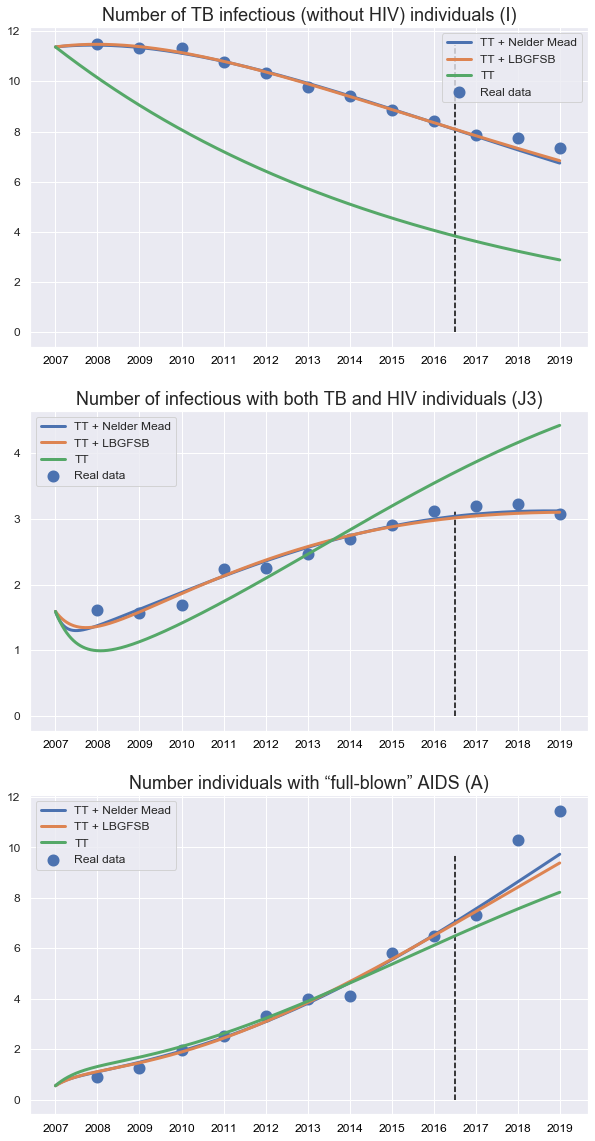

In [15]:
titles = ['Number of TB infectious (without HIV) individuals (I)',
          'Number of infectious with both TB and HIV individuals (J3)',
            'Number individuals with “full-blown” AIDS (A)']
plt.figure(figsize=(10,20))
for g in range(len(eq_ind)):
    plt.subplot(len(eq_ind), 1, g+1)
    i,j,_ = DP_exact.shape
    plot_lines = []
    
    # TT
    plt.plot(np.arange(j), TT_NM[eq_ind[g]],label = 'TT + Nelder Mead', linewidth =3)
    plt.plot(np.arange(j), TT_LBGFSB[eq_ind[g]],label = 'TT + LBGFSB', linewidth =3) 
    plt.plot(np.arange(j), TT[eq_ind[g]],label = 'TT', linewidth =3) 
    
    plt.scatter(np.arange(0, j, int(j/T))[1:], syn_data_full[g], label = 'Real data', linewidth =6)
    plt.vlines(9500, 0, TT_NM[eq_ind[g]].max(), linestyles='--',color='black')

    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, j, int(j/T)),
               np.arange(2007, 2007+T+1, 1.0, dtype=int), 
               color='black',fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(titles[g],fontsize=18)

plt.show()

In [49]:
i,j,_ = DP_exact.shape

In [51]:
T

12

In [50]:
j

12001

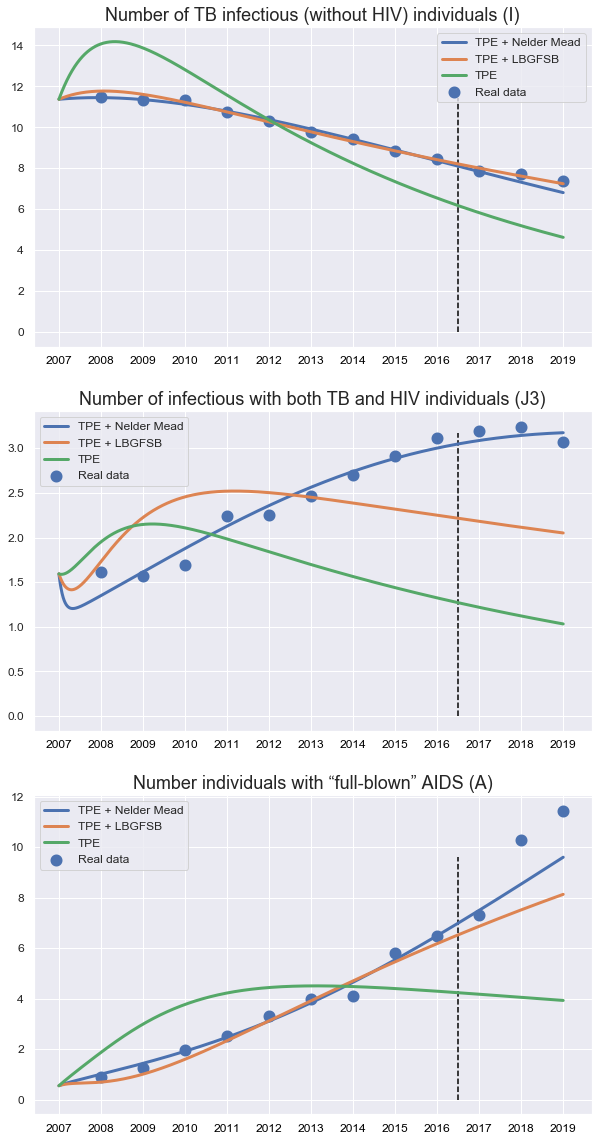

In [16]:
titles = ['Number of TB infectious (without HIV) individuals (I)',
          'Number of infectious with both TB and HIV individuals (J3)',
            'Number individuals with “full-blown” AIDS (A)']
plt.figure(figsize=(10,20))
for g in range(len(eq_ind)):
    plt.subplot(len(eq_ind), 1, g+1)
    i,j,_ = DP_exact.shape
    plot_lines = []
    
    
    plt.plot(np.arange(j), optuna_NM[eq_ind[g]],label = 'TPE + Nelder Mead', linewidth =3)
    plt.plot(np.arange(j), optuna_LBGFSB[eq_ind[g]],label = 'TPE + LBGFSB', linewidth =3) 
    plt.plot(np.arange(j), optuna[eq_ind[g]],label = 'TPE', linewidth =3) 
    
    plt.scatter(np.arange(0, j, int(j/T))[1:], syn_data_full[g], label = 'Real data', linewidth =6)
    plt.vlines(9500, 0, optuna_NM[eq_ind[g]].max(), linestyles='--',color='black')

    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, j, int(j/T)),
               np.arange(2007, 2007+T+1, 1.0, dtype=int), 
               color='black',fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(titles[g],fontsize=18)

plt.show()

In [55]:
syn_data_full[1][9:]

array([3.191, 3.235, 3.071])

In [57]:
syn_data_full[1]

array([1.616, 1.574, 1.688, 2.243, 2.248, 2.467, 2.702, 2.915, 3.117,
       3.191, 3.235, 3.071])

In [61]:
np.arange(0, j, int(j/T))[1:]

array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000, 11000, 12000])

In [25]:
a = np.array([1,2,3,4,5,6,7,8,9])
a[::2]

array([1, 3, 5, 7, 9])

In [22]:
len(optuna_NM[eq_ind[g]])

12001

In [27]:
np.arange(j)[::1000]

array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000])

In [ ]:
params_real_data = json.load(open('params_real_data_2018_10_params.json','r'))
P_real_data = json.load(open('P_real_data_2018_10_params.json','r'))

optuna_names = ['params_optuna', 'params_optuna_NM', 'params_optuna_LBGFSB']
TT_names     = ['params_TT',     'params_TT_NM',     'params_TT_LBGFSB']

optuna_P_names = ['P_optuna', 'P_optuna_NM', 'P_optuna_LBGFSB']
TT_P_names     = ['P_TT',     'P_TT_NM',     'P_TT_LBGFSB']

optuna_parameters = [np.array(params_real_data[k]) for k in optuna_names] # only 10 parameters
TT_parameters = [np.array(params_real_data[k]) for k in TT_names]

optuna_P = [np.array(P_real_data[k]) for k in optuna_P_names] # all parameters
TT_P = [np.array(P_real_data[k]) for k in TT_P_names]


Nb_mes_eq = 3
eq_ind = np.zeros(Nb_mes_eq, dtype=int)

eq_ind[0]=2
eq_ind[1]=6
eq_ind[2]=7

## Time-line and total number of mesurements
T = 12 #12 #7 ### 
Nb_mes = 12 #7 ### one mesurement per year
DP_exact = rungekutta4(TB_HIV_model, P_exact, Y0, T)

#TT
TT = rungekutta4(TB_HIV_model, TT_P[0], Y0, T)
TT_NM = rungekutta4(TB_HIV_model, TT_P[1], Y0, T)
TT_LBGFSB = rungekutta4(TB_HIV_model, TT_P[2], Y0, T)


#optuna
optuna = rungekutta4(TB_HIV_model, optuna_P[0], Y0, T)
optuna_NM = rungekutta4(TB_HIV_model, optuna_P[1], Y0, T)
optuna_LBGFSB = rungekutta4(TB_HIV_model, optuna_P[2], Y0, T)

# diff evolution
# diff_evol = rungekutta4(TB_HIV_model, P_diff, Y0, T)
# diff_evol_NM = rungekutta4(TB_HIV_model, P_diff_NM, Y0, T)
# diff_evol_LBGFSB = rungekutta4(TB_HIV_model, P_diff_LBGFSB, Y0, T)

In [17]:
optuna_P

[array([4.30000000e+01, 1.11406361e-01, 6.53219573e-01, 1.43000000e-02,
        1.79037835e-03, 1.81610421e-01, 1.00000000e-01, 2.00000000e-01,
        5.00000000e-01, 1.05929115e+00, 1.33760811e-03, 1.95737450e+00,
        3.45559504e-03, 5.26772643e-04, 1.09792760e+00, 4.31575900e+03]),
 array([ 4.30000000e+01, -5.39662262e-01,  2.95127857e-01,  1.43000000e-02,
         3.60794085e-04,  3.30250832e-01,  1.00000000e-01,  2.00000000e-01,
         5.00000000e-01,  1.29294778e-01, -8.06583851e-03,  7.54704466e+00,
         3.42419978e-02,  1.87662193e-03,  5.28149058e-01,  4.31575900e+03]),
 array([ 4.30000000e+01,  1.70028152e-01,  8.50923087e-01,  1.43000000e-02,
         3.75672752e-04,  1.34642854e-01,  1.00000000e-01,  2.00000000e-01,
         5.00000000e-01,  8.11941697e-01, -6.42164426e-02,  1.95657028e+00,
         8.90868418e-03, -3.25612225e-02,  1.07312222e+00,  4.31575900e+03])]

In [19]:
P_real_data['P_optuna_NM']

[43.0,
 -0.539662261703977,
 0.2951278569488272,
 0.0143,
 0.0003607940849950023,
 0.3302508316916608,
 0.1,
 0.2,
 0.5,
 0.12929477824091337,
 -0.00806583850529125,
 7.54704465560466,
 0.03424199778727999,
 0.0018766219257978888,
 0.528149058463098,
 4315.759]

In [ ]:
TT_NM

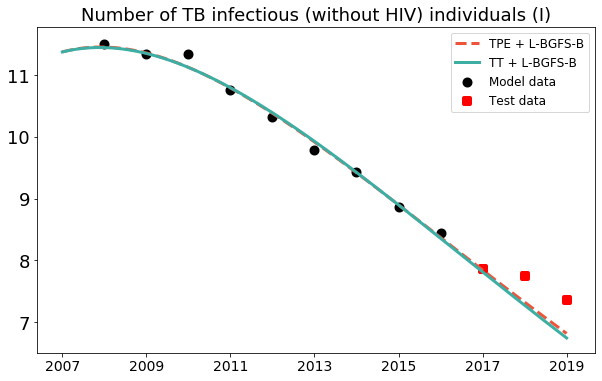

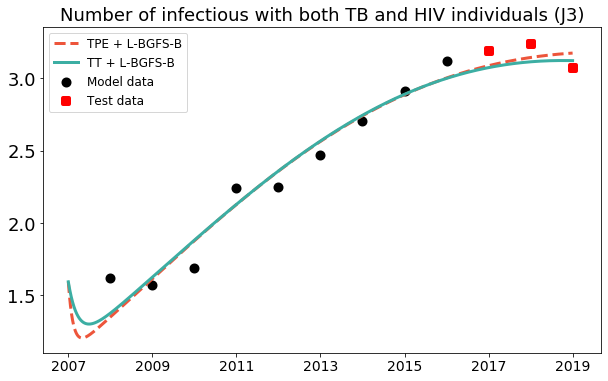

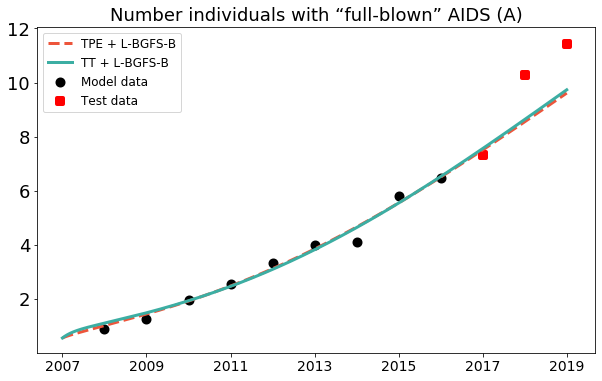

In [15]:
titles = ['Number of TB infectious (without HIV) individuals (I)',
          'Number of infectious with both TB and HIV individuals (J3)',
          'Number individuals with “full-blown” AIDS (A)']
for g in range(len(eq_ind)):
    plt.figure(figsize=(10,6))
    #plt.subplot(len(eq_ind), 1, g+1)
    i,j,_ = DP_exact.shape
    plot_lines = []
    
    
    plt.plot(np.arange(j), optuna_NM[eq_ind[g]],label = 'TPE + L-BGFS-B', linewidth = 3, linestyle = 'dashed', color = '#ED553B')#= '#009392')
    plt.plot(np.arange(j), TT_NM[eq_ind[g]],label = 'TT + L-BGFS-B', linewidth = 3, linestyle = 'solid', color = '#3CAEA3')#'#D0587E')
    
    plt.scatter(np.arange(0, j, int(j/T))[1:][:9], syn_data_full[g][:9], label = 'Model data', linewidth =4, color='black')
    plt.scatter(np.arange(0, j, int(j/T))[1:][9:], syn_data_full[g][9:], label = 'Test data', linewidth =4, color='red', marker='s')
    #plt.vlines(9500, 0, syn_data_full[g].max(), linestyles='--',color='black')

    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, j, int(2*j/T)),
               np.arange(2007, 2007+T+1, 2.0, dtype=int), 
               color='black',fontsize=14)
    plt.yticks(fontsize=18)
    plt.title(titles[g],fontsize=18)

    plt.show()

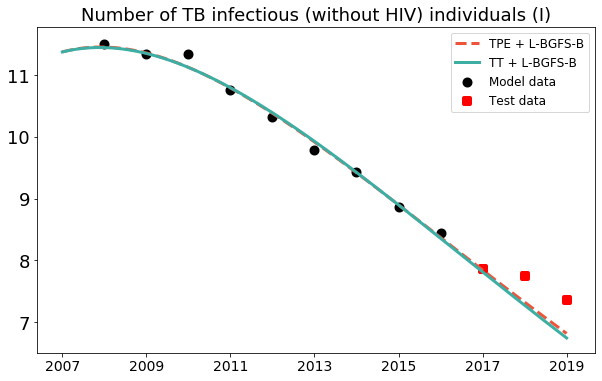

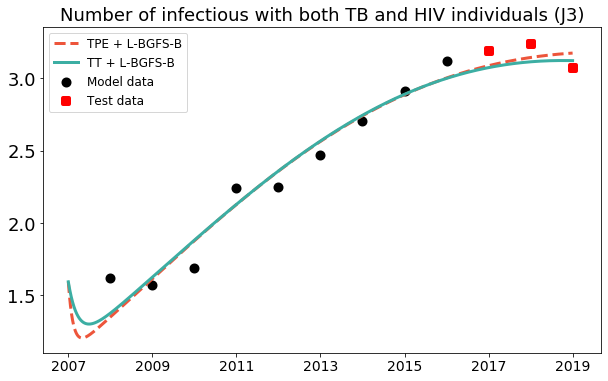

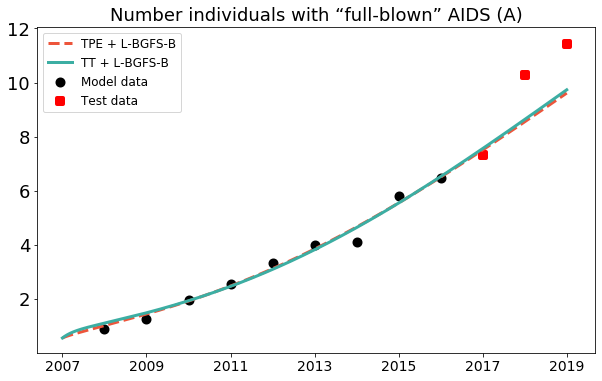

In [16]:
titles = ['Number of TB infectious (without HIV) individuals (I)',
          'Number of infectious with both TB and HIV individuals (J3)',
          'Number individuals with “full-blown” AIDS (A)']
for g in range(len(eq_ind)):
    plt.figure(figsize=(10,6))
    #plt.subplot(len(eq_ind), 1, g+1)
    i,j,_ = DP_exact.shape
    plot_lines = []
    
    
    plt.plot(np.arange(j), optuna_NM[eq_ind[g]],label = 'TPE + L-BGFS-B', linewidth = 3, linestyle = 'dashed', color = '#ED553B')#= '#009392')
    plt.plot(np.arange(j), TT_NM[eq_ind[g]],label = 'TT + L-BGFS-B', linewidth = 3, linestyle = 'solid', color = '#3CAEA3')#'#D0587E')
    
    plt.scatter(np.arange(0, j, int(j/T))[1:][:9], syn_data_full[g][:9], label = 'Model data', linewidth =4, color='black')
    plt.scatter(np.arange(0, j, int(j/T))[1:][9:], syn_data_full[g][9:], label = 'Test data', linewidth =4, color='red', marker='s')
    #plt.vlines(9500, 0, syn_data_full[g].max(), linestyles='--',color='black')

    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, j, int(2*j/T)),
               np.arange(2007, 2007+T+1, 2.0, dtype=int), 
               color='black',fontsize=14)
    plt.yticks(fontsize=18)
    plt.title(titles[g],fontsize=18)

    plt.show()

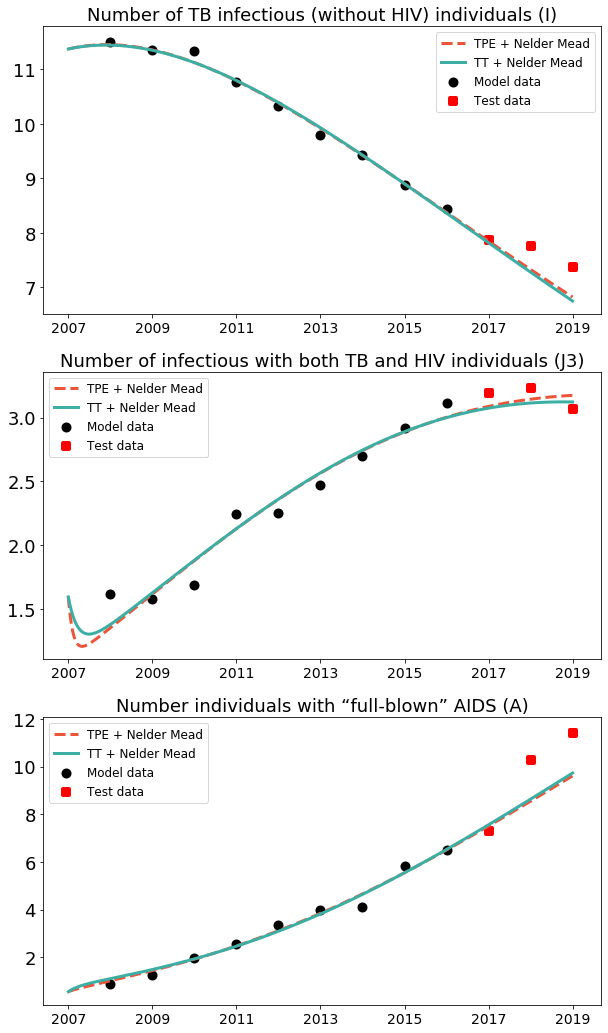

In [37]:
titles = ['Number of TB infectious (without HIV) individuals (I)',
          'Number of infectious with both TB and HIV individuals (J3)',
          'Number individuals with “full-blown” AIDS (A)']
plt.figure(figsize=(10,18))
for g in range(len(eq_ind)):
    plt.subplot(len(eq_ind), 1, g+1)
    i,j,_ = DP_exact.shape
    plot_lines = []
    
    
    plt.plot(np.arange(j), optuna_NM[eq_ind[g]],label = 'TPE + L-BGFS-B', linewidth = 3, linestyle = 'dashed', color = '#ED553B')#= '#009392')
    plt.plot(np.arange(j), TT_NM[eq_ind[g]],label = 'TT + L-BGFS-B', linewidth = 3, linestyle = 'solid', color = '#3CAEA3')#'#D0587E')
    
    plt.scatter(np.arange(0, j, int(j/T))[1:][:9], syn_data_full[g][:9], label = 'Model data', linewidth =4, color='black')
    plt.scatter(np.arange(0, j, int(j/T))[1:][9:], syn_data_full[g][9:], label = 'Test data', linewidth =4, color='red', marker='s')
    #plt.vlines(9500, 0, syn_data_full[g].max(), linestyles='--',color='black')

    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, j, int(2*j/T)),
               np.arange(2007, 2007+T+1, 2.0, dtype=int), 
               color='black',fontsize=14)
    plt.yticks(fontsize=18)
    plt.title(titles[g],fontsize=18)

plt.show()

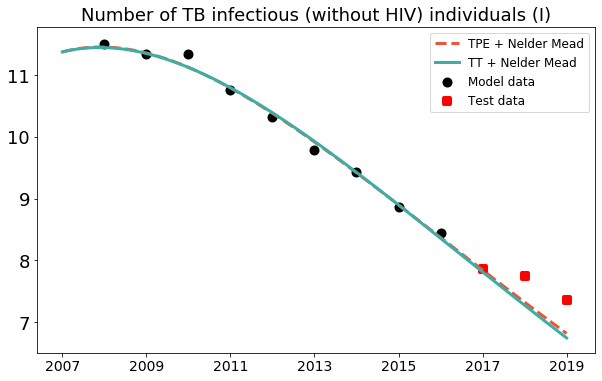

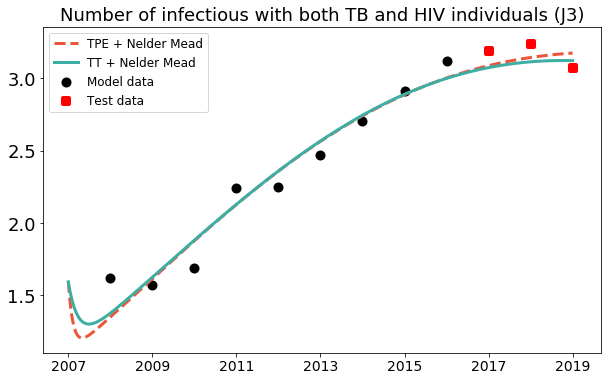

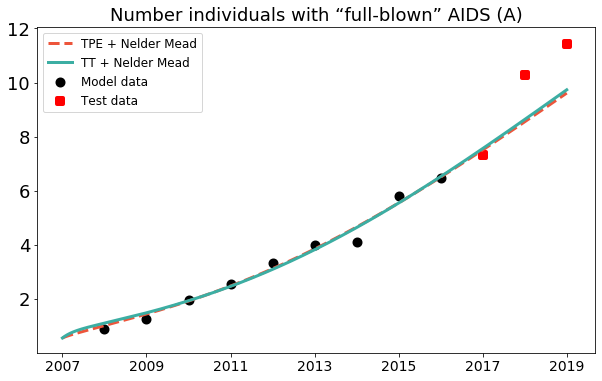

In [38]:
titles = ['Number of TB infectious (without HIV) individuals (I)',
          'Number of infectious with both TB and HIV individuals (J3)',
          'Number individuals with “full-blown” AIDS (A)']

for g in range(len(eq_ind)):
    plt.figure(figsize=(10,6))
    i,j,_ = DP_exact.shape
    plot_lines = []
    
    
    
    plt.plot(np.arange(j), optuna_NM[eq_ind[g]],label = 'TPE + Nelder Mead', linewidth = 3, linestyle = 'dashed', color = '#ED553B')#= '#009392')
    plt.plot(np.arange(j), TT_NM[eq_ind[g]],label = 'TT + Nelder Mead', linewidth = 3, linestyle = 'solid', color = '#3CAEA3')#'#D0587E')
    
    
    plt.scatter(np.arange(0, j, int(j/T))[1:][:9], syn_data_full[g][:9], label = 'Model data', linewidth =4, color='black')
    plt.scatter(np.arange(0, j, int(j/T))[1:][9:], syn_data_full[g][9:], label = 'Test data', linewidth =4, color='red', marker='s')
    #plt.vlines(9500, 0, syn_data_full[g].max(), linestyles='--',color='black')

    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, j, int(2*j/T)),
               np.arange(2007, 2007+T+1, 2.0, dtype=int), 
               color='black',fontsize=14)
    plt.yticks(fontsize=18)
    plt.title(titles[g],fontsize=18)
    plt.show()

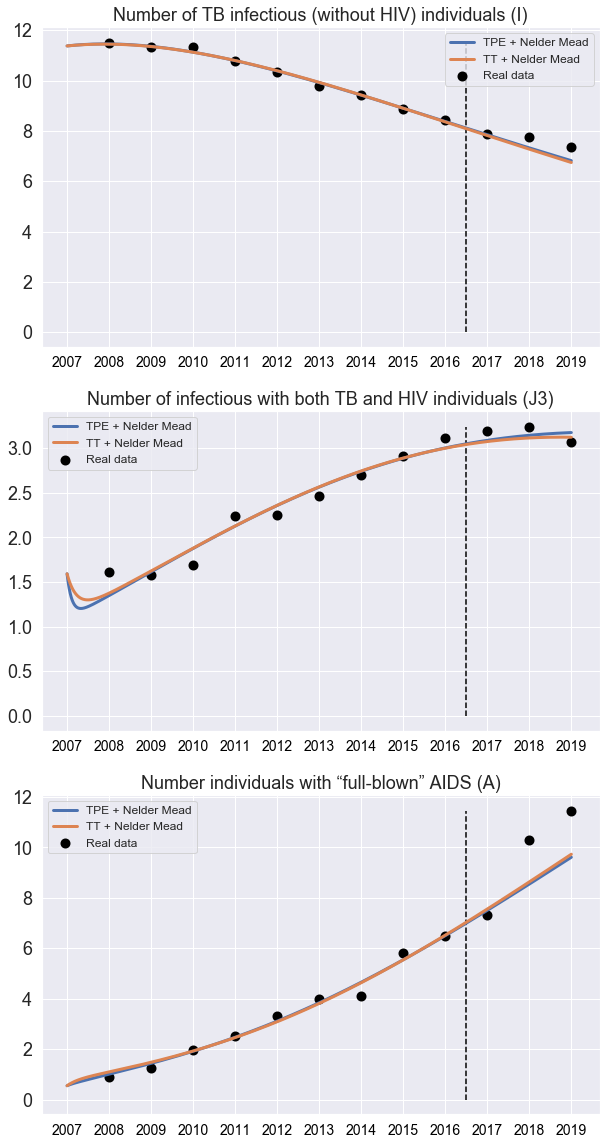

In [46]:
titles = ['Number of TB infectious (without HIV) individuals (I)',
          'Number of infectious with both TB and HIV individuals (J3)',
          'Number individuals with “full-blown” AIDS (A)']
plt.figure(figsize=(10,20))
for g in range(len(eq_ind)):
    plt.subplot(len(eq_ind), 1, g+1)
    i,j,_ = DP_exact.shape
    plot_lines = []
    
    
    plt.plot(np.arange(j), optuna_NM[eq_ind[g]],label = 'TPE + Nelder Mead', linewidth =3)#, color = 'navy')
    plt.plot(np.arange(j), TT_NM[eq_ind[g]],label = 'TT + Nelder Mead', linewidth =3)#, color = 'firebrick')
    
    
    plt.scatter(np.arange(0, j, int(j/T))[1:], syn_data_full[g], label = 'Real data', linewidth =4, color='black')
    plt.vlines(9500, 0, syn_data_full[g].max(), linestyles='--',color='black')

    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, j, int(j/T)),
               np.arange(2007, 2007+T+1, 1.0, dtype=int), 
               color='black',fontsize=14)
    plt.yticks(fontsize=18)
    plt.title(titles[g],fontsize=18)

plt.show()

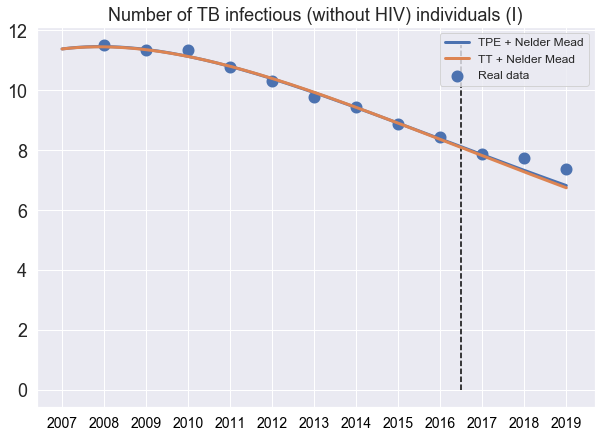

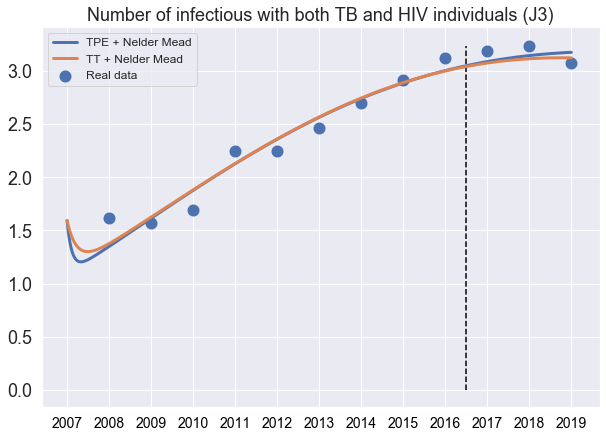

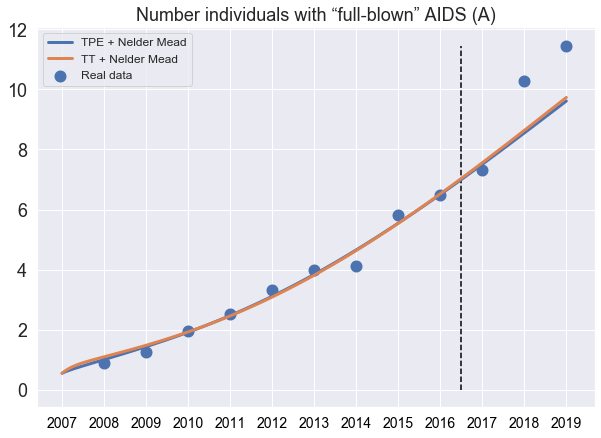

In [35]:
titles = ['Number of TB infectious (without HIV) individuals (I)',
          'Number of infectious with both TB and HIV individuals (J3)',
          'Number individuals with “full-blown” AIDS (A)']

for g in range(len(eq_ind)):
    plt.figure(figsize=(10,7))
    #plt.subplot(len(eq_ind), 1, g+1)
    i,j,_ = DP_exact.shape
    plot_lines = []
    
    
    plt.plot(np.arange(j), optuna_NM[eq_ind[g]],label = 'TPE + Nelder Mead', linewidth =3)
    plt.plot(np.arange(j), TT_NM[eq_ind[g]],label = 'TT + Nelder Mead', linewidth =3)
    
    
    plt.scatter(np.arange(0, j, int(j/T))[1:], syn_data_full[g], label = 'Real data', linewidth =6)
    plt.vlines(9500, 0, syn_data_full[g].max(), linestyles='--',color='black')

    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, j, int(j/T)),
               np.arange(2007, 2007+T+1, 1.0, dtype=int), 
               color='black',fontsize=14)
    plt.yticks(fontsize=18)
    plt.title(titles[g],fontsize=18)
    plt.show()

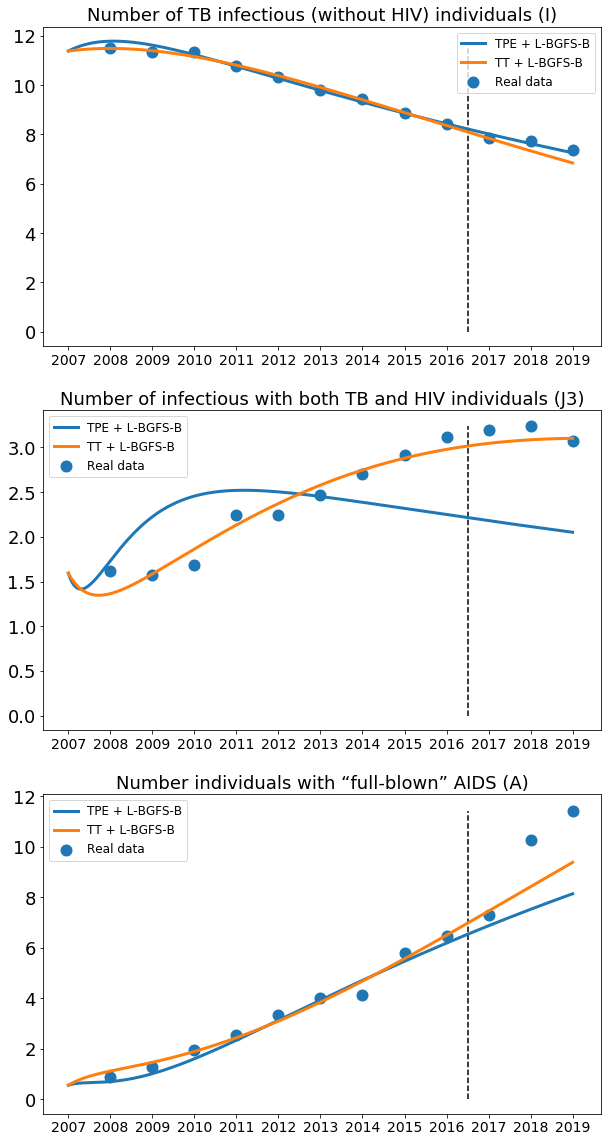

In [16]:
titles = ['Number of TB infectious (without HIV) individuals (I)',
          'Number of infectious with both TB and HIV individuals (J3)',
          'Number individuals with “full-blown” AIDS (A)']

plt.figure(figsize=(10,20))
for g in range(len(eq_ind)):
    plt.subplot(len(eq_ind), 1, g+1)
    i,j,_ = DP_exact.shape
    plot_lines = []
    
    
    plt.plot(np.arange(j), optuna_LBGFSB[eq_ind[g]],label = 'TPE + L-BGFS-B', linewidth =3)
    plt.plot(np.arange(j), TT_LBGFSB[eq_ind[g]],label = 'TT + L-BGFS-B', linewidth =3)
    
    
    plt.scatter(np.arange(0, j, int(j/T))[1:], syn_data_full[g], label = 'Real data', linewidth =6)
    plt.vlines(9500, 0, syn_data_full[g].max(), linestyles='--',color='black')

    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, j, int(j/T)),
               np.arange(2007, 2007+T+1, 1.0, dtype=int), 
               color='black',fontsize=14)
    plt.yticks(fontsize=18)
    plt.title(titles[g],fontsize=18)
plt.show()